In [1]:
import json, requests, time
from sqlalchemy import create_engine
import pandas as pd

engine = create_engine('postgresql://postgres:argmax@pg:5432/postgres')


# Installations and imports

In [2]:
!pip install matplotlib
!pip install seaborn
!pip install networkx
!pip install scikit-learn

In [3]:
import networkx as nx
import numpy as np
from sklearn.cluster import KMeans
import random
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Data
Every time a user opens a mobile app, an auction is going on behind the scenes. The highest bidder gets to advertise his ad to the user.
## Auctions Table

In [4]:
sql_query = 'SELECT * FROM auctions;'
with engine.connect() as db_con:
    df_auc = pd.read_sql(sql_query, con=db_con)

df_auc

,id,eventTimestamp,unitDisplayType,brandName,bundleId,countryCode,deviceId,osAndVersion,bidFloorPrice,sentPrice
0,1,1657758857892,rewarded,Generic,com.loop.match3d,US,6a0a94554cf,Android-4.0,0.05,0.06
1,2,1657210707978,interstitial,Generic,com.loop.match3d,ZA,6a0b0e59f45,Android-4.0,0.01,0.16
2,3,1657392939412,interstitial,Motorola,com.YayySAL.DodgeAgent,BR,6a0fa820c46,Android-10.0,0.05,0.06
3,4,1657386816882,interstitial,Huawei,com.tintash.nailsalon,IQ,6a142bdbea2,Android-9.0,0.01,0.05
4,5,1657211600823,banner,Generic,com.tilegarden.match3,US,6a16943a771,Android-4.0,0.01,0.03
...,...,...,...,...,...,...,...,...,...,...
41579,41580,1657731605063,banner,Generic,com.tilegarden.match3,NZ,80edf5837e8,Android-4.0,0.01,0.02
41580,41581,1657657131101,interstitial,Apple,1436213906,VN,80ee6a5eebf,iOS-13.6,0.01,0.90
41581,41582,1657156070854,rewarded,Generic,com.loop.match3d,US,80efe531afc,Android-4.0,0.05,0.69
41582,41583,1657659603568,banner,Apple,1502447854,US,80f02dd397f,iOS-15.0,0.01,0.10


# EDA
Exploring the data of auctions

In [5]:
df_auc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41584 entries, 0 to 41583
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               41584 non-null  int64  
 1   eventTimestamp   41584 non-null  object 
 2   unitDisplayType  41584 non-null  object 
 3   brandName        41584 non-null  object 
 4   bundleId         41584 non-null  object 
 5   countryCode      41584 non-null  object 
 6   deviceId         41584 non-null  object 
 7   osAndVersion     41584 non-null  object 
 8   bidFloorPrice    41584 non-null  float64
 9   sentPrice        41584 non-null  float64
dtypes: float64(2), int64(1), object(7)
memory usage: 3.2+ MB


Lets see how the sent price distributes

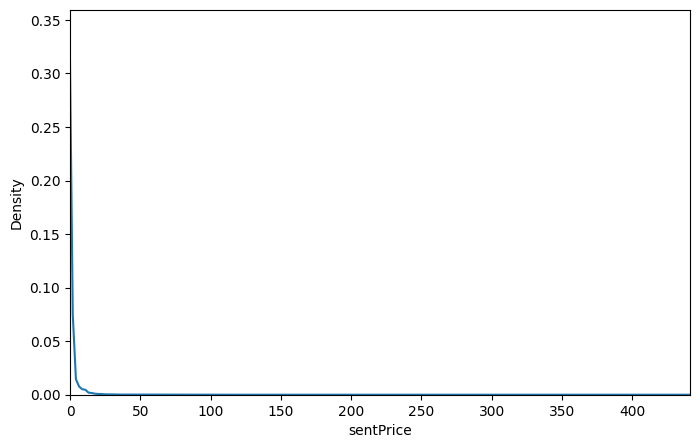

In [6]:

plt.figure(figsize=(8,5))
plt.xlim(0,np.max(df_auc['sentPrice'])) 
plt.xlabel('sentPrice')
plt.ylabel('Density')
sns.kdeplot(df_auc['sentPrice'])
plt.show()

As we can see there is a long tail of very high price auctions lets filter the data and keep the 99% at the end we can see what is the features of the rest 1% of highest auctions

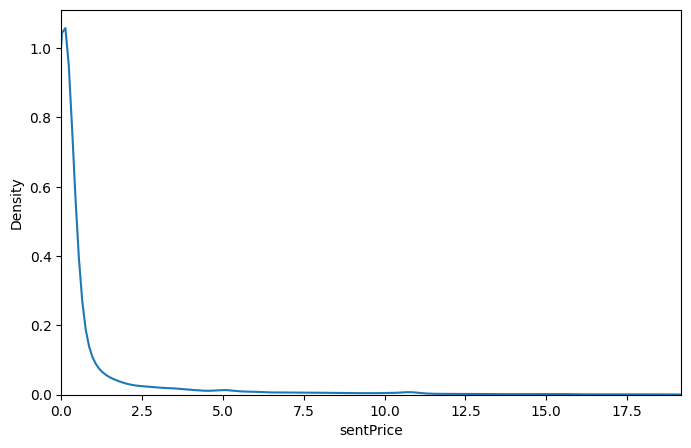

In [7]:
q = df_auc["sentPrice"].quantile(0.99)
df_filtered = df_auc[df_auc["sentPrice"]< q ] 
plt.figure(figsize=(8,5))
plt.xlim(0,np.max(df_filtered['sentPrice'])) 
plt.xlabel('sentPrice')
plt.ylabel('Density')
sns.kdeplot(df_filtered['sentPrice'])
plt.show()

There are also features as unitDisplayType and brandName, using groupby method we can understand if there is a variance between this features using the count and std we can decide if they give us more explniability to the sent price

In [8]:
df_filtered.groupby(["bundleId","unitDisplayType"])["sentPrice"].agg( ['mean', 'min', 'max','std','count'])

mean   min    max       std  \
bundleId                    unitDisplayType                                    
1436213906                  interstitial     4.125326  0.01  18.97  4.145335   
                            rewarded         2.439332  0.01  19.13  3.638218   
1502447854                  banner           0.205629  0.01   7.82  0.396766   
                            interstitial     2.676969  0.01  16.22  3.098329   
                            rewarded         4.465664  0.01  19.01  4.244350   
1523081624                  banner           0.235398  0.01   3.48  0.350043   
                            interstitial     2.022347  0.01  17.27  3.676844   
                            rewarded         2.478602  0.01  18.94  4.350228   
1529614832                  banner           0.329252  0.01  12.83  0.970097   
                            interstitial     2.436522  0.02  13.27  3.417791   
                            rewarded         2.355476  0.02  18.00  3.881919   
1542256628                  banner           0.485537  0.05   2.48  0.500941   
                            interstitial     4.929487  0.09  18.29  5.547726   
                            rewarded         3.442917  0.05  10.53  3.449066   
1569586264                  interstitial     8.009500  0.45  18.39  5.150989   
                            rewarded         7.653077  1.16  17.76  4.640814   
1579489488                  banner           0.289212  0.05   9.50  0.812734   
                            interstitial     1.735556  0.05  15.93  2.816761   
                            rewarded         3.839310  0.06  16.76  5.245038   
1582745578                  banner           0.289167  0.05   2.31  0.511532   
                            rewarded         2.648333  0.06  18.91  5.506423   
1586795332                  banner           0.366098  0.05   3.81  0.518748   
                            interstitial     2.635055  0.05  16.82  4.409970   
                            rewarded         1.783889  0.05  13.24  3.223814   
com.AppIdeas.LevelUpRunner  banner           0.131547  0.05   3.32  0.231687   
com.YayySAL.DodgeAgent      banner           0.128158  0.05   4.75  0.242074   
                            interstitial     0.702584  0.05  17.88  1.839945   
                            rewarded         0.910698  0.05  18.06  2.146005   
com.kamilbilge.ropesavior3d banner           0.113202  0.05   2.87  0.215520   
                            interstitial     0.611508  0.05  18.87  1.410211   
                            rewarded         0.909099  0.05  19.17  2.146184   
com.loop.match3d            banner           0.131116  0.01   5.89  0.259186   
                            interstitial     1.030505  0.01  18.64  2.164414   
                            rewarded         2.059349  0.01  19.13  3.361323   
com.tilegarden.match3       banner           0.111371  0.01   4.25  0.248319   
                            interstitial     1.563503  0.01  19.18  3.075259   
                            rewarded         2.765650  0.01  18.57  4.295909   
com.tintash.nailsalon       banner           0.087617  0.01   3.07  0.215692   
                            interstitial     0.429000  0.01  18.68  1.424682   
                            rewarded         0.834757  0.01  18.02  2.242391   
com.volt.dresstoimpress     banner           0.048968  0.01   2.02  0.078794   
                            interstitial     1.705287  0.01   7.01  1.146098   
                            rewarded         0.780055  0.02   6.58  0.869840   
dovi.coalmining.inc         banner           0.132561  0.05   2.94  0.268324   
                            rewarded         0.587672  0.05  14.00  1.385001   
se.ace.fishinc              interstitial     1.230993  0.01  18.68  2.659123   
                            rewarded         1.677101  0.01  19.02  3.410550   

                                             count  
bundleId                    unitDisplayType         
1436213906            

In [9]:
df_filtered.groupby(["bundleId","unitDisplayType","brandName"])["sentPrice"].agg( ['mean', 'min', 'max','std','count'])

mean   min    max       std  \
bundleId       unitDisplayType brandName                                    
1436213906     interstitial    Apple      4.125326  0.01  18.97  4.145335   
               rewarded        Apple      2.439332  0.01  19.13  3.638218   
1502447854     banner          Apple      0.205629  0.01   7.82  0.396766   
               interstitial    Apple      2.676969  0.01  16.22  3.098329   
               rewarded        Apple      4.465664  0.01  19.01  4.244350   
...                                            ...   ...    ...       ...   
se.ace.fishinc rewarded        Vivo       0.823200  0.01  11.17  2.252726   
                               Vsmart     1.750000  1.75   1.75       NaN   
                               Wiko       4.950000  0.02  10.85  5.479772   
                               Xiaomi     0.476886  0.01  10.43  1.183735   
                               ZTE        2.964286  0.02  16.58  6.181127   

                                          count  
bundleId       unitDisplayType brandName         
1436213906     interstitial    Apple        659  
               rewarded        Apple        569  
1502447854     banner          Apple       2240  
               interstitial    Apple        287  
               rewarded        Apple        595  
...                                         ...  
se.ace.fishinc rewarded        Vivo          25  
                               Vsmart         1  
                               Wiko           3  
                               Xiaomi       273  
                               ZTE            7  

[936 rows x 5 columns]

We can defenitly see that unitDisplayType matters where banner is always signifcantly lower than interstitial and rewarded type, but it is still not enough and the brand name is too sparse so we won't use it. therefor we will see how the operating system contributs:

In [10]:
df_filtered["os"] = list(df_filtered["osAndVersion"].apply(lambda x: x.split('-')[0]))
df_filtered

,id,eventTimestamp,unitDisplayType,brandName,bundleId,countryCode,deviceId,osAndVersion,bidFloorPrice,sentPrice,os
0,1,1657758857892,rewarded,Generic,com.loop.match3d,US,6a0a94554cf,Android-4.0,0.05,0.06,Android
1,2,1657210707978,interstitial,Generic,com.loop.match3d,ZA,6a0b0e59f45,Android-4.0,0.01,0.16,Android
2,3,1657392939412,interstitial,Motorola,com.YayySAL.DodgeAgent,BR,6a0fa820c46,Android-10.0,0.05,0.06,Android
3,4,1657386816882,interstitial,Huawei,com.tintash.nailsalon,IQ,6a142bdbea2,Android-9.0,0.01,0.05,Android
4,5,1657211600823,banner,Generic,com.tilegarden.match3,US,6a16943a771,Android-4.0,0.01,0.03,Android
...,...,...,...,...,...,...,...,...,...,...,...
41579,41580,1657731605063,banner,Generic,com.tilegarden.match3,NZ,80edf5837e8,Android-4.0,0.01,0.02,Android
41580,41581,1657657131101,interstitial,Apple,1436213906,VN,80ee6a5eebf,iOS-13.6,0.01,0.90,iOS
41581,41582,1657156070854,rewarded,Generic,com.loop.match3d,US,80efe531afc,Android-4.0,0.05,0.69,Android
41582,41583,1657659603568,banner,Apple,1502447854,US,80f02dd397f,iOS-15.0,0.01,0.10,iOS


In [11]:

df_filtered.groupby(["bundleId","unitDisplayType","os"])["sentPrice"].agg( ['mean', 'min', 'max','std','count'])

mean   min    max  \
bundleId                    unitDisplayType os                               
1436213906                  interstitial    iOS      4.125326  0.01  18.97   
                            rewarded        iOS      2.439332  0.01  19.13   
1502447854                  banner          iOS      0.205629  0.01   7.82   
                            interstitial    iOS      2.676969  0.01  16.22   
                            rewarded        iOS      4.465664  0.01  19.01   
1523081624                  banner          iOS      0.235398  0.01   3.48   
                            interstitial    iOS      2.022347  0.01  17.27   
                            rewarded        iOS      2.478602  0.01  18.94   
1529614832                  banner          iOS      0.329252  0.01  12.83   
                            interstitial    iOS      2.436522  0.02  13.27   
                            rewarded        iOS      2.355476  0.02  18.00   
1542256628                  banner          iOS      0.485537  0.05   2.48   
                            interstitial    iOS      4.929487  0.09  18.29   
                            rewarded        iOS      3.442917  0.05  10.53   
1569586264                  interstitial    iOS      8.009500  0.45  18.39   
                            rewarded        iOS      7.653077  1.16  17.76   
1579489488                  banner          iOS      0.289212  0.05   9.50   
                            interstitial    iOS      1.735556  0.05  15.93   
                            rewarded        iOS      3.839310  0.06  16.76   
1582745578                  banner          iOS      0.289167  0.05   2.31   
                            rewarded        iOS      2.648333  0.06  18.91   
1586795332                  banner          iOS      0.366098  0.05   3.81   
                            interstitial    iOS      2.635055  0.05  16.82   
                            rewarded        iOS      1.783889  0.05  13.24   
com.AppIdeas.LevelUpRunner  banner          Android  0.131547  0.05   3.32   
com.YayySAL.DodgeAgent      banner          Android  0.128158  0.05   4.75   
                            interstitial    Android  0.702584  0.05  17.88   
                            rewarded        Android  0.910698  0.05  18.06   
com.kamilbilge.ropesavior3d banner          Android  0.113202  0.05   2.87   
                            interstitial    Android  0.611508  0.05  18.87   
                            rewarded        Android  0.909099  0.05  19.17   
com.loop.match3d            banner          Android  0.131116  0.01   5.89   
                            interstitial    Android  1.030505  0.01  18.64   
                            rewarded        Android  2.059349  0.01  19.13   
com.tilegarden.match3       banner          Android  0.111371  0.01   4.25   
                            interstitial    Android  1.563503  0.01  19.18   
                            rewarded        Android  2.765650  0.01  18.57   
com.tintash.nailsalon       banner          Android  0.087617  0.01   3.07   
                            interstitial    Android  0.429000  0.01  18.68   
                            rewarded        Android  0.834757  0.01  18.02   
com.volt.dresstoimpress     banner          Android  0.048968  0.01   2.02   
                            interstitial    Android  1.705287  0.01   7.01   
                            rewarded        Android  0.780055  0.02   6.58   
dovi.coalmining.inc         banner          Android  0.132561  0.05   2.94   
                            rewarded        Android  0.587672  0.05  14.00   
se.ace.fishinc              interstitial    Android  1.230993  0.01  18.68   
                            rewarded        Android  1.677101  0.01  19.02   

                                                          std  count  
bundleId                    unitDisplayType os                        
1436213906                  interstitial    iOS      4.145335    659  
                     

Now we can see that the companies has preferance for operating system , so even if the app descriptions will be similare I am guessing that if the operating system won't suit the client he won't bid. The variance is still high in some cases let see if the countrys can add some more information:

In [12]:
df_auc.countryCode.unique(), str(len(df_auc.countryCode.unique())) +" Countrys"

(array(['US', 'ZA', 'BR', 'IQ', 'CL', 'MX', 'ID', 'VN', 'SV', 'GE', 'PH',
        'IN', 'IL', 'AU', 'NI', 'FR', 'UA', 'KR', 'TR', 'RU', 'GB', 'NL',
        'SK', 'IE', 'DE', 'EG', 'EC', 'JP', 'AZ', 'PK', 'BD', 'SE', 'AR',
        'CA', 'KW', 'BY', 'PT', 'NG', 'ES', 'AF', 'DZ', 'FI', 'IT', 'RO',
        'BE', 'CH', 'JO', 'PL', 'CR', 'TW', 'LU', 'HR', 'CO', 'MY', 'MA',
        'NO', 'SA', 'DK', 'MD', 'MU', 'NZ', 'PE', 'TH', 'MN', 'CZ', 'BO',
        'NE', 'BG', 'PA', 'KZ', 'PR', 'PG', 'GR', 'AT', 'TN', 'SI', 'CY',
        'LY', 'AE', 'AL', 'NP', 'GT', 'LT', 'RS', 'HU', 'DO', 'AM', 'LV',
        'KH', 'SG', 'HN', 'GM', 'KG', 'TJ', 'UZ', 'ZW', 'MK', 'GI', 'HK',
        'NA', 'VE', 'BB', 'CI', 'BF', 'CN', 'MM', 'IS', 'KE', 'OM', 'QA',
        'BA', 'SD', 'EE', 'PY', 'CG', 'PF', 'SO', 'LK', 'FJ', 'GH', 'DJ',
        'GY', 'ML', 'CD', 'UY', 'BH', 'ZM', 'BS', 'MW', 'BW', 'TT', 'TZ',
        'AO', 'ME', 'SM', 'CV', 'MT', 'ST', 'UG', 'JM', 'MZ', 'GL', 'CM',
        'GN', 'TM', 'MV', 'TG', 'PS', 

In [13]:
df_auc.groupby(["bundleId","unitDisplayType","countryCode"])["sentPrice"].agg( ['mean', 'min', 'max','std','count']) 

mean   min    max        std  \
bundleId       unitDisplayType countryCode                                     
1436213906     interstitial    AE           6.856667  0.02  33.03  13.216506   
                               AM           0.656667  0.55   0.72   0.092916   
                               AR           0.130000  0.13   0.13        NaN   
                               AU           1.822424  0.02  13.10   3.505906   
                               BA           0.040000  0.04   0.04        NaN   
...                                              ...   ...    ...        ...   
se.ace.fishinc rewarded        UY           0.230000  0.11   0.36   0.125300   
                               UZ           0.103333  0.09   0.13   0.023094   
                               VE           0.200000  0.03   0.72   0.269221   
                               VN           1.035758  0.02   3.45   0.802115   
                               ZA           1.768333  0.20   5.22   1.743762   

                                            count  
bundleId       unitDisplayType countryCode         
1436213906     interstitial    AE               6  
                               AM               3  
                               AR               1  
                               AU              33  
                               BA               1  
...                                           ...  
se.ace.fishinc rewarded        UY               3  
                               UZ               3  
                               VE               6  
                               VN              33  
                               ZA              12  

[2605 rows x 5 columns]

There are too many countries 171 in total and it is way too sparse , let see if we can catogrize them by similarity

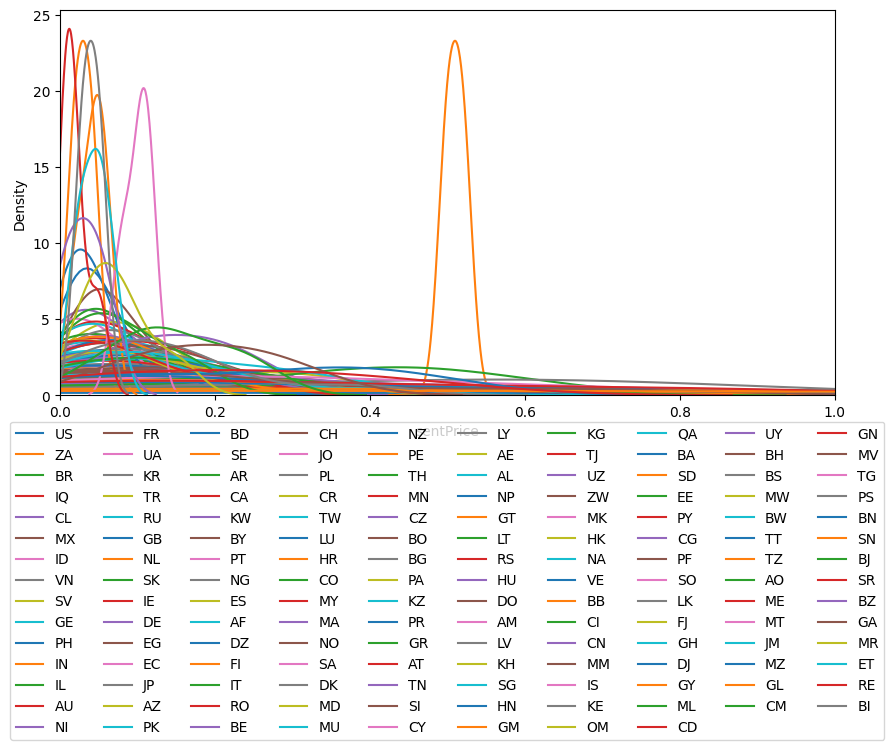

In [14]:
plt.figure(figsize=(10,5))
plt.xlim(0,1) 
plt.xlabel('sentPrice')
plt.ylabel('Density')
for c in df_auc.countryCode.unique():
  sns.kdeplot(df_filtered[df_filtered.countryCode==c]['sentPrice'],label = c)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=10)
plt.show()

As we can see there are difference between countries in the distribution, I suggest trying to divide them into 6 catagorize

In [15]:
df_c = df_filtered.groupby(["countryCode"])["sentPrice"].agg( ['mean','std','count'])
df_c

,mean,std,count
countryCode,,,
AD,0.110000,NaN,1
AE,0.852803,2.361304,132
AF,0.246250,0.496845,8
AL,0.177632,0.235664,38
AM,0.235909,0.367147,22
...,...,...,...
VN,0.501848,0.914182,1050
XK,0.200000,NaN,1
ZA,0.692160,1.755008,162


In [16]:
X = df_c[df_c.columns[0:2]].to_numpy()
X = np.nan_to_num(X)
kmeans = KMeans(n_clusters=6, random_state=0).fit(X)
df_c["CountryCat"] = list(kmeans.labels_)
df_c

,mean,std,count,CountryCat
countryCode,,,,
AD,0.110000,NaN,1,3
AE,0.852803,2.361304,132,2
AF,0.246250,0.496845,8,1
AL,0.177632,0.235664,38,3
AM,0.235909,0.367147,22,1
...,...,...,...,...
VN,0.501848,0.914182,1050,0
XK,0.200000,NaN,1,3
ZA,0.692160,1.755008,162,5


In [17]:
df_filtered["CountryCat"] = list(df_filtered["countryCode"].apply(lambda x: df_c[df_c.index==x]["CountryCat"].values[0]))
df_filtered


,id,eventTimestamp,unitDisplayType,brandName,bundleId,countryCode,deviceId,osAndVersion,bidFloorPrice,sentPrice,os,CountryCat
0,1,1657758857892,rewarded,Generic,com.loop.match3d,US,6a0a94554cf,Android-4.0,0.05,0.06,Android,4
1,2,1657210707978,interstitial,Generic,com.loop.match3d,ZA,6a0b0e59f45,Android-4.0,0.01,0.16,Android,5
2,3,1657392939412,interstitial,Motorola,com.YayySAL.DodgeAgent,BR,6a0fa820c46,Android-10.0,0.05,0.06,Android,1
3,4,1657386816882,interstitial,Huawei,com.tintash.nailsalon,IQ,6a142bdbea2,Android-9.0,0.01,0.05,Android,3
4,5,1657211600823,banner,Generic,com.tilegarden.match3,US,6a16943a771,Android-4.0,0.01,0.03,Android,4
...,...,...,...,...,...,...,...,...,...,...,...,...
41579,41580,1657731605063,banner,Generic,com.tilegarden.match3,NZ,80edf5837e8,Android-4.0,0.01,0.02,Android,2
41580,41581,1657657131101,interstitial,Apple,1436213906,VN,80ee6a5eebf,iOS-13.6,0.01,0.90,iOS,0
41581,41582,1657156070854,rewarded,Generic,com.loop.match3d,US,80efe531afc,Android-4.0,0.05,0.69,Android,4
41582,41583,1657659603568,banner,Apple,1502447854,US,80f02dd397f,iOS-15.0,0.01,0.10,iOS,4


In [18]:
df_c.groupby(["CountryCat"]).count()
#df_c[df_c.CountryCat == 0]

,mean,std,count
CountryCat,,,
0,19,19,19
1,45,45,45
2,11,11,11
3,75,52,75
4,5,5,5
5,16,16,16


## #TODO: Exploration of the highest 1% 

## App Vectors table
We've gathered the first few sentences from the app store description and embedded it with a [model](https://huggingface.co/mixedbread-ai/mxbai-embed-large-v1)

In [19]:
sql_query = f'''
SELECT
    *
FROM app_vectors
'''
has_embedding = False
while not has_embedding:
    with engine.connect() as db_con:
        df_app = pd.read_sql(sql_query, con=db_con)
    has_embedding = (~df_app["embedding"].isna()).all()
    if not has_embedding:
        print("Waiting for embeddings...")
        time.sleep(15)

df_app


,id,bundleId,content,embedding
0,1,com.loop.match3d,"Get ready for a new, challenging and original ...","[0.3168352,0.6250086,-0.12035585,0.21742323,-0..."
1,2,com.YayySAL.DodgeAgent,"Your mission, should you choose to accept it, ...","[0.5411282,0.7446755,-0.5817451,0.95967793,0.0..."
2,3,com.tintash.nailsalon,It is manicure madness over here and it�s your...,"[0.31176656,0.6059464,-1.1395648,0.07631045,-0..."
3,4,com.tilegarden.match3,\nIf you enjoy playing Match 3 tile & mahjong ...,"[0.050924458,1.0967327,-0.30831614,0.13220672,..."
4,6,com.AppIdeas.LevelUpRunner,"Are you a real hero? Are you the strongest, th...","[0.897561,0.46442518,-0.18019226,1.2617054,0.0..."
5,17,1582745578,Dominate the coal industry and become the next...,"[0.88490486,0.65851957,-0.3386694,0.18323663,0..."
6,18,1569586264,Choose the appropriate outfit to make it throu...,"[0.2000534,0.36083463,-0.13792263,0.34308642,-..."
7,5,com.kamilbilge.ropesavior3d,Become the hero we need in this tangled puzzle...,"[0.5112473,0.5128061,-0.05630451,1.2819325,0.1..."
8,7,se.ace.fishinc,Gather your riches and travel across the open ...,"[0.73094344,0.4112171,-0.6196014,0.53501374,0...."
9,8,com.volt.dresstoimpress,\nChoose the appropriate outfit to make it thr...,"[0.2000534,0.36083463,-0.13792263,0.34308642,-..."


We can use the `<=>` operator to run vector search within the database

In [21]:

vec = json.loads(df_app.embedding[0]) # get the first embedding
print ("Embedding size: {l}".format(l=len(vec)))

sql_query = f'''
SELECT
    "bundleId"
FROM app_vectors
ORDER BY embedding<=>'{json.dumps(vec)}'
'''
with engine.connect() as db_con:
    df1 = pd.read_sql(sql_query, con=db_con)

df1


Embedding size: 1024


,bundleId
0,com.loop.match3d
1,1502447854
2,1529614832
3,com.tilegarden.match3
4,com.kamilbilge.ropesavior3d
5,1579489488
6,1436213906
7,1586795332
8,com.AppIdeas.LevelUpRunner
9,se.ace.fishinc


# What you need to do
## The hypothesis
We assume that apps with similar desciptions, would have a similar asking price in the auctions (`sentPrice` column).

Use cosine similarity (`<=>`) on the embeddings to find similar apps, and any statistical tools you find suitable to prove or disprove this hypothesis.

## Is it consistent?
There are several other features in the auctions table (such as `CountryCode` and `OS`), 
Do your findings hold for those as well?

# Answer
Only cosine similarity on the embeddings to find similar apps will not do the trick. 
From the EDA above we have learned that there are more factors to consider, but just for the sake of this excersize we can see below that when using the raw tables with no other consideration tells us that the hypothesis fails.

Below I have tried to show that there is no indication of cosine similarity to the sent price , in the graph the requested app is in the middel and the apps nearest to her are the most similar , the sent price is presented by the size of the node (multiplyed) , even with the hectic design we can deduct that there are many apps similar to one another yet the sent price is defares.

                             avg_price  cosine_similarity
bundleId                                                 
com.loop.match3d              1.420811           1.000000
com.YayySAL.DodgeAgent        0.445529           0.480975
com.tintash.nailsalon         0.300057           0.459344
com.tilegarden.match3         2.297261           0.658637
com.kamilbilge.ropesavior3d   0.451491           0.557880
1529614832                    3.121816           0.719058
1523081624                    1.101837           0.459344
1502447854                    2.269482           0.922637
com.AppIdeas.LevelUpRunner    0.131547           0.509649
se.ace.fishinc                1.831922           0.502924
1436213906                    4.718555           0.530372
1542256628                    2.114797           0.480975
com.volt.dresstoimpress       0.445255           0.501801
1579489488                    1.113208           0.557880
dovi.coalmining.inc           0.593311           0.469741
1586795332    

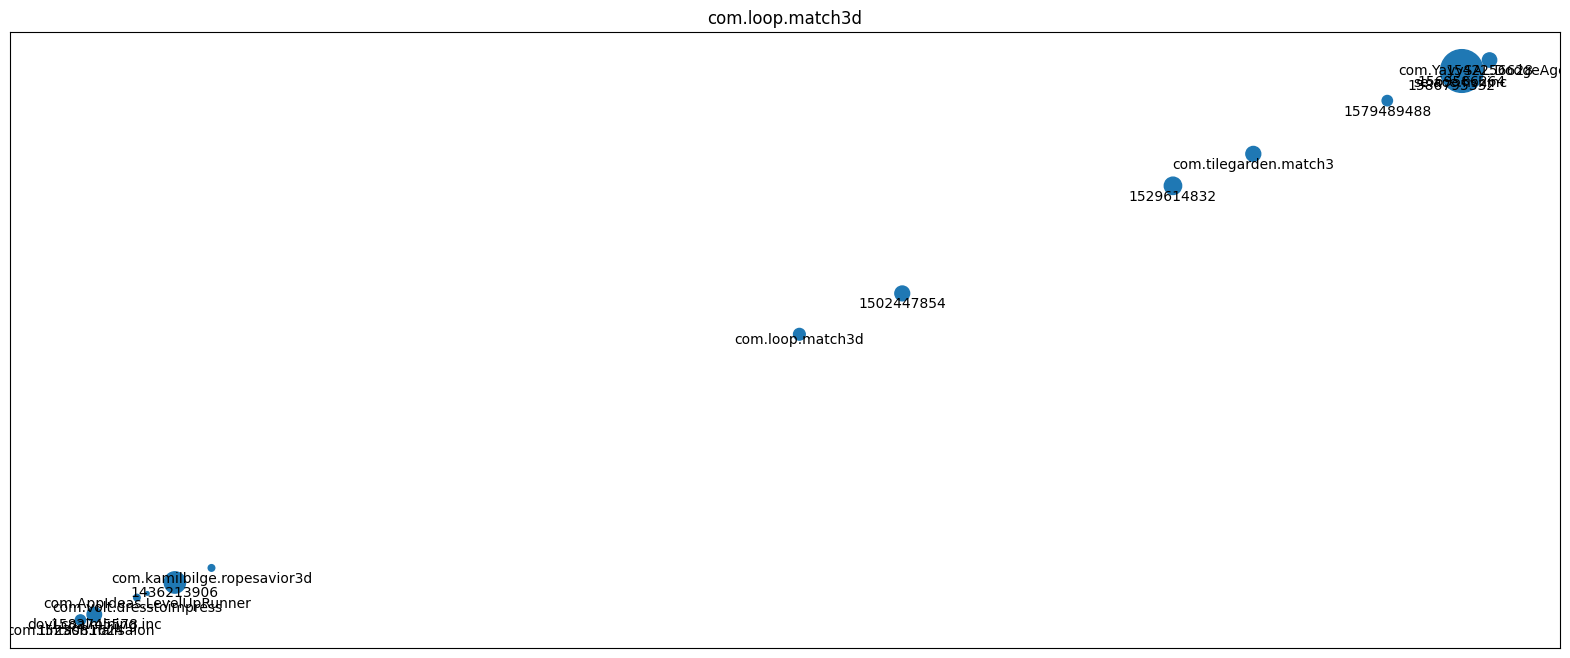

                             avg_price  cosine_similarity
bundleId                                                 
com.loop.match3d              1.420811           0.480975
com.YayySAL.DodgeAgent        0.445529           1.000000
com.tintash.nailsalon         0.300057           0.389171
com.tilegarden.match3         2.297261           0.446939
com.kamilbilge.ropesavior3d   0.451491           0.647838
1529614832                    3.121816           0.444397
1523081624                    1.101837           0.389171
1502447854                    2.269482           0.504298
com.AppIdeas.LevelUpRunner    0.131547           0.589571
se.ace.fishinc                1.831922           0.485706
1436213906                    4.718555           0.510226
1542256628                    2.114797           1.000000
com.volt.dresstoimpress       0.445255           0.437803
1579489488                    1.113208           0.647838
dovi.coalmining.inc           0.593311           0.490686
1586795332    

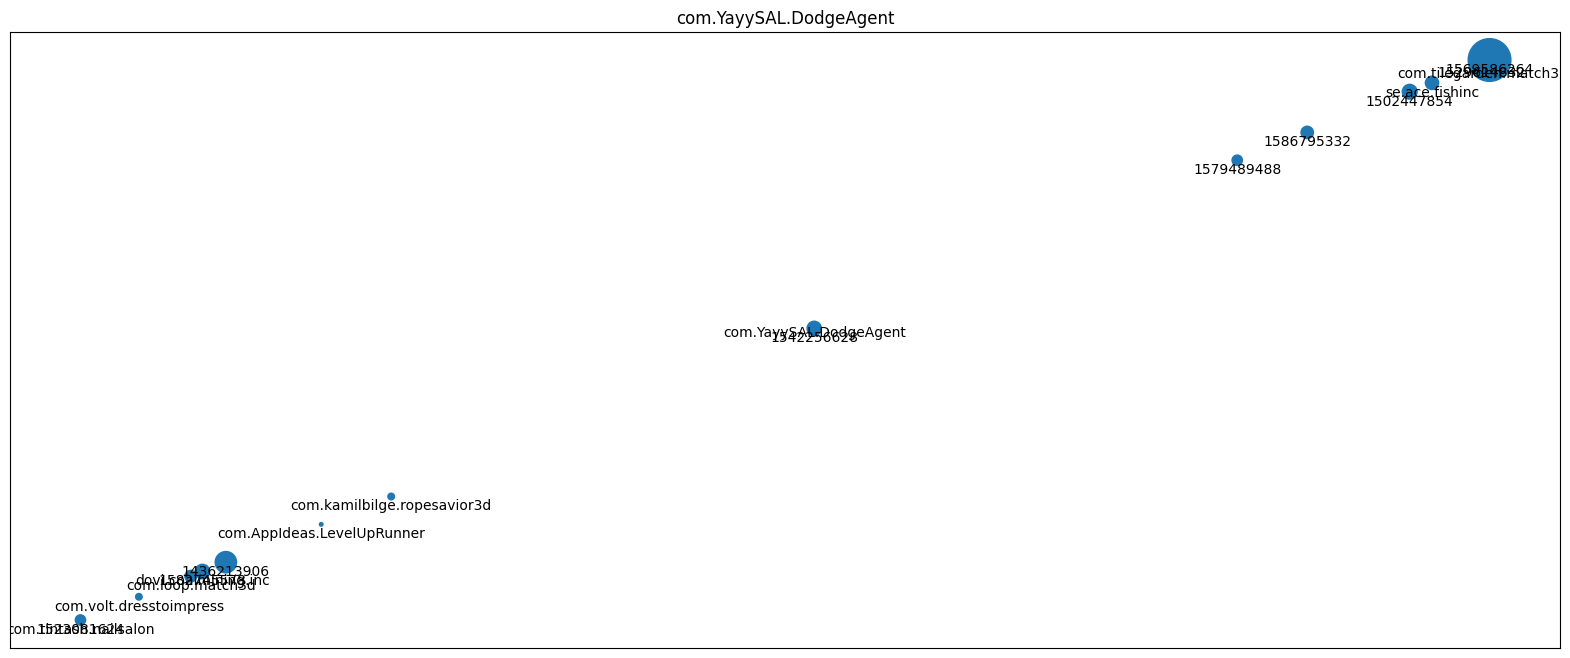

                             avg_price  cosine_similarity
bundleId                                                 
com.loop.match3d              1.420811           0.459344
com.YayySAL.DodgeAgent        0.445529           0.389171
com.tintash.nailsalon         0.300057           1.000000
com.tilegarden.match3         2.297261           0.418847
com.kamilbilge.ropesavior3d   0.451491           0.397408
1529614832                    3.121816           0.397721
1523081624                    1.101837           1.000000
1502447854                    2.269482           0.497849
com.AppIdeas.LevelUpRunner    0.131547           0.454166
se.ace.fishinc                1.831922           0.451082
1436213906                    4.718555           0.478738
1542256628                    2.114797           0.389171
com.volt.dresstoimpress       0.445255           0.504474
1579489488                    1.113208           0.397408
dovi.coalmining.inc           0.593311           0.525149
1586795332    

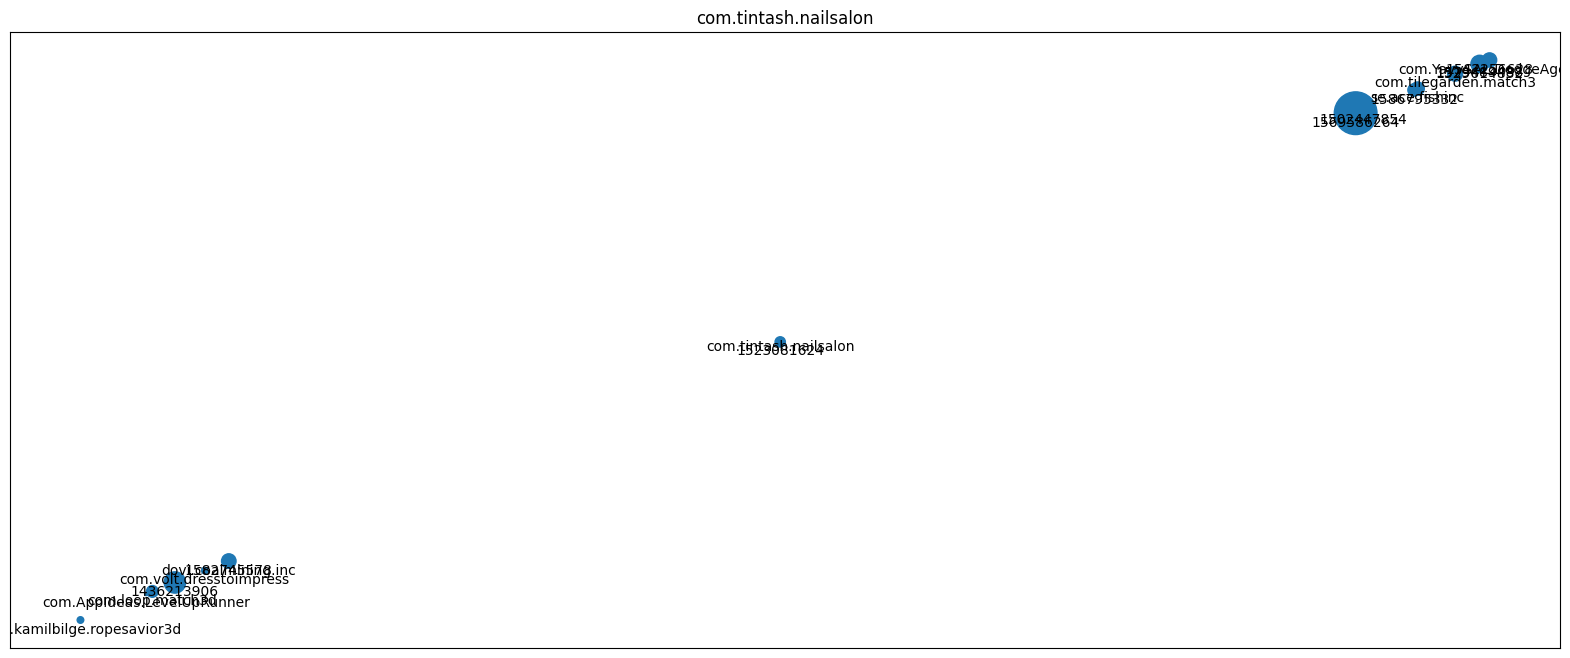

                             avg_price  cosine_similarity
bundleId                                                 
com.loop.match3d              1.420811           0.658637
com.YayySAL.DodgeAgent        0.445529           0.446939
com.tintash.nailsalon         0.300057           0.418847
com.tilegarden.match3         2.297261           1.000000
com.kamilbilge.ropesavior3d   0.451491           0.484870
1529614832                    3.121816           0.858154
1523081624                    1.101837           0.418847
1502447854                    2.269482           0.661645
com.AppIdeas.LevelUpRunner    0.131547           0.407859
se.ace.fishinc                1.831922           0.478936
1436213906                    4.718555           0.480558
1542256628                    2.114797           0.446939
com.volt.dresstoimpress       0.445255           0.462467
1579489488                    1.113208           0.484870
dovi.coalmining.inc           0.593311           0.444795
1586795332    

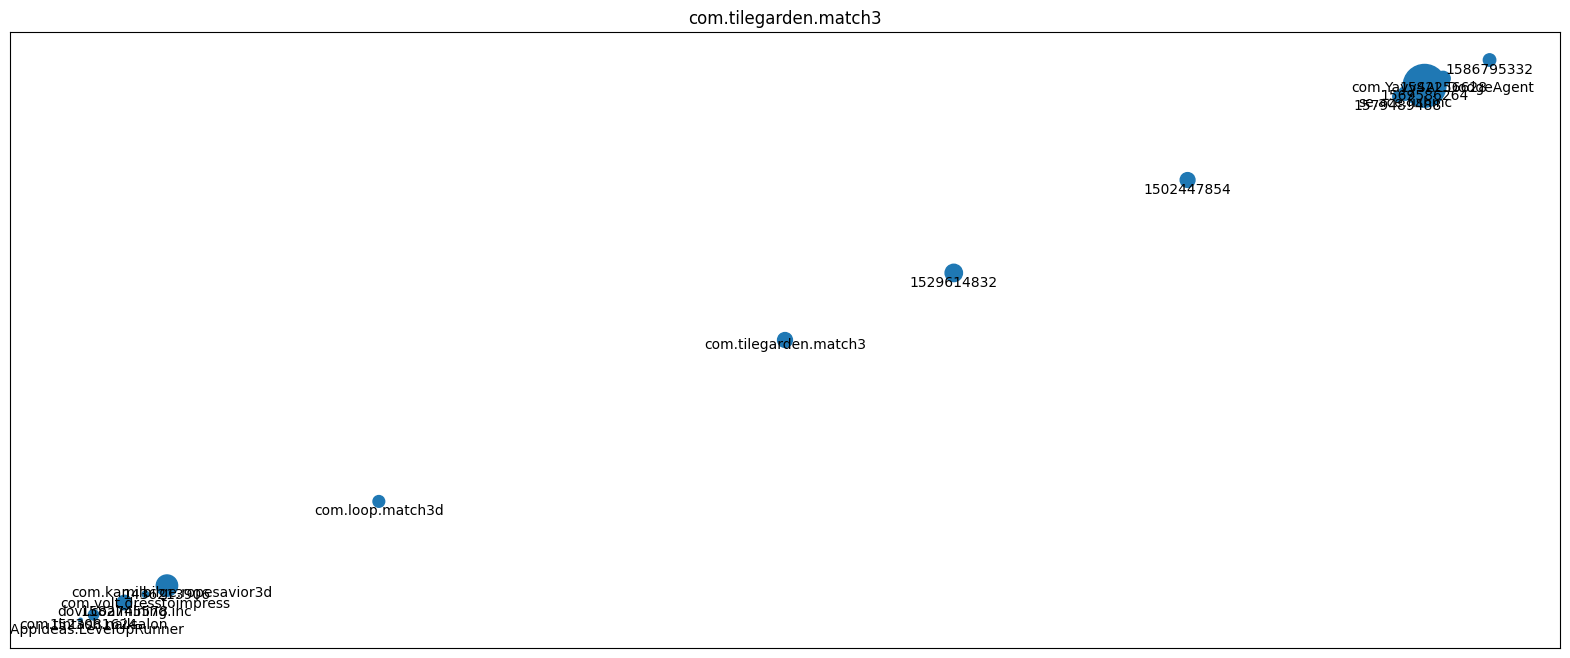

                             avg_price  cosine_similarity
bundleId                                                 
com.loop.match3d              1.420811           0.557880
com.YayySAL.DodgeAgent        0.445529           0.647838
com.tintash.nailsalon         0.300057           0.397408
com.tilegarden.match3         2.297261           0.484870
com.kamilbilge.ropesavior3d   0.451491           1.000000
1529614832                    3.121816           0.510735
1523081624                    1.101837           0.397408
1502447854                    2.269482           0.589520
com.AppIdeas.LevelUpRunner    0.131547           0.590973
se.ace.fishinc                1.831922           0.472770
1436213906                    4.718555           0.498040
1542256628                    2.114797           0.647838
com.volt.dresstoimpress       0.445255           0.445463
1579489488                    1.113208           1.000000
dovi.coalmining.inc           0.593311           0.511413
1586795332    

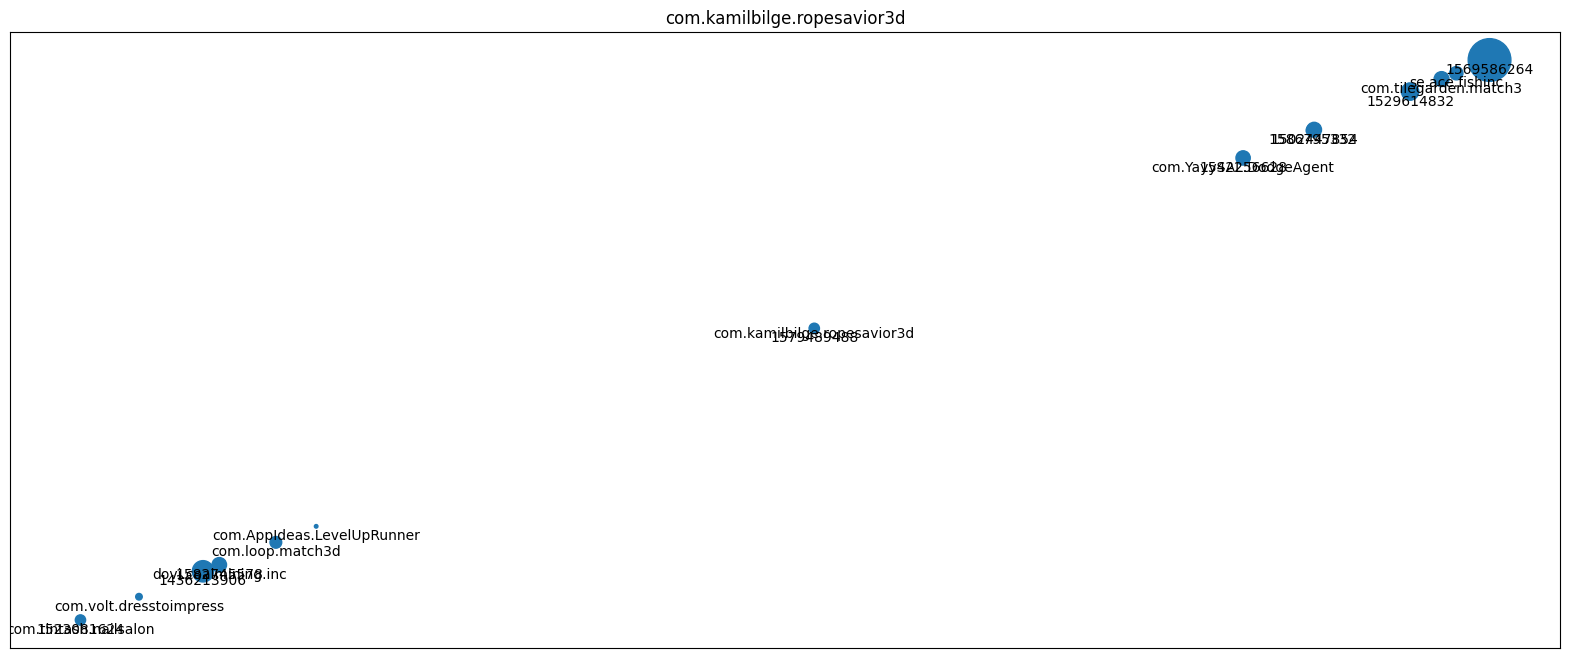

                             avg_price  cosine_similarity
bundleId                                                 
com.loop.match3d              1.420811           0.719058
com.YayySAL.DodgeAgent        0.445529           0.444397
com.tintash.nailsalon         0.300057           0.397721
com.tilegarden.match3         2.297261           0.858154
com.kamilbilge.ropesavior3d   0.451491           0.510735
1529614832                    3.121816           1.000000
1523081624                    1.101837           0.397721
1502447854                    2.269482           0.742816
com.AppIdeas.LevelUpRunner    0.131547           0.434522
se.ace.fishinc                1.831922           0.422223
1436213906                    4.718555           0.431569
1542256628                    2.114797           0.444397
com.volt.dresstoimpress       0.445255           0.472777
1579489488                    1.113208           0.510735
dovi.coalmining.inc           0.593311           0.408701
1586795332    

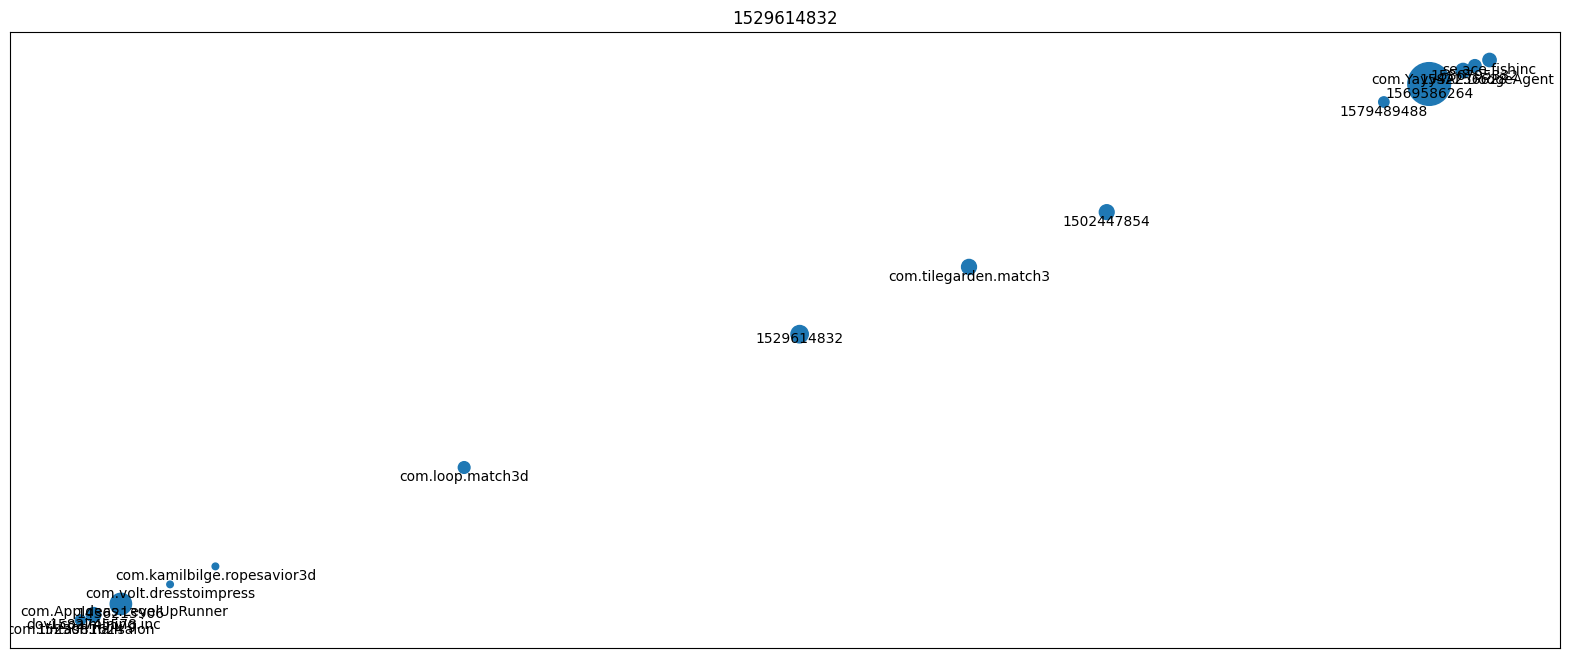

                             avg_price  cosine_similarity
bundleId                                                 
com.loop.match3d              1.420811           0.459344
com.YayySAL.DodgeAgent        0.445529           0.389171
com.tintash.nailsalon         0.300057           1.000000
com.tilegarden.match3         2.297261           0.418847
com.kamilbilge.ropesavior3d   0.451491           0.397408
1529614832                    3.121816           0.397721
1523081624                    1.101837           1.000000
1502447854                    2.269482           0.497849
com.AppIdeas.LevelUpRunner    0.131547           0.454166
se.ace.fishinc                1.831922           0.451082
1436213906                    4.718555           0.478738
1542256628                    2.114797           0.389171
com.volt.dresstoimpress       0.445255           0.504474
1579489488                    1.113208           0.397408
dovi.coalmining.inc           0.593311           0.525149
1586795332    

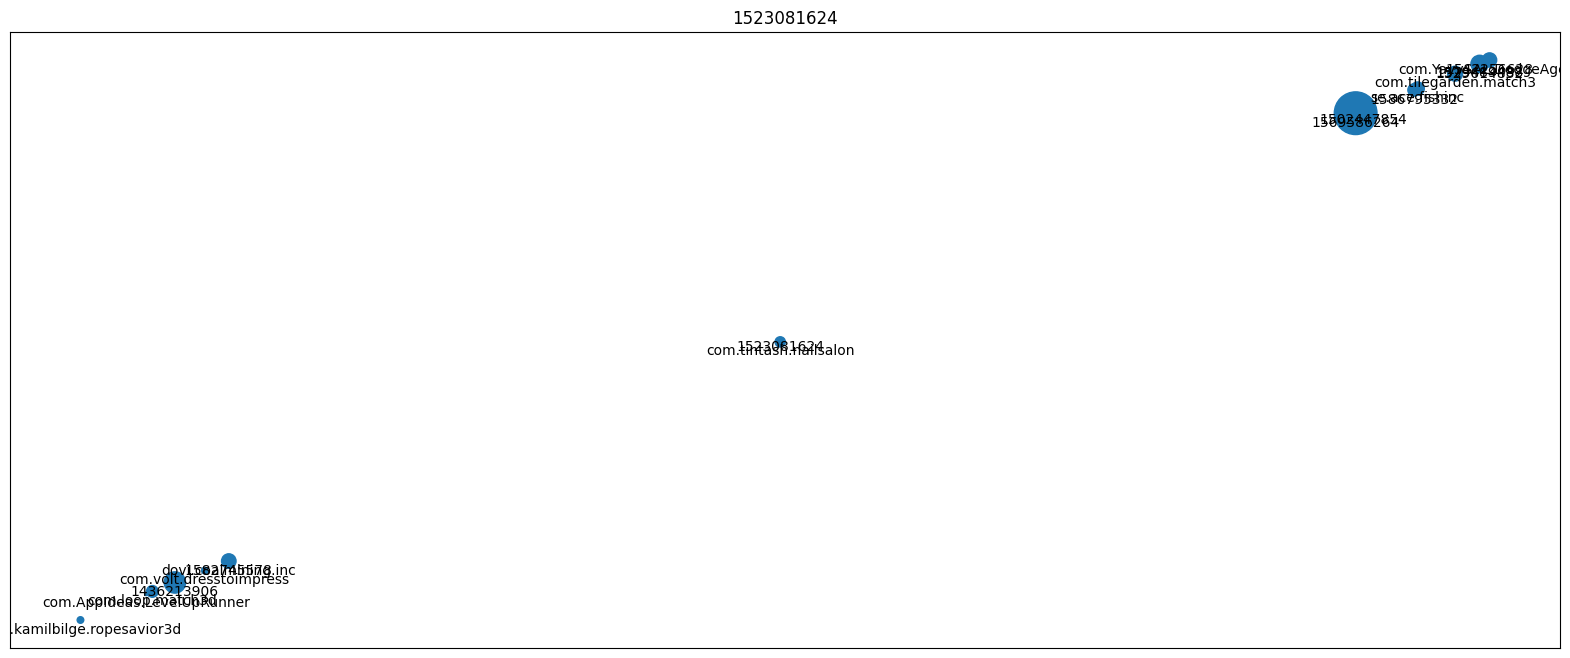

                             avg_price  cosine_similarity
bundleId                                                 
com.loop.match3d              1.420811           0.922637
com.YayySAL.DodgeAgent        0.445529           0.504298
com.tintash.nailsalon         0.300057           0.497849
com.tilegarden.match3         2.297261           0.661645
com.kamilbilge.ropesavior3d   0.451491           0.589520
1529614832                    3.121816           0.742816
1523081624                    1.101837           0.497849
1502447854                    2.269482           1.000000
com.AppIdeas.LevelUpRunner    0.131547           0.521311
se.ace.fishinc                1.831922           0.519569
1436213906                    4.718555           0.550381
1542256628                    2.114797           0.504298
com.volt.dresstoimpress       0.445255           0.532882
1579489488                    1.113208           0.589520
dovi.coalmining.inc           0.593311           0.490862
1586795332    

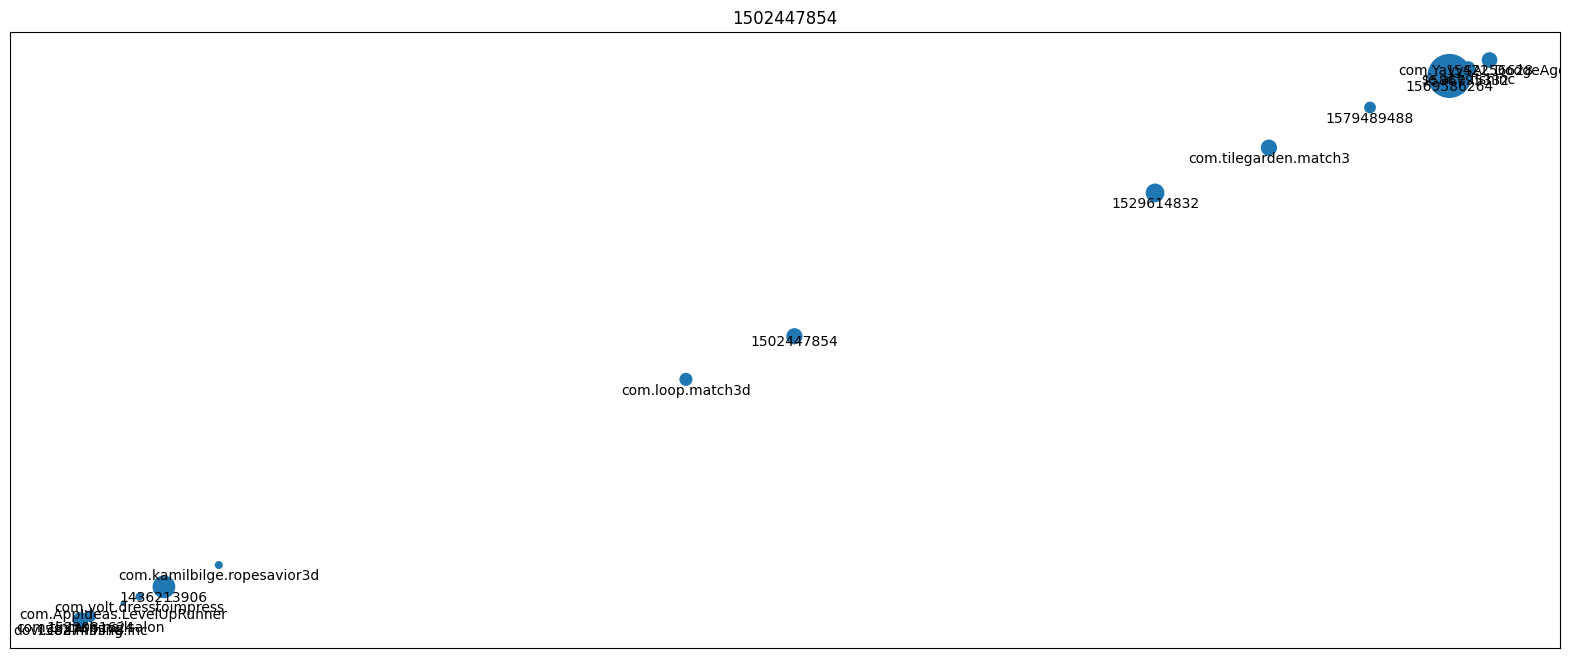

                             avg_price  cosine_similarity
bundleId                                                 
com.loop.match3d              1.420811           0.509649
com.YayySAL.DodgeAgent        0.445529           0.589571
com.tintash.nailsalon         0.300057           0.454166
com.tilegarden.match3         2.297261           0.407859
com.kamilbilge.ropesavior3d   0.451491           0.590973
1529614832                    3.121816           0.434522
1523081624                    1.101837           0.454166
1502447854                    2.269482           0.521311
com.AppIdeas.LevelUpRunner    0.131547           1.000000
se.ace.fishinc                1.831922           0.426877
1436213906                    4.718555           0.478761
1542256628                    2.114797           0.589571
com.volt.dresstoimpress       0.445255           0.537237
1579489488                    1.113208           0.590973
dovi.coalmining.inc           0.593311           0.449943
1586795332    

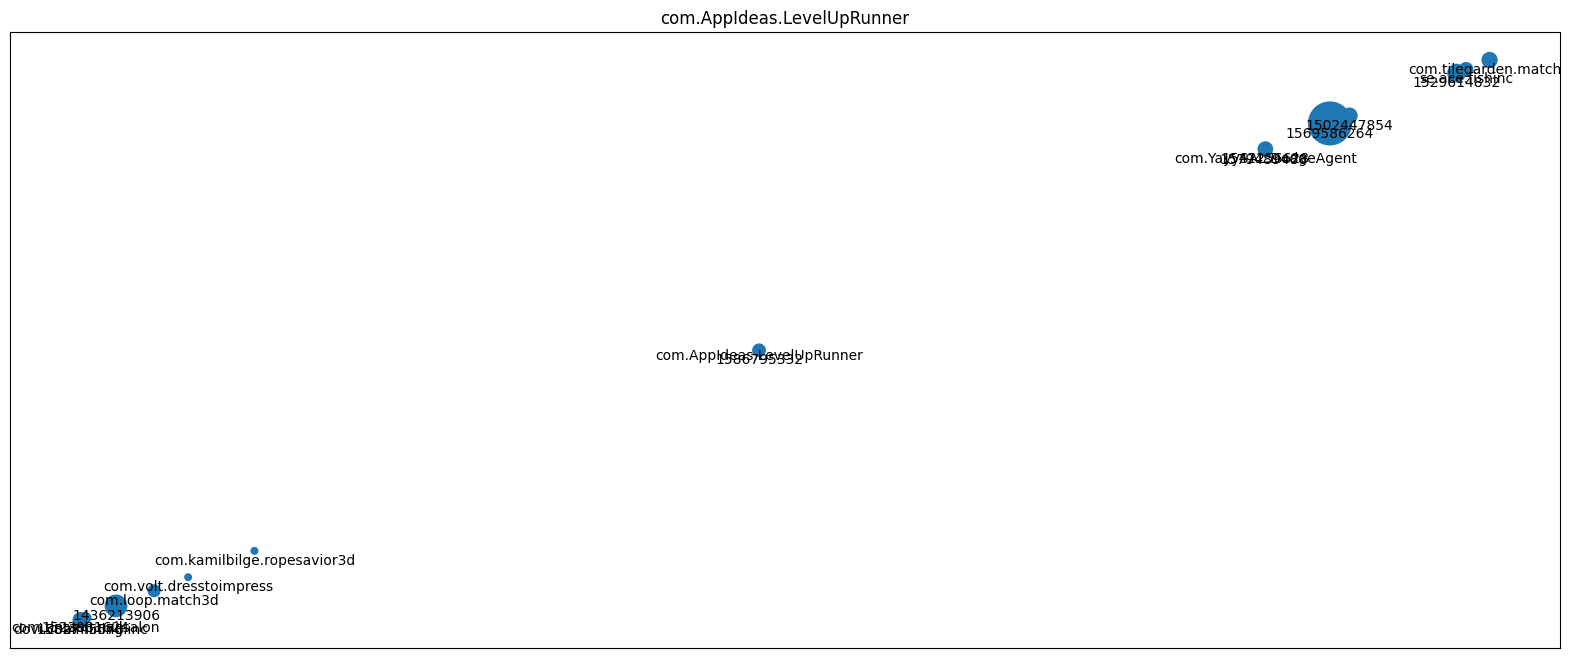

                             avg_price  cosine_similarity
bundleId                                                 
com.loop.match3d              1.420811           0.502924
com.YayySAL.DodgeAgent        0.445529           0.485706
com.tintash.nailsalon         0.300057           0.451082
com.tilegarden.match3         2.297261           0.478936
com.kamilbilge.ropesavior3d   0.451491           0.472770
1529614832                    3.121816           0.422223
1523081624                    1.101837           0.451082
1502447854                    2.269482           0.519569
com.AppIdeas.LevelUpRunner    0.131547           0.426877
se.ace.fishinc                1.831922           1.000000
1436213906                    4.718555           0.956374
1542256628                    2.114797           0.485706
com.volt.dresstoimpress       0.445255           0.403193
1579489488                    1.113208           0.472770
dovi.coalmining.inc           0.593311           0.669928
1586795332    

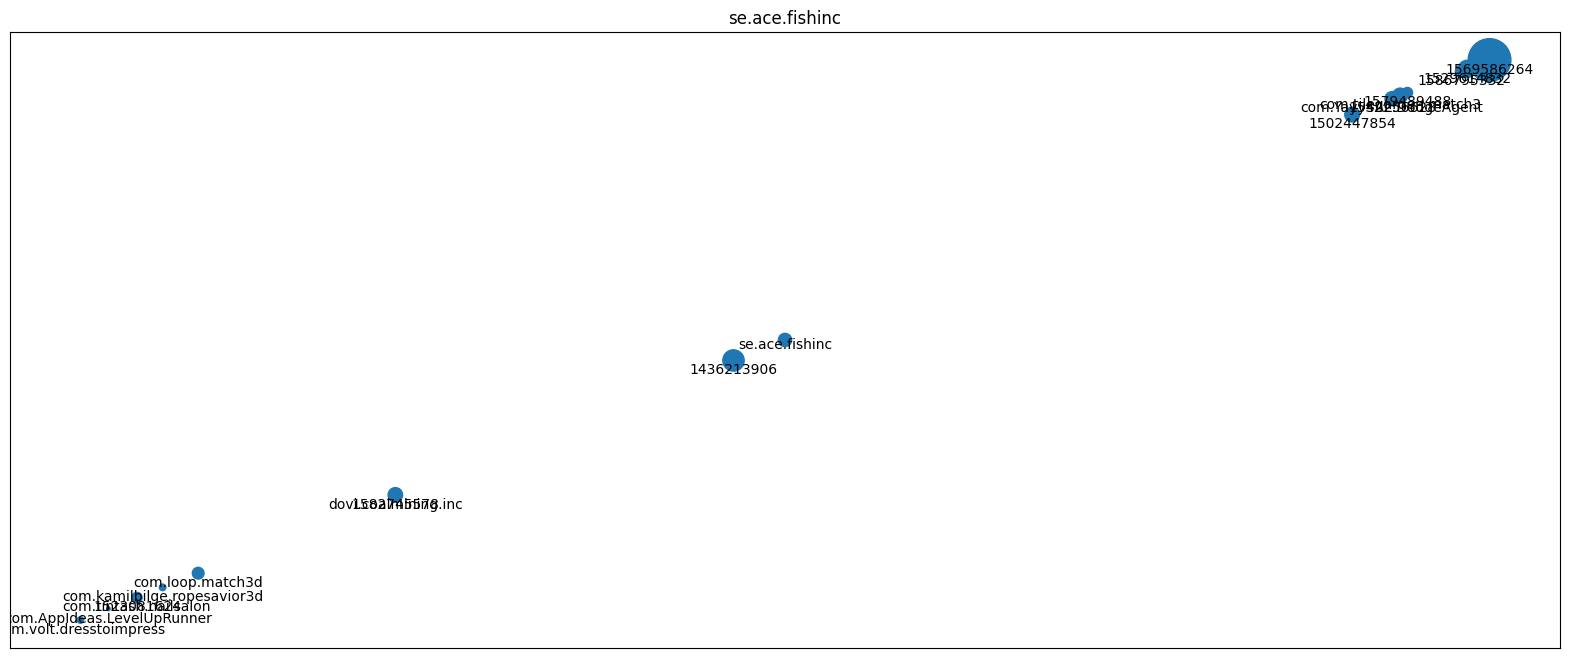

                             avg_price  cosine_similarity
bundleId                                                 
com.loop.match3d              1.420811           0.530372
com.YayySAL.DodgeAgent        0.445529           0.510226
com.tintash.nailsalon         0.300057           0.478738
com.tilegarden.match3         2.297261           0.480558
com.kamilbilge.ropesavior3d   0.451491           0.498040
1529614832                    3.121816           0.431569
1523081624                    1.101837           0.478738
1502447854                    2.269482           0.550381
com.AppIdeas.LevelUpRunner    0.131547           0.478761
se.ace.fishinc                1.831922           0.956374
1436213906                    4.718555           1.000000
1542256628                    2.114797           0.510226
com.volt.dresstoimpress       0.445255           0.408562
1579489488                    1.113208           0.498040
dovi.coalmining.inc           0.593311           0.676883
1586795332    

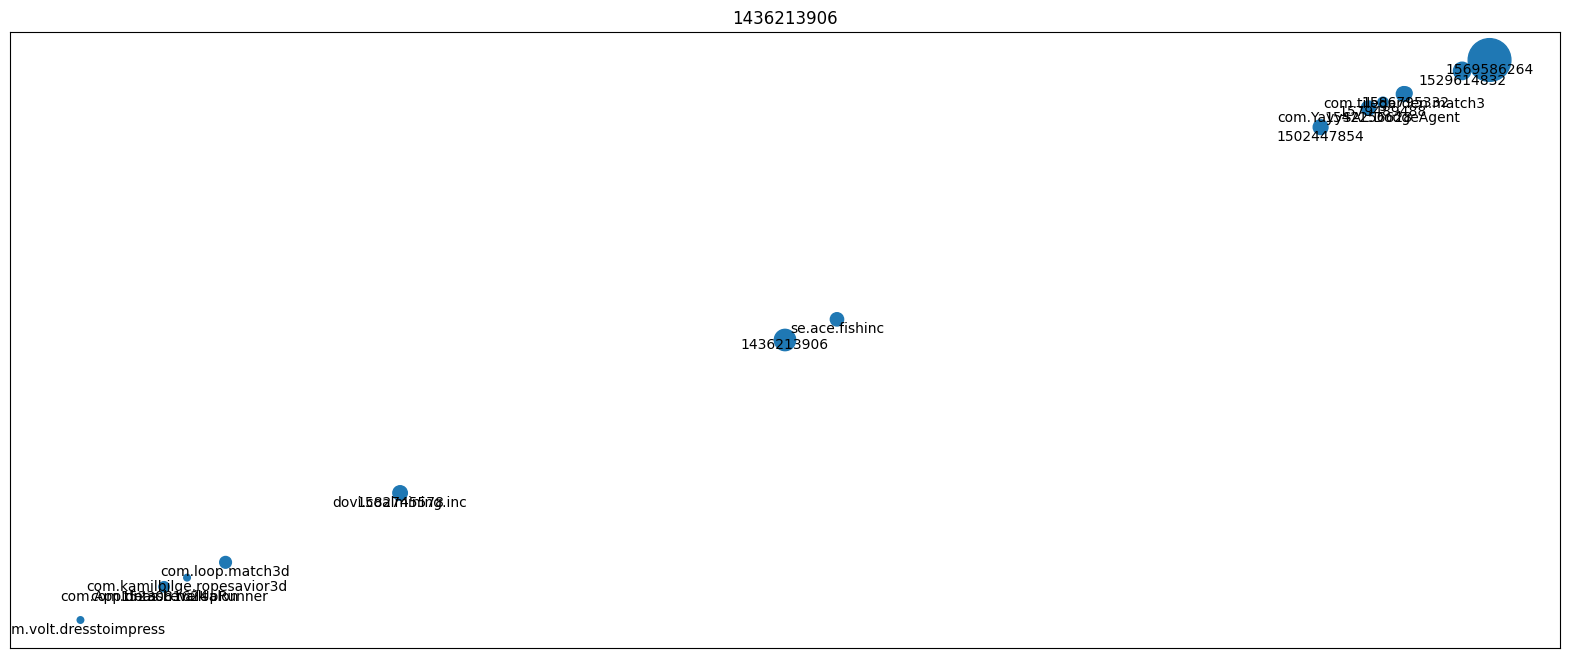

                             avg_price  cosine_similarity
bundleId                                                 
com.loop.match3d              1.420811           0.480975
com.YayySAL.DodgeAgent        0.445529           1.000000
com.tintash.nailsalon         0.300057           0.389171
com.tilegarden.match3         2.297261           0.446939
com.kamilbilge.ropesavior3d   0.451491           0.647838
1529614832                    3.121816           0.444397
1523081624                    1.101837           0.389171
1502447854                    2.269482           0.504298
com.AppIdeas.LevelUpRunner    0.131547           0.589571
se.ace.fishinc                1.831922           0.485706
1436213906                    4.718555           0.510226
1542256628                    2.114797           1.000000
com.volt.dresstoimpress       0.445255           0.437803
1579489488                    1.113208           0.647838
dovi.coalmining.inc           0.593311           0.490686
1586795332    

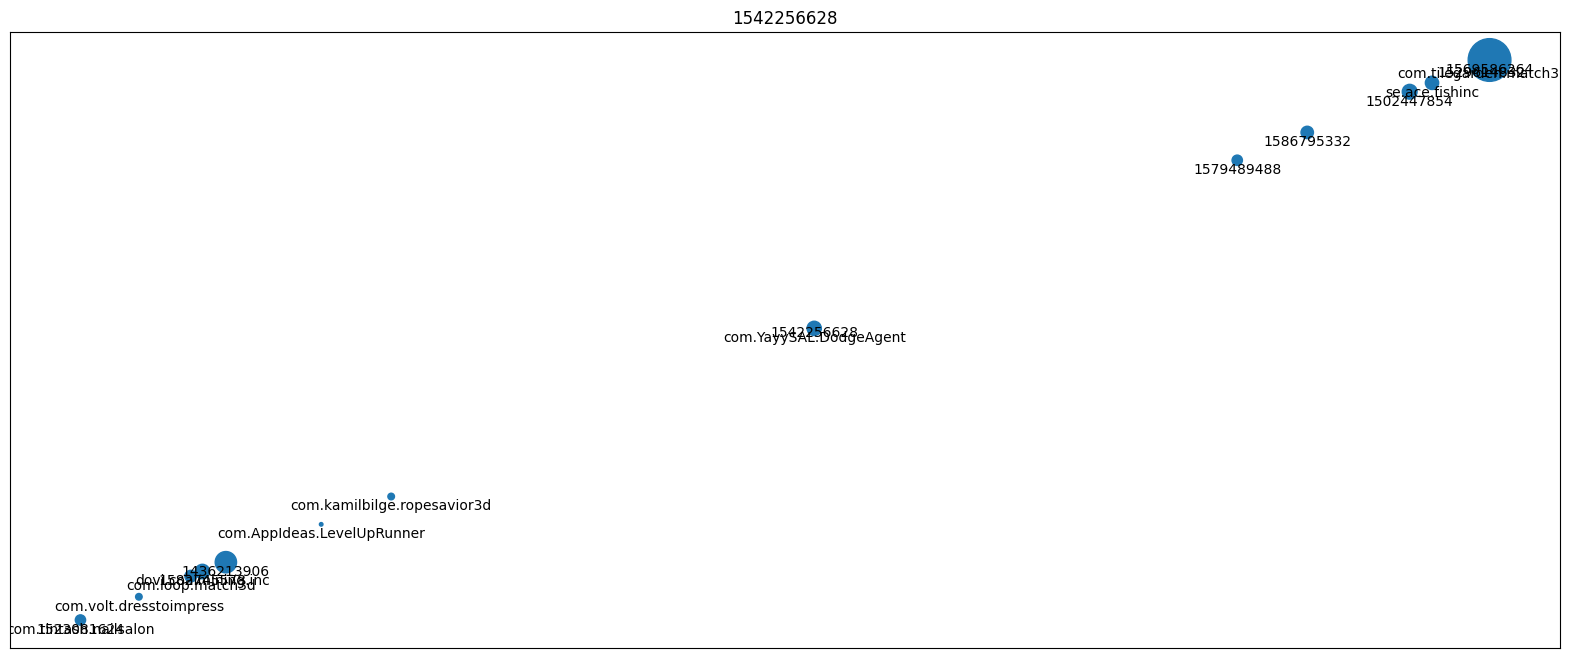

                             avg_price  cosine_similarity
bundleId                                                 
com.loop.match3d              1.420811           0.501801
com.YayySAL.DodgeAgent        0.445529           0.437803
com.tintash.nailsalon         0.300057           0.504474
com.tilegarden.match3         2.297261           0.462467
com.kamilbilge.ropesavior3d   0.451491           0.445463
1529614832                    3.121816           0.472777
1523081624                    1.101837           0.504474
1502447854                    2.269482           0.532882
com.AppIdeas.LevelUpRunner    0.131547           0.537237
se.ace.fishinc                1.831922           0.403193
1436213906                    4.718555           0.408562
1542256628                    2.114797           0.437803
com.volt.dresstoimpress       0.445255           1.000000
1579489488                    1.113208           0.445463
dovi.coalmining.inc           0.593311           0.377867
1586795332    

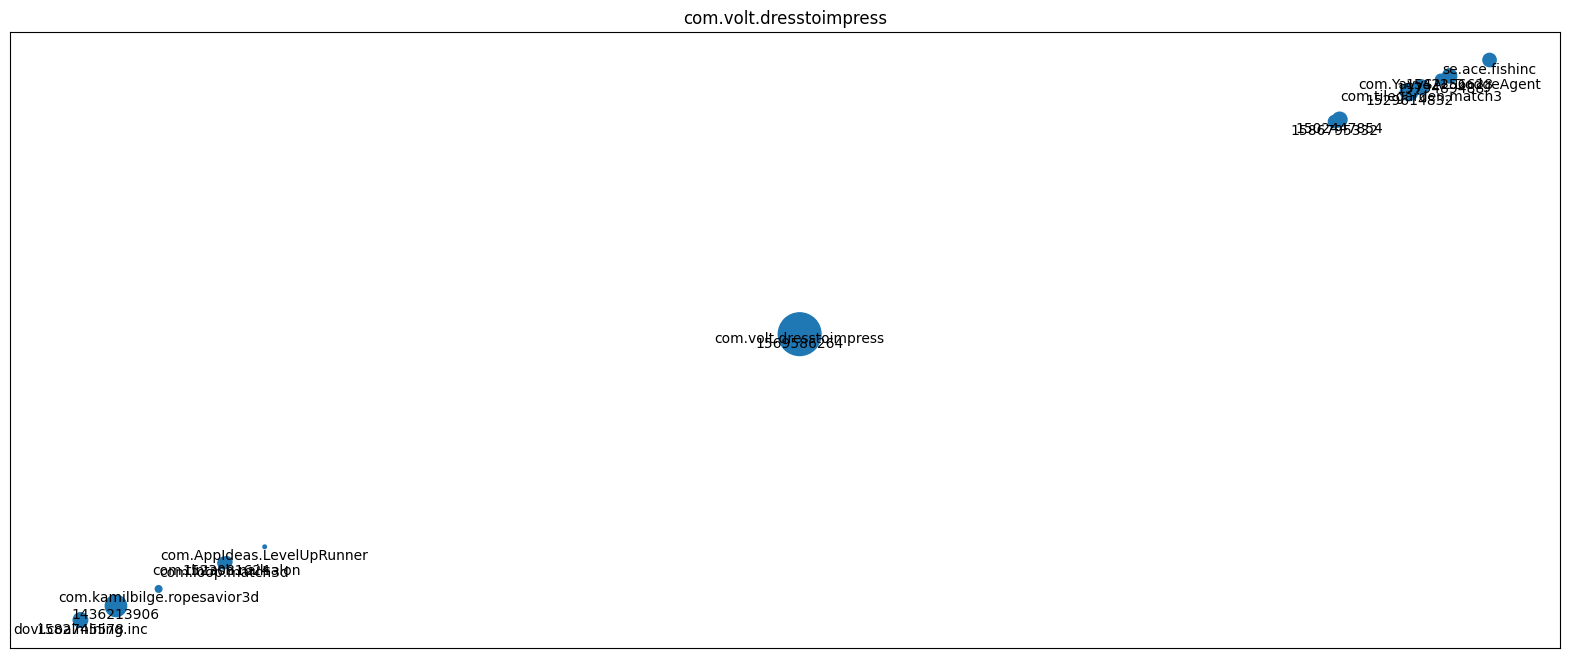

                             avg_price  cosine_similarity
bundleId                                                 
com.loop.match3d              1.420811           0.557880
com.YayySAL.DodgeAgent        0.445529           0.647838
com.tintash.nailsalon         0.300057           0.397408
com.tilegarden.match3         2.297261           0.484870
com.kamilbilge.ropesavior3d   0.451491           1.000000
1529614832                    3.121816           0.510735
1523081624                    1.101837           0.397408
1502447854                    2.269482           0.589520
com.AppIdeas.LevelUpRunner    0.131547           0.590973
se.ace.fishinc                1.831922           0.472770
1436213906                    4.718555           0.498040
1542256628                    2.114797           0.647838
com.volt.dresstoimpress       0.445255           0.445463
1579489488                    1.113208           1.000000
dovi.coalmining.inc           0.593311           0.511413
1586795332    

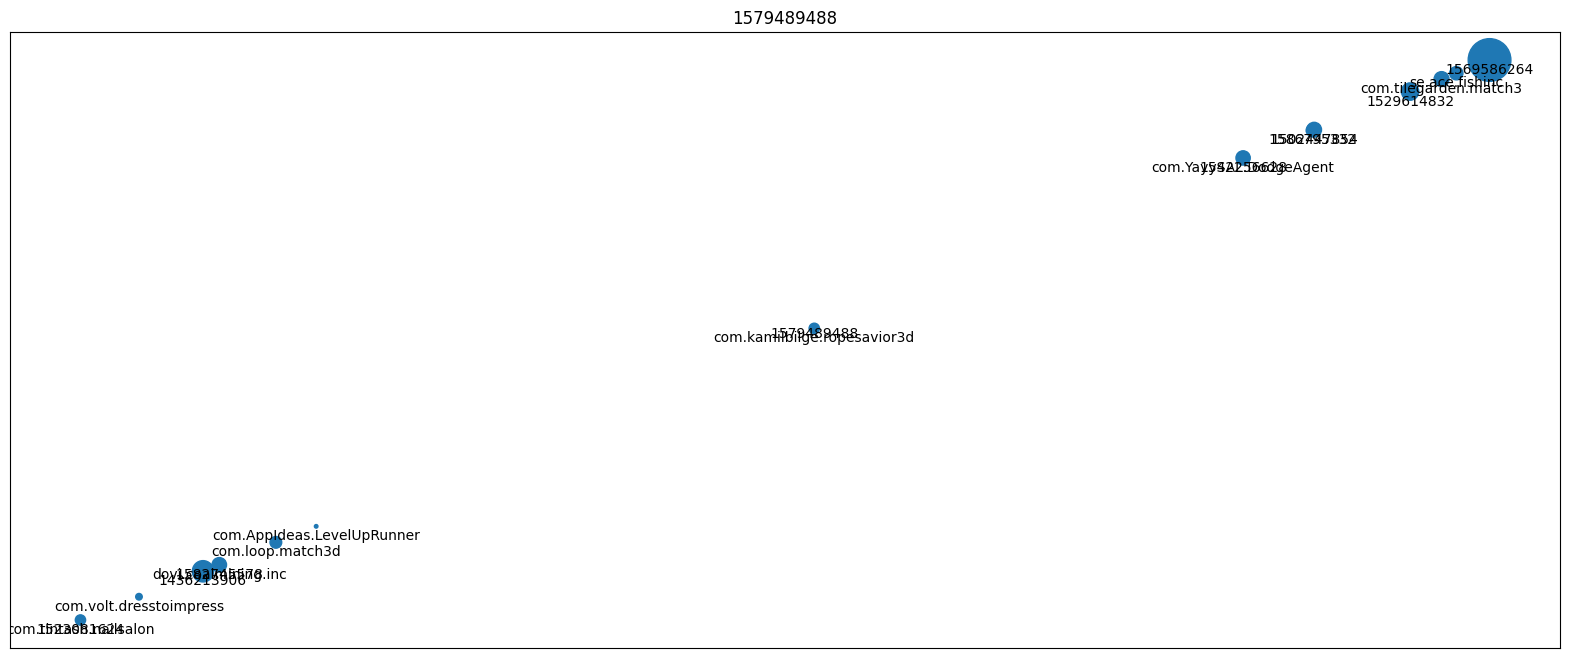

                             avg_price  cosine_similarity
bundleId                                                 
com.loop.match3d              1.420811           0.469741
com.YayySAL.DodgeAgent        0.445529           0.490686
com.tintash.nailsalon         0.300057           0.525149
com.tilegarden.match3         2.297261           0.444795
com.kamilbilge.ropesavior3d   0.451491           0.511413
1529614832                    3.121816           0.408701
1523081624                    1.101837           0.525149
1502447854                    2.269482           0.490862
com.AppIdeas.LevelUpRunner    0.131547           0.449943
se.ace.fishinc                1.831922           0.669928
1436213906                    4.718555           0.676883
1542256628                    2.114797           0.490686
com.volt.dresstoimpress       0.445255           0.377867
1579489488                    1.113208           0.511413
dovi.coalmining.inc           0.593311           1.000000
1586795332    

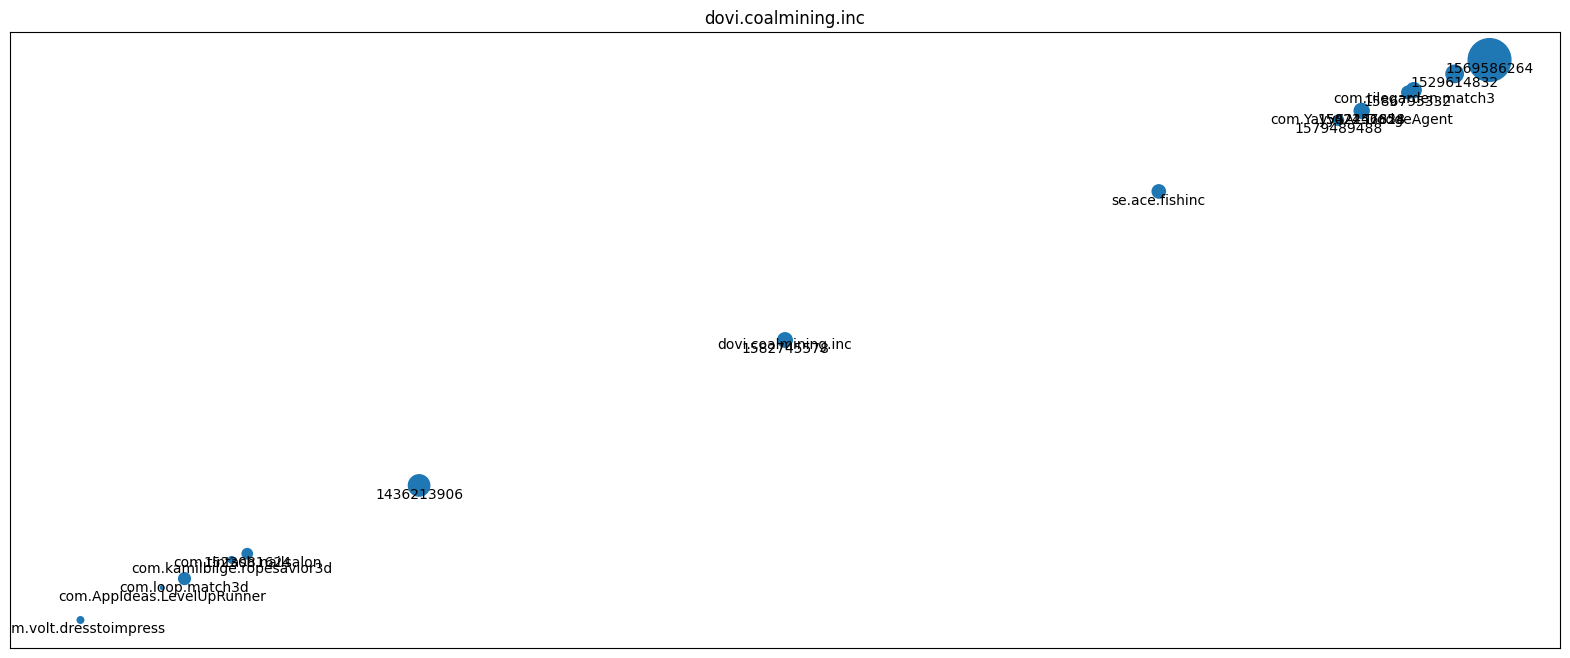

                             avg_price  cosine_similarity
bundleId                                                 
com.loop.match3d              1.420811           0.509649
com.YayySAL.DodgeAgent        0.445529           0.589571
com.tintash.nailsalon         0.300057           0.454166
com.tilegarden.match3         2.297261           0.407859
com.kamilbilge.ropesavior3d   0.451491           0.590973
1529614832                    3.121816           0.434522
1523081624                    1.101837           0.454166
1502447854                    2.269482           0.521311
com.AppIdeas.LevelUpRunner    0.131547           1.000000
se.ace.fishinc                1.831922           0.426877
1436213906                    4.718555           0.478761
1542256628                    2.114797           0.589571
com.volt.dresstoimpress       0.445255           0.537237
1579489488                    1.113208           0.590973
dovi.coalmining.inc           0.593311           0.449943
1586795332    

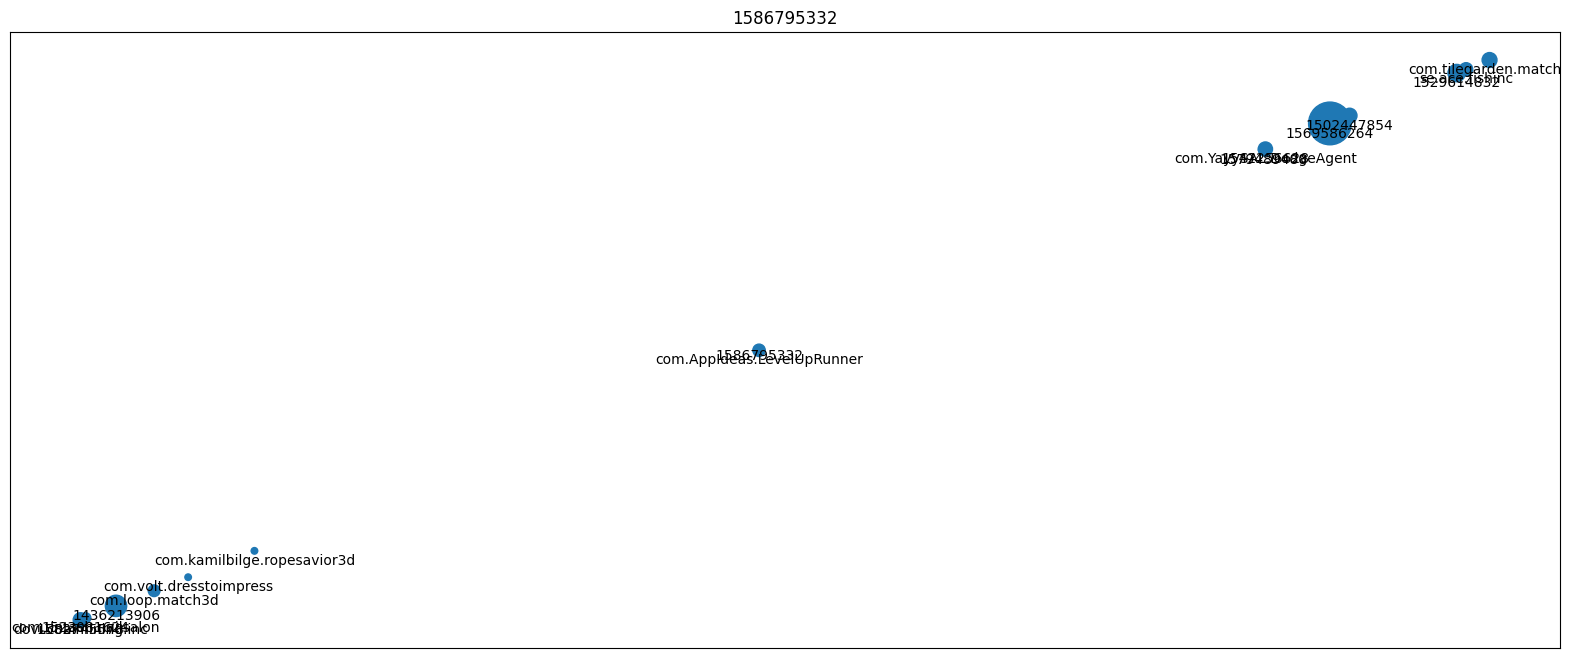

                             avg_price  cosine_similarity
bundleId                                                 
com.loop.match3d              1.420811           0.469741
com.YayySAL.DodgeAgent        0.445529           0.490686
com.tintash.nailsalon         0.300057           0.525150
com.tilegarden.match3         2.297261           0.444795
com.kamilbilge.ropesavior3d   0.451491           0.511413
1529614832                    3.121816           0.408701
1523081624                    1.101837           0.525150
1502447854                    2.269482           0.490862
com.AppIdeas.LevelUpRunner    0.131547           0.449943
se.ace.fishinc                1.831922           0.669928
1436213906                    4.718555           0.676883
1542256628                    2.114797           0.490686
com.volt.dresstoimpress       0.445255           0.377867
1579489488                    1.113208           0.511413
dovi.coalmining.inc           0.593311           1.000000
1586795332    

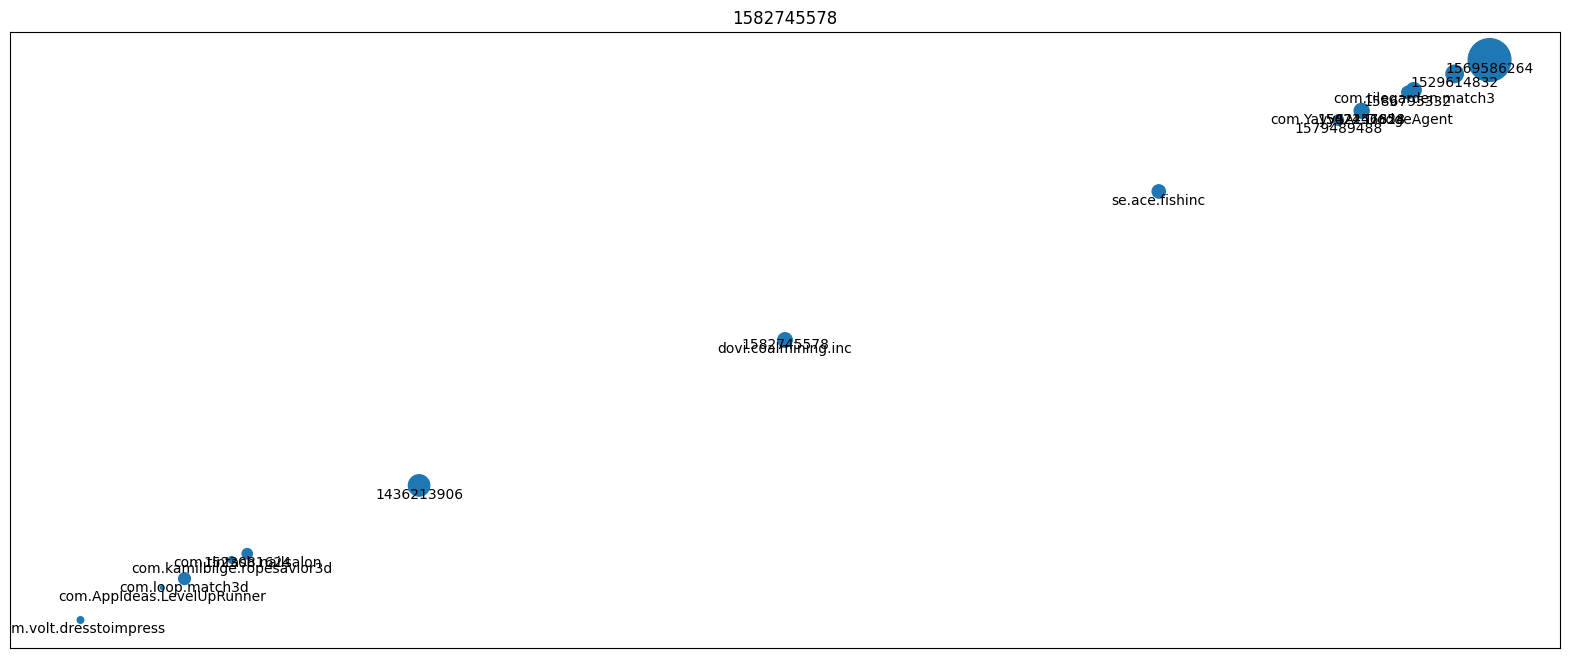

                             avg_price  cosine_similarity
bundleId                                                 
com.loop.match3d              1.420811           0.501801
com.YayySAL.DodgeAgent        0.445529           0.437803
com.tintash.nailsalon         0.300057           0.504474
com.tilegarden.match3         2.297261           0.462467
com.kamilbilge.ropesavior3d   0.451491           0.445463
1529614832                    3.121816           0.472777
1523081624                    1.101837           0.504474
1502447854                    2.269482           0.532882
com.AppIdeas.LevelUpRunner    0.131547           0.537237
se.ace.fishinc                1.831922           0.403193
1436213906                    4.718555           0.408562
1542256628                    2.114797           0.437803
com.volt.dresstoimpress       0.445255           1.000000
1579489488                    1.113208           0.445463
dovi.coalmining.inc           0.593311           0.377867
1586795332    

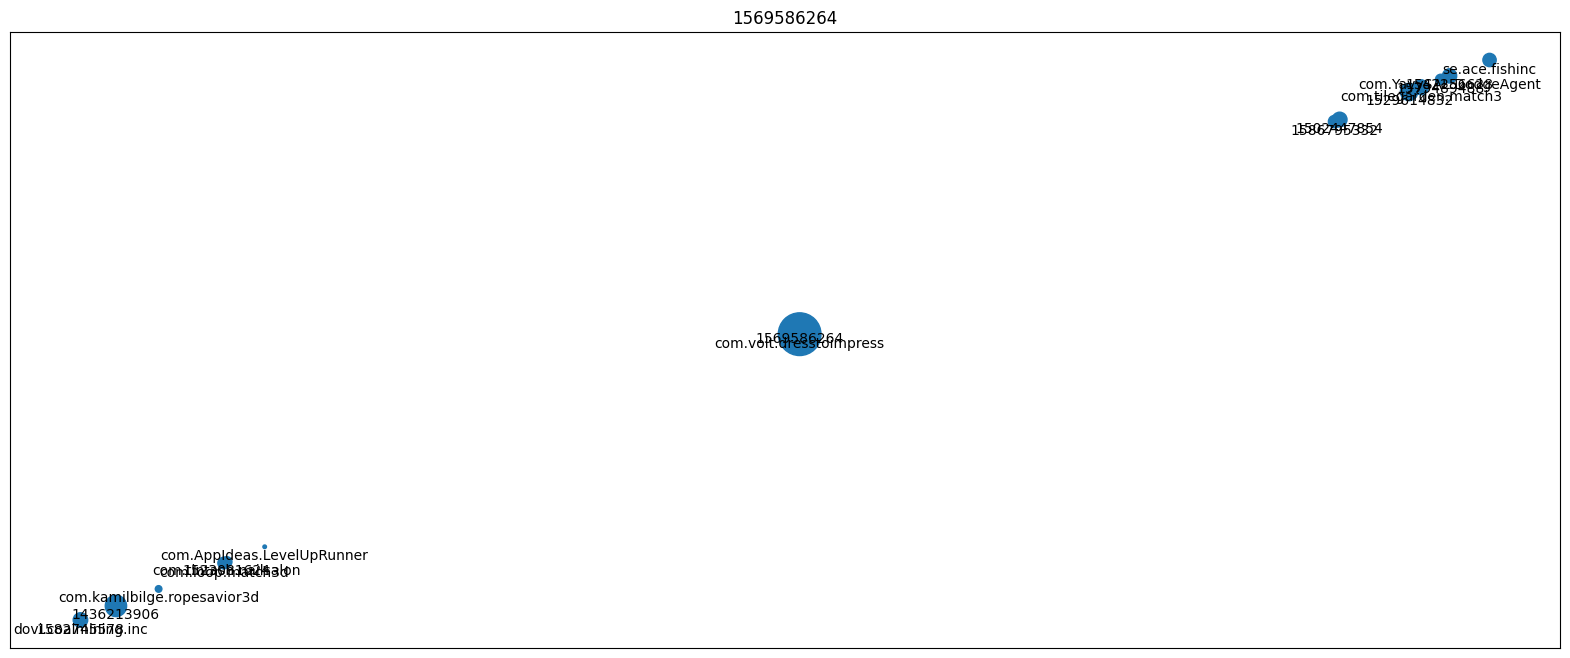

In [20]:
def query_cosine_sim(vec):
   '''gets app's vec embedding to check cosine similarity ''' 
   
   sql_query = f'''
               SELECT 1 - (embedding<=>'{json.dumps(vec)}')  AS cosine_similarity,"bundleId" FROM app_vectors 
                '''  #WHERE (1 - (embedding<=>'{json.dumps(vec)}'))>0.6

   with engine.connect() as db_con:
       df = pd.read_sql(sql_query, con=db_con)
   return df

def app_avg_price(df_auc):
   df = pd.DataFrame()
   avg_price = []
   for bid in df_auc.bundleId.unique():
      avg_price.append(np.mean(df_auc[df_auc.bundleId ==bid]["sentPrice"]))
   df["bundleId"] = df_auc.bundleId.unique()
   df["avg_price"] = avg_price
   return df

def buildGraph(app_list,df_degree):
    G = nx.Graph()
    node_size = {}
    #Create nodes
    for i in app_list:
      G.add_node(i, size=df_degree[df_degree.bundleId==i]["avg_price"].values[0])
      node_size[i] = df_degree[df_degree.bundleId==i]["avg_price"].values[0]
    return G, node_size

def node_position(G, i, app_list, df_cosin):
    node_pos = {}
    label_pos = {}
    for o,app in enumerate(app_list):
        if app == app_list[i]:
           node_pos[app] = (0.5, 0.5)# by default, networkx plots on a canvas with the origin at (0, 0) and a width and height of 1; (0.5, 0.5) is hence the center
           label_pos[app] = (0.5, 0.49)
        else:
          m = [1 if o%2 else -1]
          x = m[0]*(1 - df_cosin[df_cosin.bundleId == app]["cosine_similarity"].values[0]) #random.choice([1,-1])*
          y = x #random.choice([1,-1])*
          node_pos[app] = (0.5+x, 0.5+y)
          label_pos[app] = ((0.5+x), (0.48+y))
    return node_pos,label_pos
    
def plot_Graph(G,node_pos,node_size,label_pos,i,title):
    fig, ax = plt.subplots(figsize=(20,8))
    ax.set_title(title)
    nx.draw_networkx(G, pos = node_pos, node_size=[50*node_size[node] for node in G], with_labels=False)   # default nodes and edges  node_size=G.size,
    nx.draw_networkx_labels(G, pos=label_pos, font_size=10)     
    plt.show()
    

def main(df_auc,df_app):
    app_list = df_auc.bundleId.unique()
    G, node_size = buildGraph(app_list,app_avg_price(df_auc))
    n = len(app_list)
    for i in range(n):
        ix =df_app[df_app.bundleId==app_list[i]].index.values[0]
        vec = json.loads(df_app.embedding[ix])
        df_cos = query_cosine_sim(vec)
        result =app_avg_price(df_auc).set_index('bundleId').join(df_cos[df_cos.bundleId.isin(app_list)].set_index('bundleId'))
        print(result)
        node_pos,label_pos = node_position(G, i, app_list, df_cos)
        title = app_list[i]
        plot_Graph(G,node_pos,node_size,label_pos,i, title)
    plt.show()

main(df_auc,df_app)

#  Exploring diffrent combinations of features

When considering advertising we need to understand who is the targeted audiance of the company, and also what is each company main focus. Maybe the company is focusing on larger countrys or on people with iphone assuming they are more willing to spend money or have more money to spend, also maybe the company has a special insentive to advertise at some point in time and willing to pay more , creating an outliers in the data.

As shown in the first figure com.loop.match3d is very similar to 1502447854 with high cosine similarity (0.92) but one is running on Android and the other on iOS therefor they are not competators (all the apps with numbers as names run on iOS and the rest on Android). Another conclusion is when looking on the numbers (in the graph we loos this insight) there are some apps with perfect similarity but vert diffrent prices.

Also we need to compare oranges to oranges seperate by unitDisplayType because it is affecting the sent price. for example com.AppIdeas.LevelUpRunner only advertise on banners which has a significantly lower sent price and that is why it appears as such a small dot in the graph.

And remove the outliers : use only 99% of the data (the filtered data from the EDA above)

let see how it is affecting our graph analysis now


In [21]:
unit_list = df_filtered["unitDisplayType"].unique()
os_list = df_filtered["os"].unique()

df_f_rewarded_Android = df_filtered[(df_filtered.unitDisplayType == 'rewarded') & (df_filtered.os == 'Android')]
df_f_rewarded_iOS = df_filtered[(df_filtered.unitDisplayType == 'rewarded') & (df_filtered.os == 'iOS')]
df_f_interstitial_Android =  df_filtered[(df_filtered.unitDisplayType == 'interstitial') & (df_filtered.os == 'Android')]
df_f_interstitial_iOS =  df_filtered[(df_filtered.unitDisplayType == 'interstitial') & (df_filtered.os == 'iOS')]
df_f_banner_Android = df_filtered[(df_filtered.unitDisplayType == 'banner') & (df_filtered.os == 'Android')]
df_f_banner_iOS = df_filtered[(df_filtered.unitDisplayType == 'banner') & (df_filtered.os == 'iOS')]


# 1. UnitDisplayType: rewarded; Operating System: Android

                             avg_price  cosine_similarity
bundleId                                                 
com.loop.match3d              2.059349           1.000000
com.kamilbilge.ropesavior3d   0.909099           0.557880
com.tilegarden.match3         2.765650           0.658637
com.tintash.nailsalon         0.834757           0.459344
se.ace.fishinc                1.677101           0.502924
dovi.coalmining.inc           0.587672           0.469741
com.YayySAL.DodgeAgent        0.910698           0.480975
com.volt.dresstoimpress       0.780055           0.501801


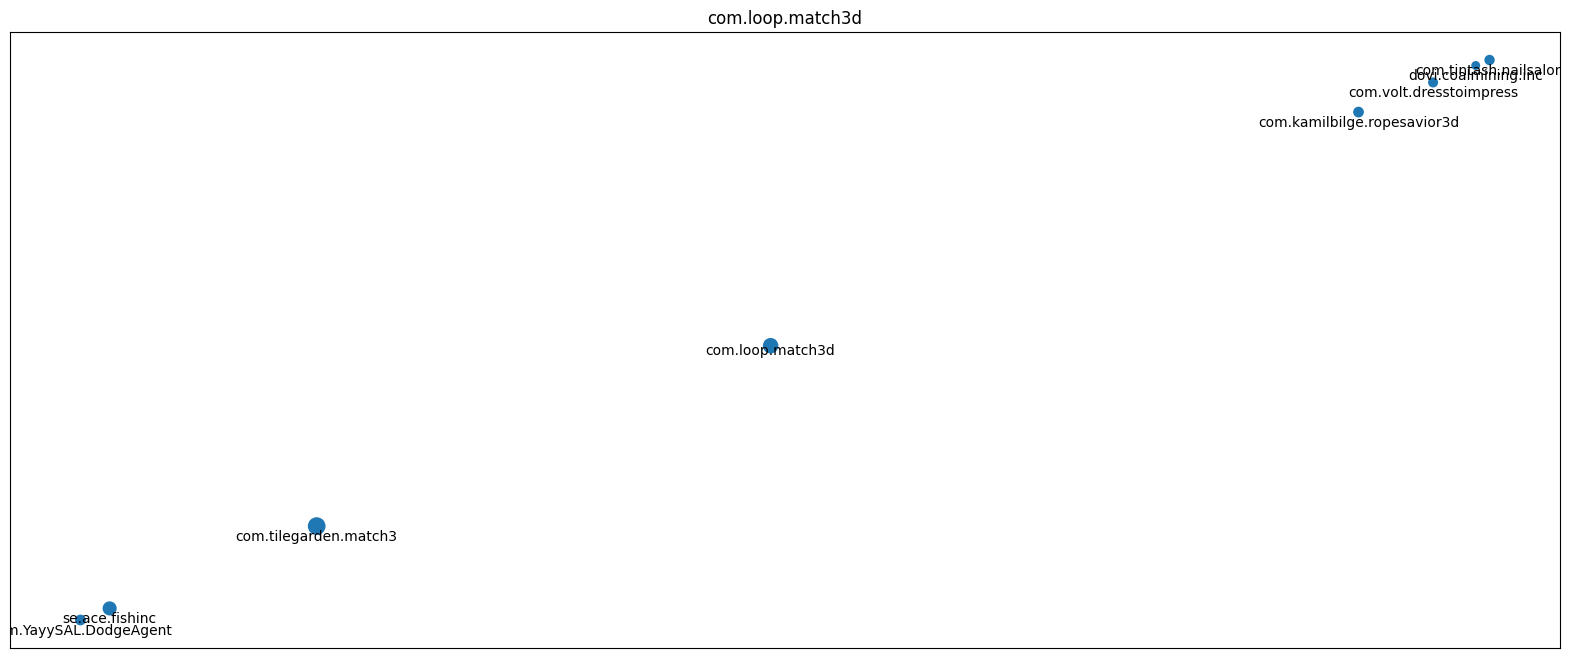

                             avg_price  cosine_similarity
bundleId                                                 
com.loop.match3d              2.059349           0.557880
com.kamilbilge.ropesavior3d   0.909099           1.000000
com.tilegarden.match3         2.765650           0.484870
com.tintash.nailsalon         0.834757           0.397408
se.ace.fishinc                1.677101           0.472770
dovi.coalmining.inc           0.587672           0.511413
com.YayySAL.DodgeAgent        0.910698           0.647838
com.volt.dresstoimpress       0.780055           0.445463


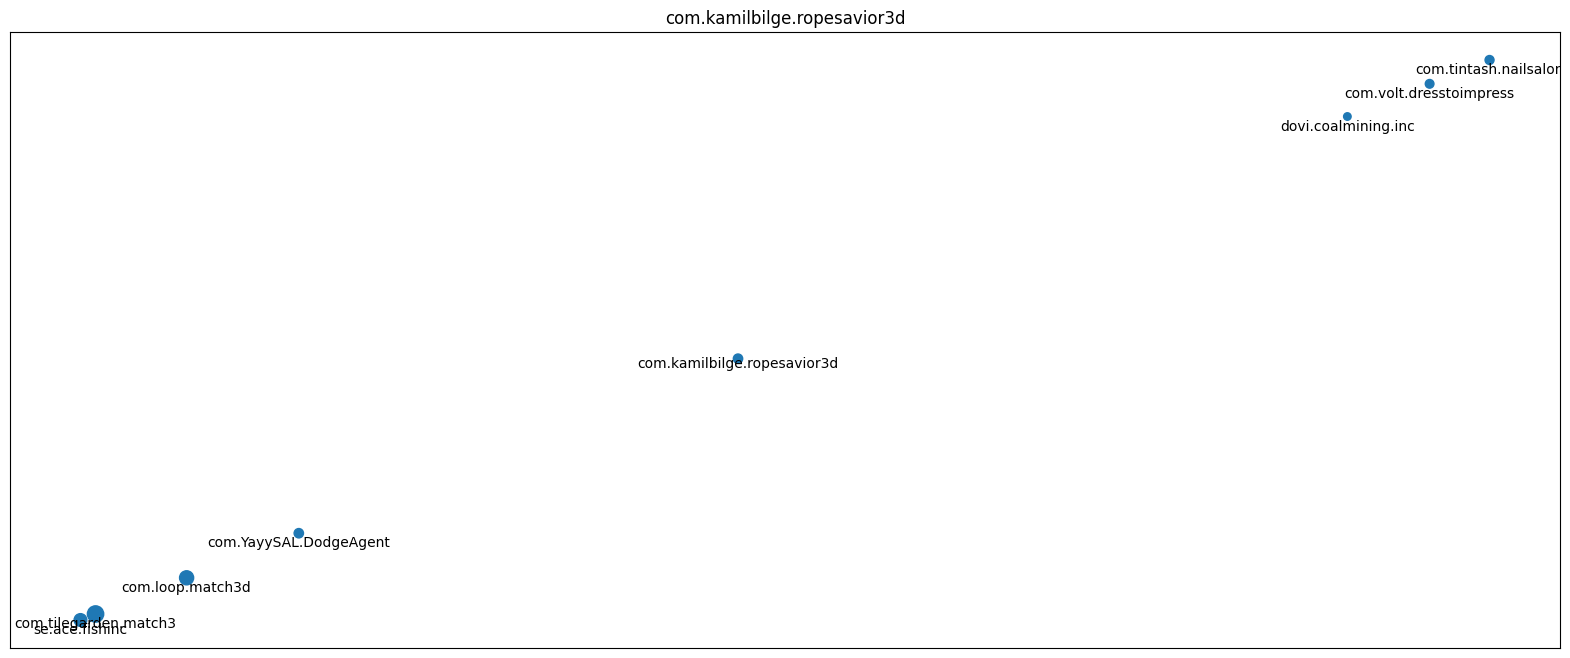

                             avg_price  cosine_similarity
bundleId                                                 
com.loop.match3d              2.059349           0.658637
com.kamilbilge.ropesavior3d   0.909099           0.484870
com.tilegarden.match3         2.765650           1.000000
com.tintash.nailsalon         0.834757           0.418847
se.ace.fishinc                1.677101           0.478936
dovi.coalmining.inc           0.587672           0.444795
com.YayySAL.DodgeAgent        0.910698           0.446939
com.volt.dresstoimpress       0.780055           0.462467


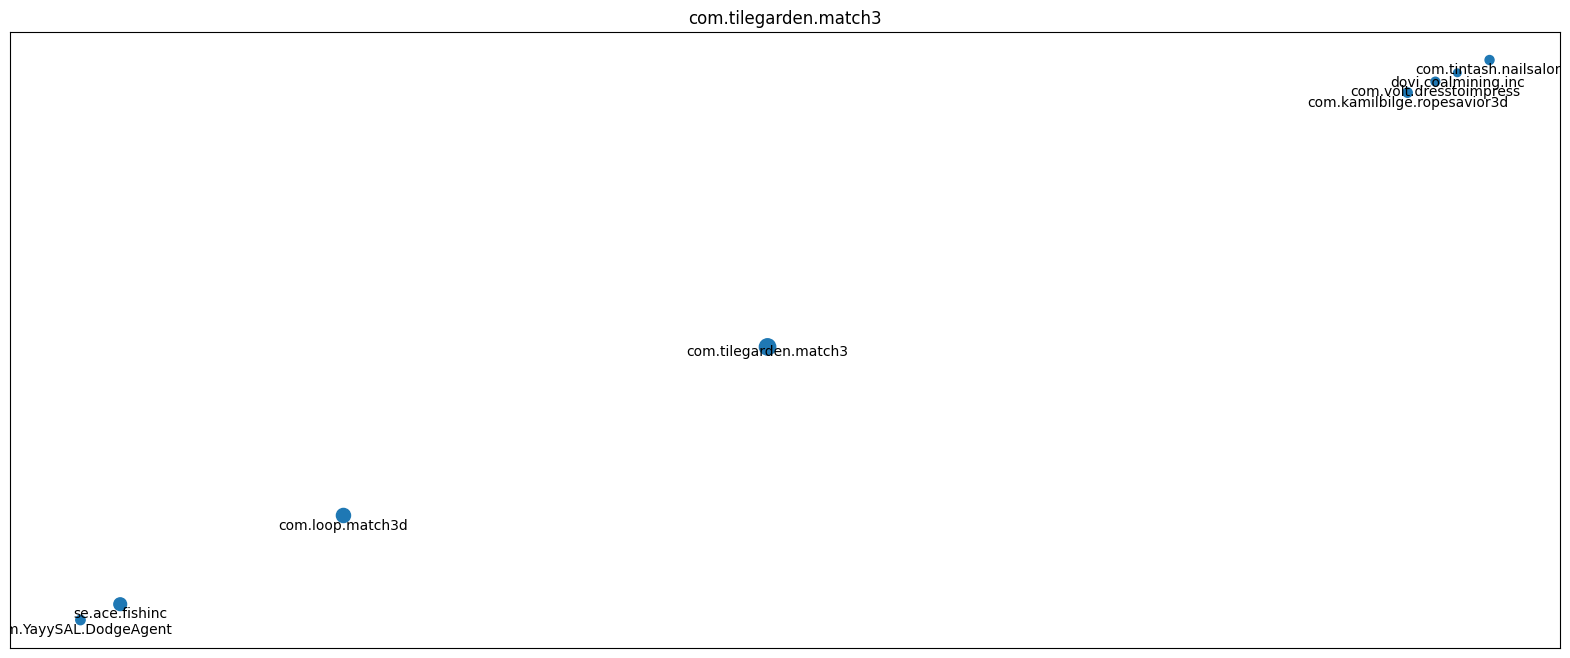

                             avg_price  cosine_similarity
bundleId                                                 
com.loop.match3d              2.059349           0.459344
com.kamilbilge.ropesavior3d   0.909099           0.397408
com.tilegarden.match3         2.765650           0.418847
com.tintash.nailsalon         0.834757           1.000000
se.ace.fishinc                1.677101           0.451082
dovi.coalmining.inc           0.587672           0.525149
com.YayySAL.DodgeAgent        0.910698           0.389171
com.volt.dresstoimpress       0.780055           0.504474


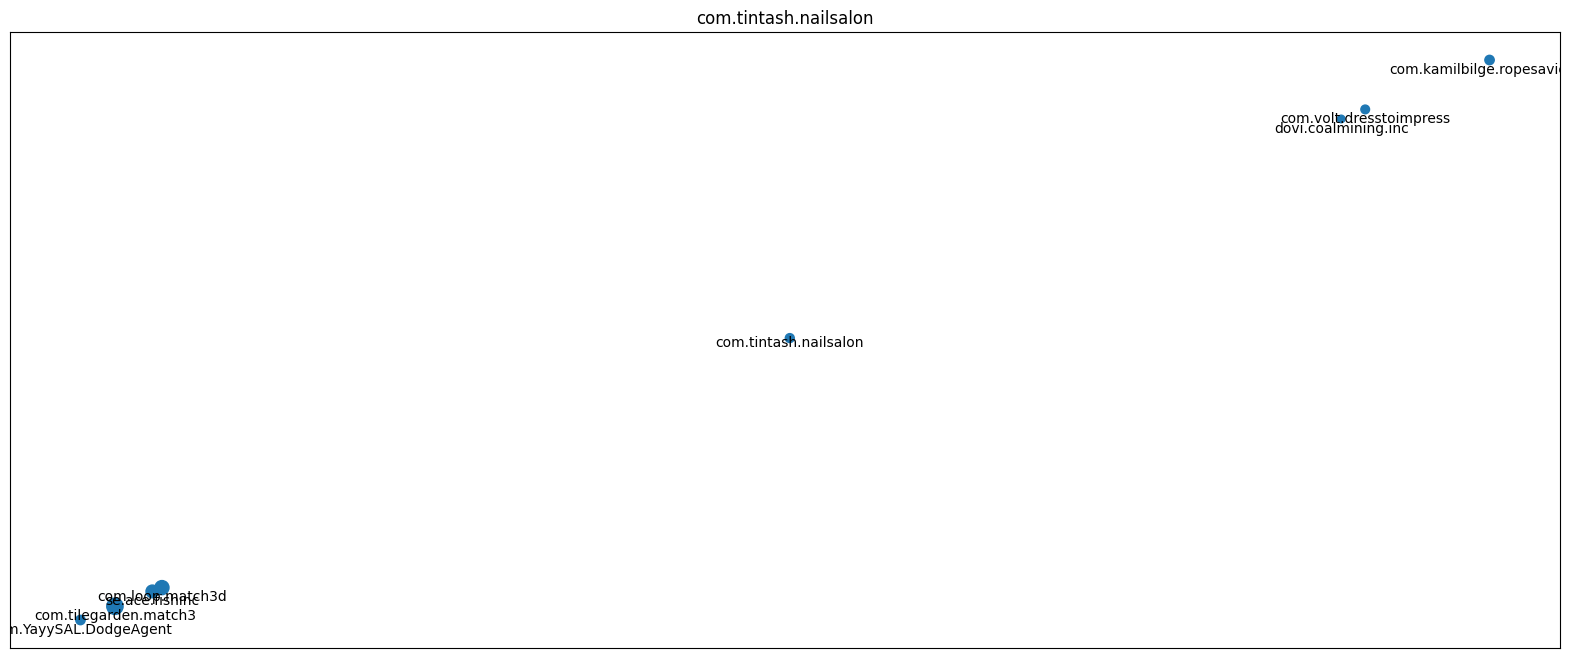

                             avg_price  cosine_similarity
bundleId                                                 
com.loop.match3d              2.059349           0.502924
com.kamilbilge.ropesavior3d   0.909099           0.472770
com.tilegarden.match3         2.765650           0.478936
com.tintash.nailsalon         0.834757           0.451082
se.ace.fishinc                1.677101           1.000000
dovi.coalmining.inc           0.587672           0.669928
com.YayySAL.DodgeAgent        0.910698           0.485706
com.volt.dresstoimpress       0.780055           0.403193


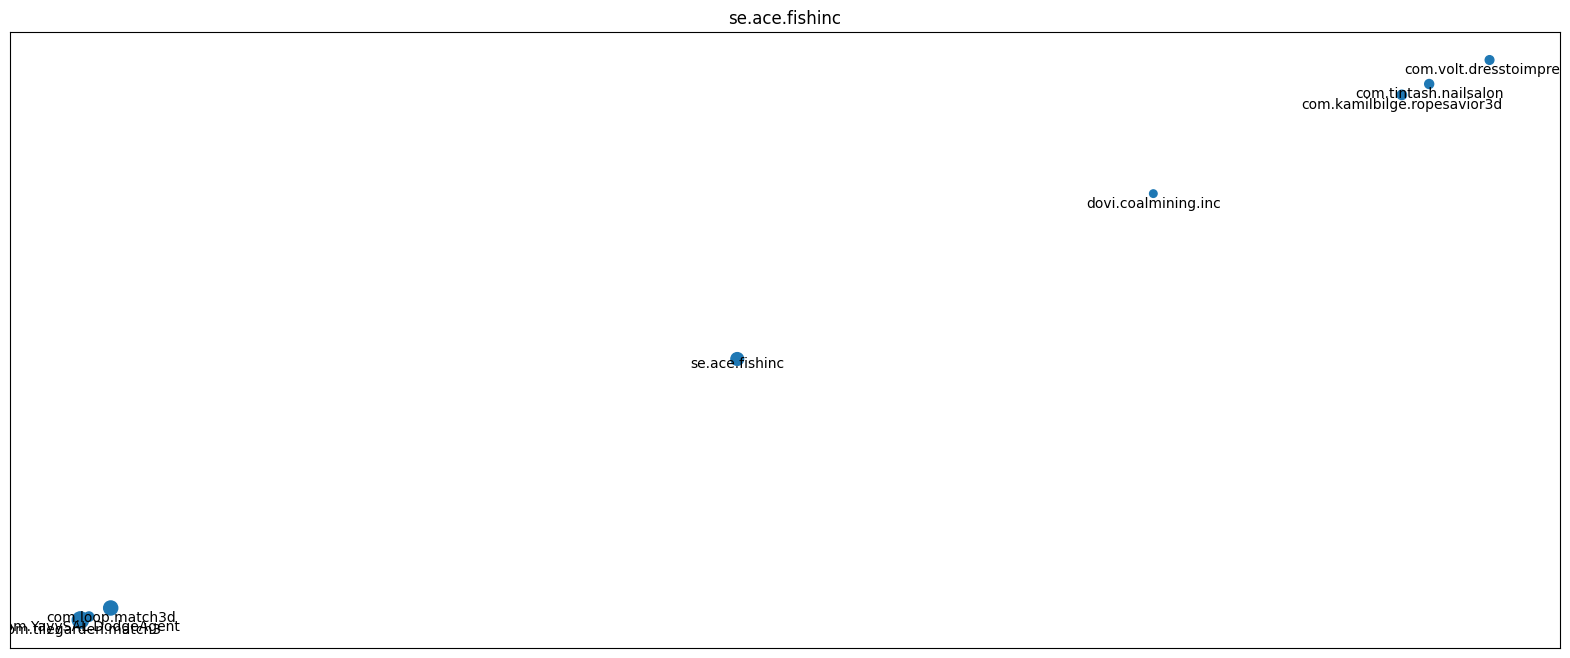

                             avg_price  cosine_similarity
bundleId                                                 
com.loop.match3d              2.059349           0.469741
com.kamilbilge.ropesavior3d   0.909099           0.511413
com.tilegarden.match3         2.765650           0.444795
com.tintash.nailsalon         0.834757           0.525149
se.ace.fishinc                1.677101           0.669928
dovi.coalmining.inc           0.587672           1.000000
com.YayySAL.DodgeAgent        0.910698           0.490686
com.volt.dresstoimpress       0.780055           0.377867


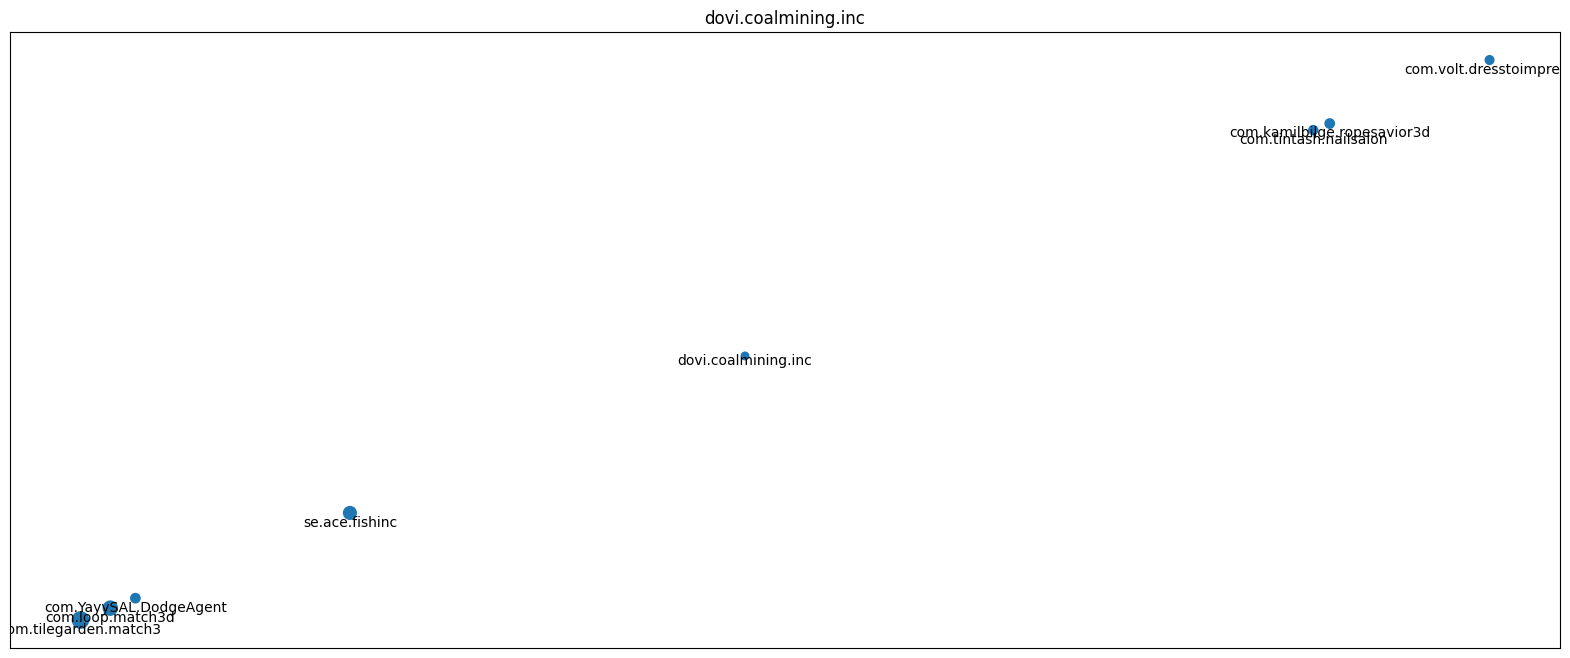

                             avg_price  cosine_similarity
bundleId                                                 
com.loop.match3d              2.059349           0.480975
com.kamilbilge.ropesavior3d   0.909099           0.647838
com.tilegarden.match3         2.765650           0.446939
com.tintash.nailsalon         0.834757           0.389171
se.ace.fishinc                1.677101           0.485706
dovi.coalmining.inc           0.587672           0.490686
com.YayySAL.DodgeAgent        0.910698           1.000000
com.volt.dresstoimpress       0.780055           0.437803


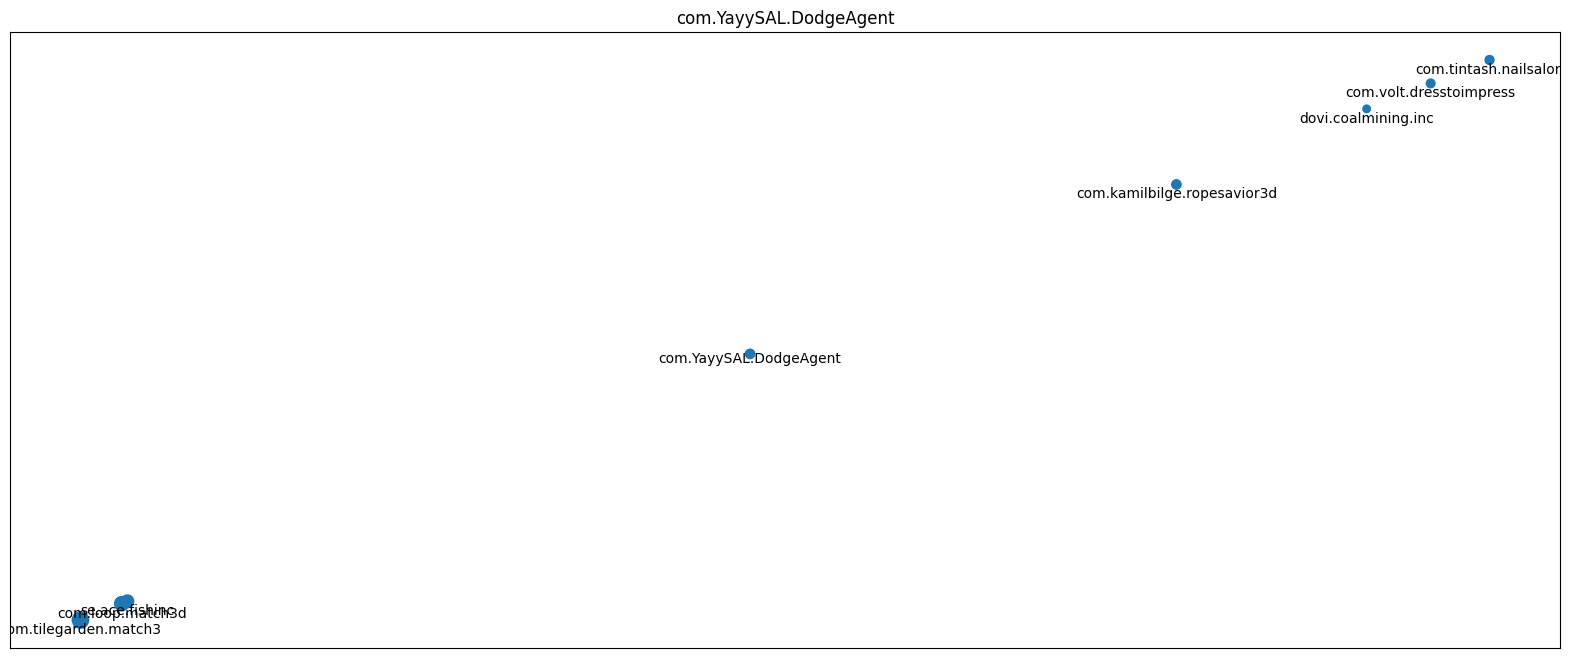

                             avg_price  cosine_similarity
bundleId                                                 
com.loop.match3d              2.059349           0.501801
com.kamilbilge.ropesavior3d   0.909099           0.445463
com.tilegarden.match3         2.765650           0.462467
com.tintash.nailsalon         0.834757           0.504474
se.ace.fishinc                1.677101           0.403193
dovi.coalmining.inc           0.587672           0.377867
com.YayySAL.DodgeAgent        0.910698           0.437803
com.volt.dresstoimpress       0.780055           1.000000


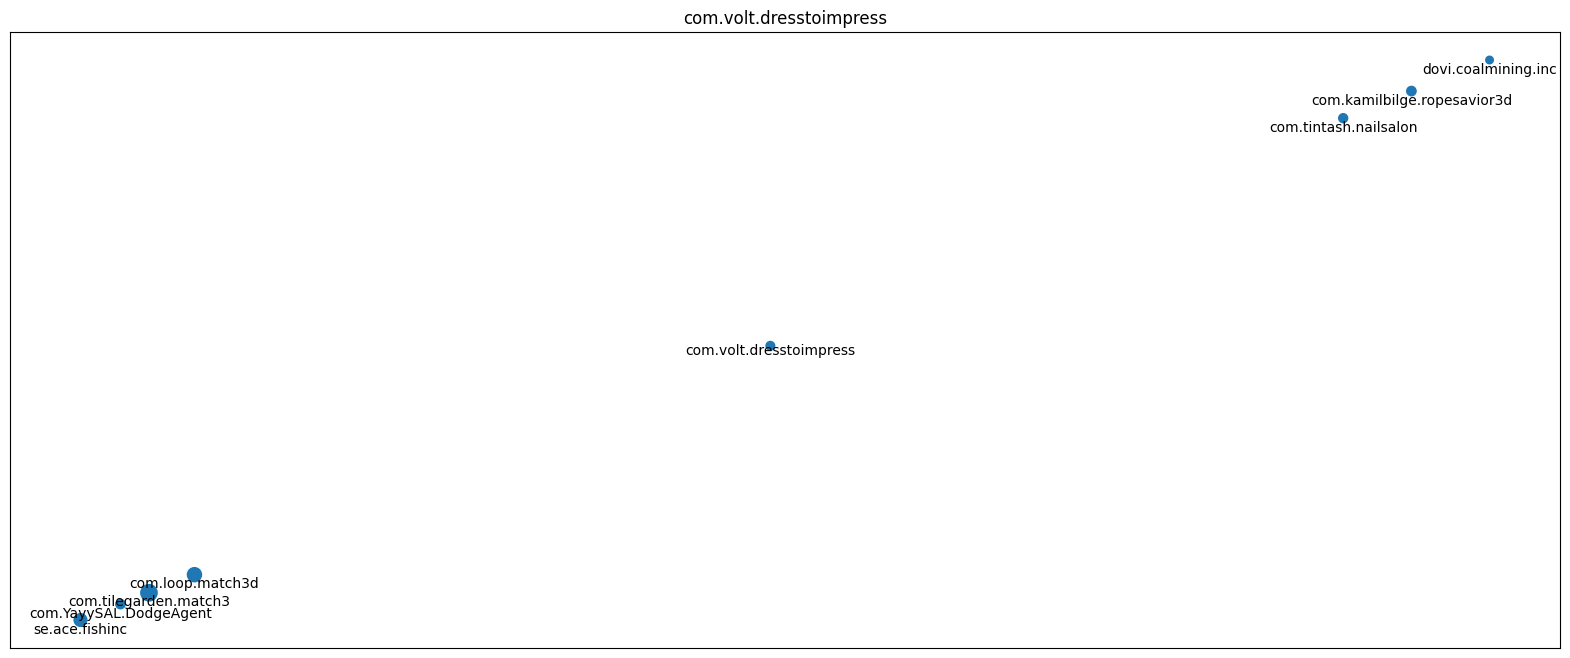

In [22]:
main(df_f_rewarded_Android, df_app)

# 2. UnitDisplayType: rewarded; Operating System: iOS

            avg_price  cosine_similarity
bundleId                                
1523081624   2.478602           1.000000
1579489488   3.839310           0.397408
1502447854   4.465664           0.497849
1436213906   2.439332           0.478738
1569586264   7.653077           0.504474
1529614832   2.355476           0.397721
1586795332   1.783889           0.454166
1582745578   2.648333           0.525150
1542256628   3.442917           0.389171


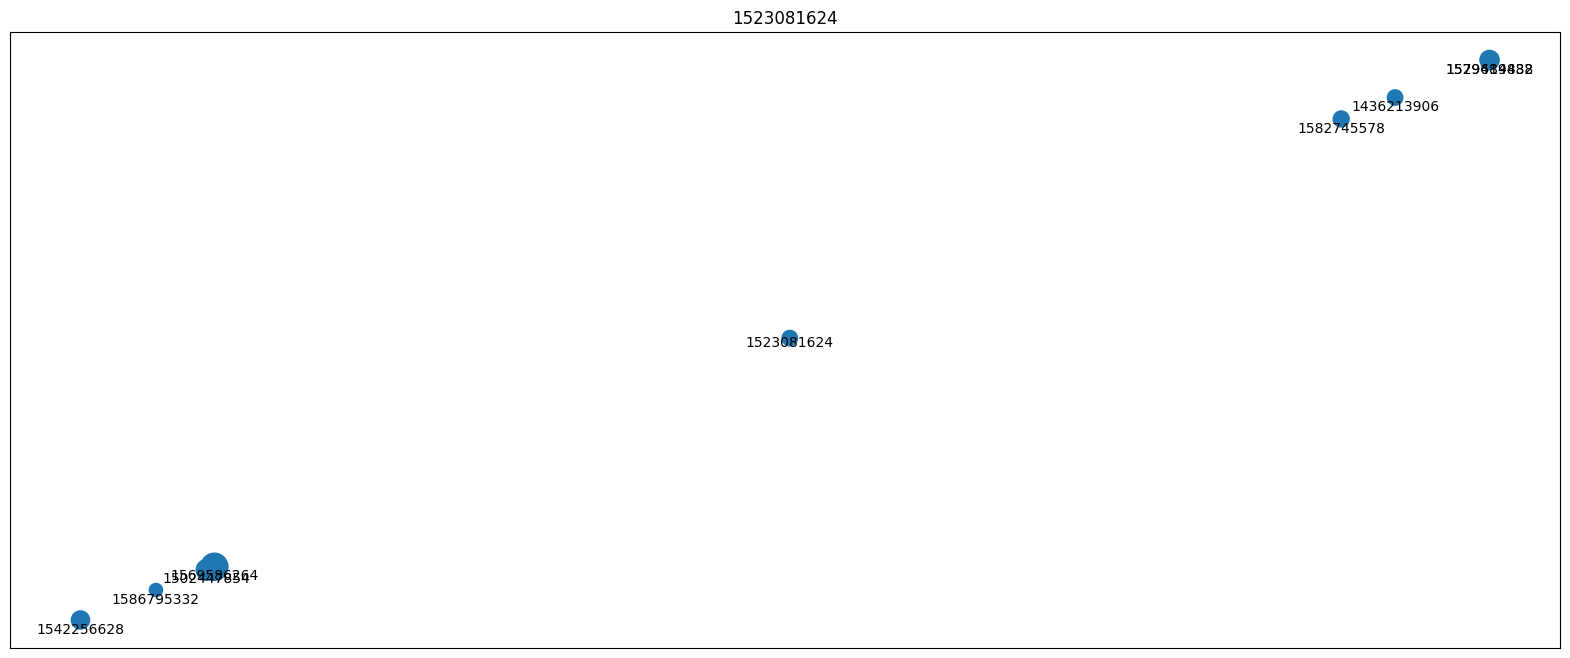

            avg_price  cosine_similarity
bundleId                                
1523081624   2.478602           0.397408
1579489488   3.839310           1.000000
1502447854   4.465664           0.589520
1436213906   2.439332           0.498040
1569586264   7.653077           0.445463
1529614832   2.355476           0.510735
1586795332   1.783889           0.590973
1582745578   2.648333           0.511413
1542256628   3.442917           0.647838


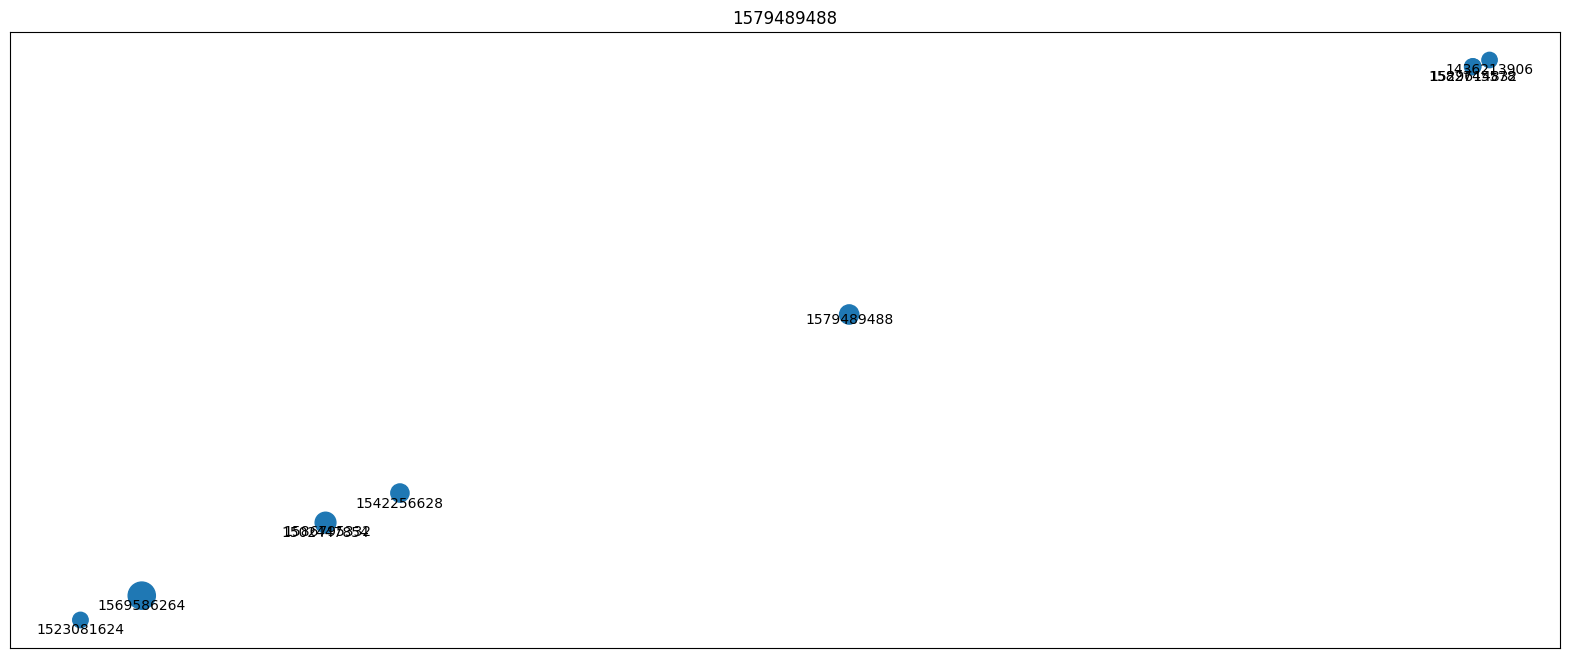

            avg_price  cosine_similarity
bundleId                                
1523081624   2.478602           0.497849
1579489488   3.839310           0.589520
1502447854   4.465664           1.000000
1436213906   2.439332           0.550381
1569586264   7.653077           0.532882
1529614832   2.355476           0.742816
1586795332   1.783889           0.521311
1582745578   2.648333           0.490862
1542256628   3.442917           0.504298


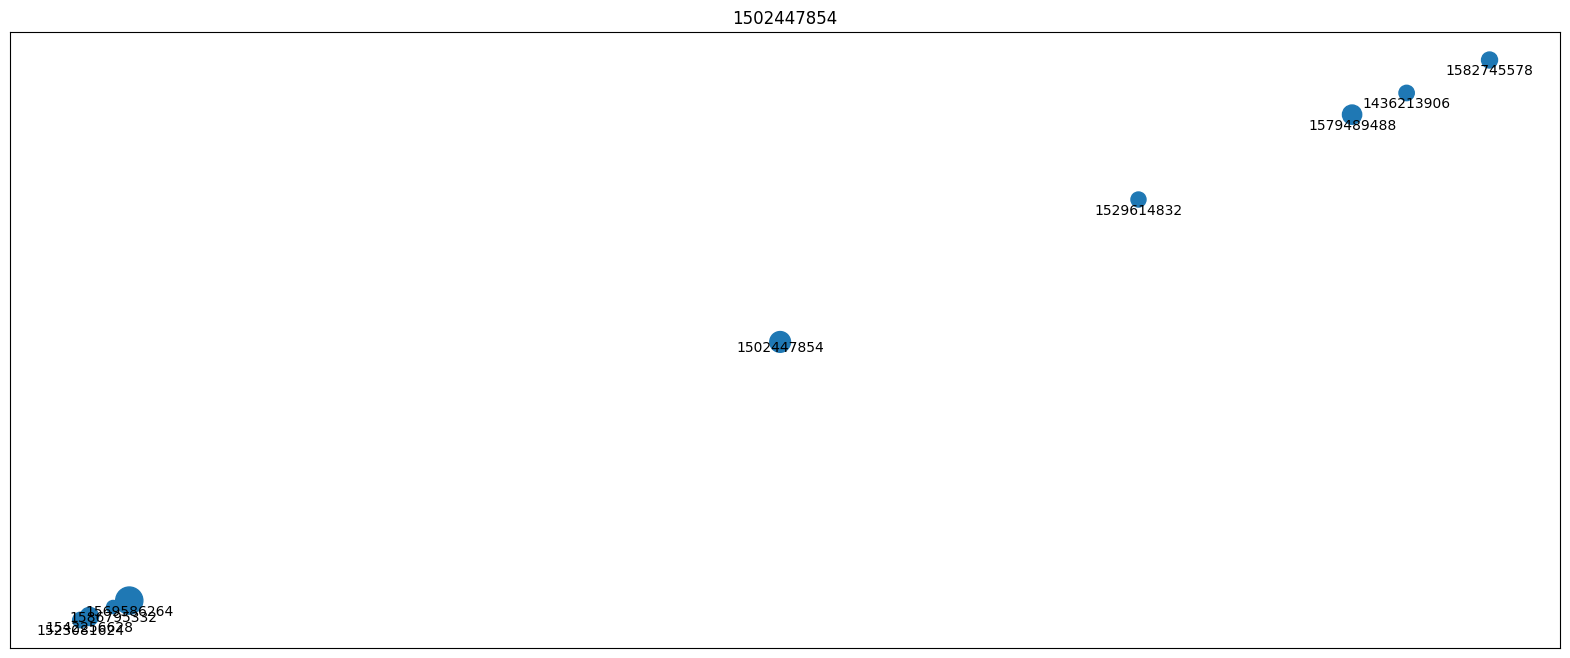

            avg_price  cosine_similarity
bundleId                                
1523081624   2.478602           0.478738
1579489488   3.839310           0.498040
1502447854   4.465664           0.550381
1436213906   2.439332           1.000000
1569586264   7.653077           0.408562
1529614832   2.355476           0.431569
1586795332   1.783889           0.478761
1582745578   2.648333           0.676883
1542256628   3.442917           0.510226


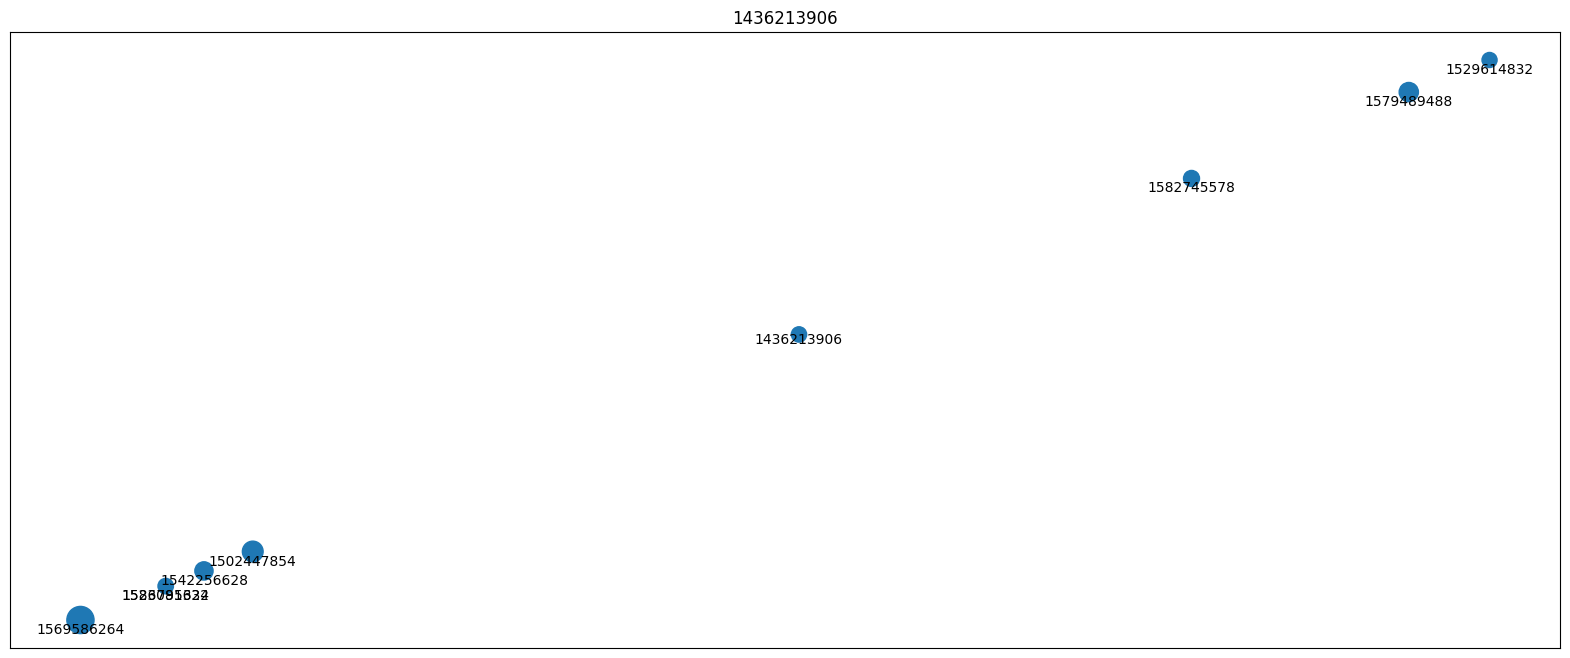

            avg_price  cosine_similarity
bundleId                                
1523081624   2.478602           0.504474
1579489488   3.839310           0.445463
1502447854   4.465664           0.532882
1436213906   2.439332           0.408562
1569586264   7.653077           1.000000
1529614832   2.355476           0.472777
1586795332   1.783889           0.537237
1582745578   2.648333           0.377867
1542256628   3.442917           0.437803


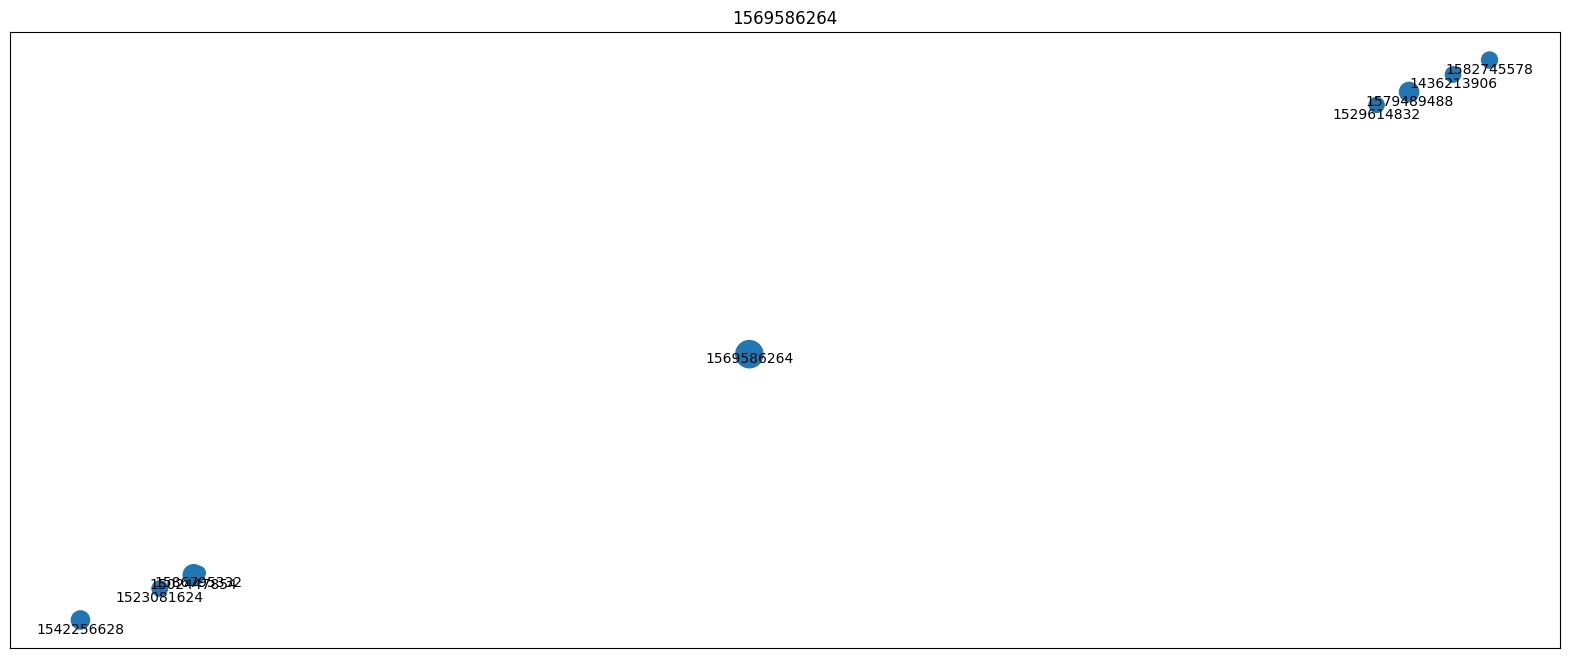

            avg_price  cosine_similarity
bundleId                                
1523081624   2.478602           0.397721
1579489488   3.839310           0.510735
1502447854   4.465664           0.742816
1436213906   2.439332           0.431569
1569586264   7.653077           0.472777
1529614832   2.355476           1.000000
1586795332   1.783889           0.434522
1582745578   2.648333           0.408701
1542256628   3.442917           0.444397


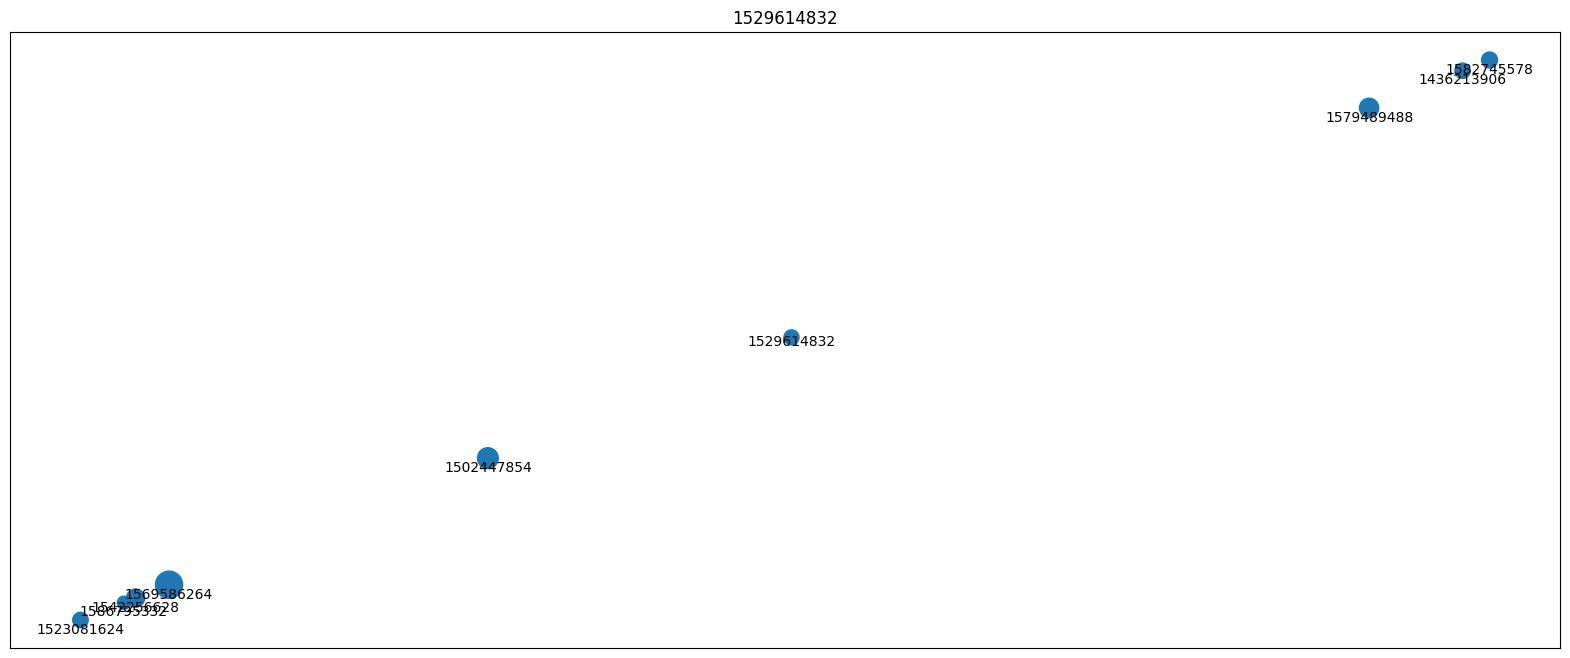

            avg_price  cosine_similarity
bundleId                                
1523081624   2.478602           0.454166
1579489488   3.839310           0.590973
1502447854   4.465664           0.521311
1436213906   2.439332           0.478761
1569586264   7.653077           0.537237
1529614832   2.355476           0.434522
1586795332   1.783889           1.000000
1582745578   2.648333           0.449943
1542256628   3.442917           0.589571


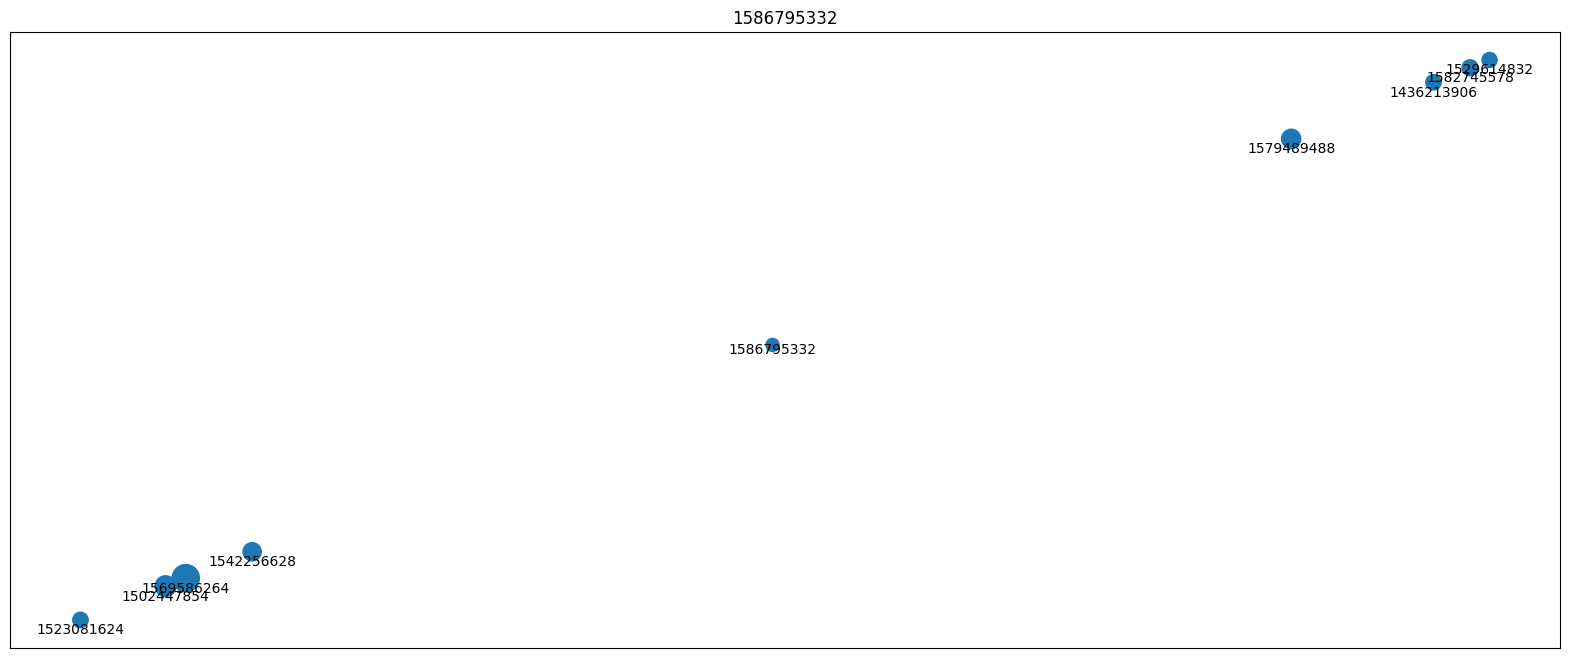

            avg_price  cosine_similarity
bundleId                                
1523081624   2.478602           0.525150
1579489488   3.839310           0.511413
1502447854   4.465664           0.490862
1436213906   2.439332           0.676883
1569586264   7.653077           0.377867
1529614832   2.355476           0.408701
1586795332   1.783889           0.449943
1582745578   2.648333           1.000000
1542256628   3.442917           0.490686


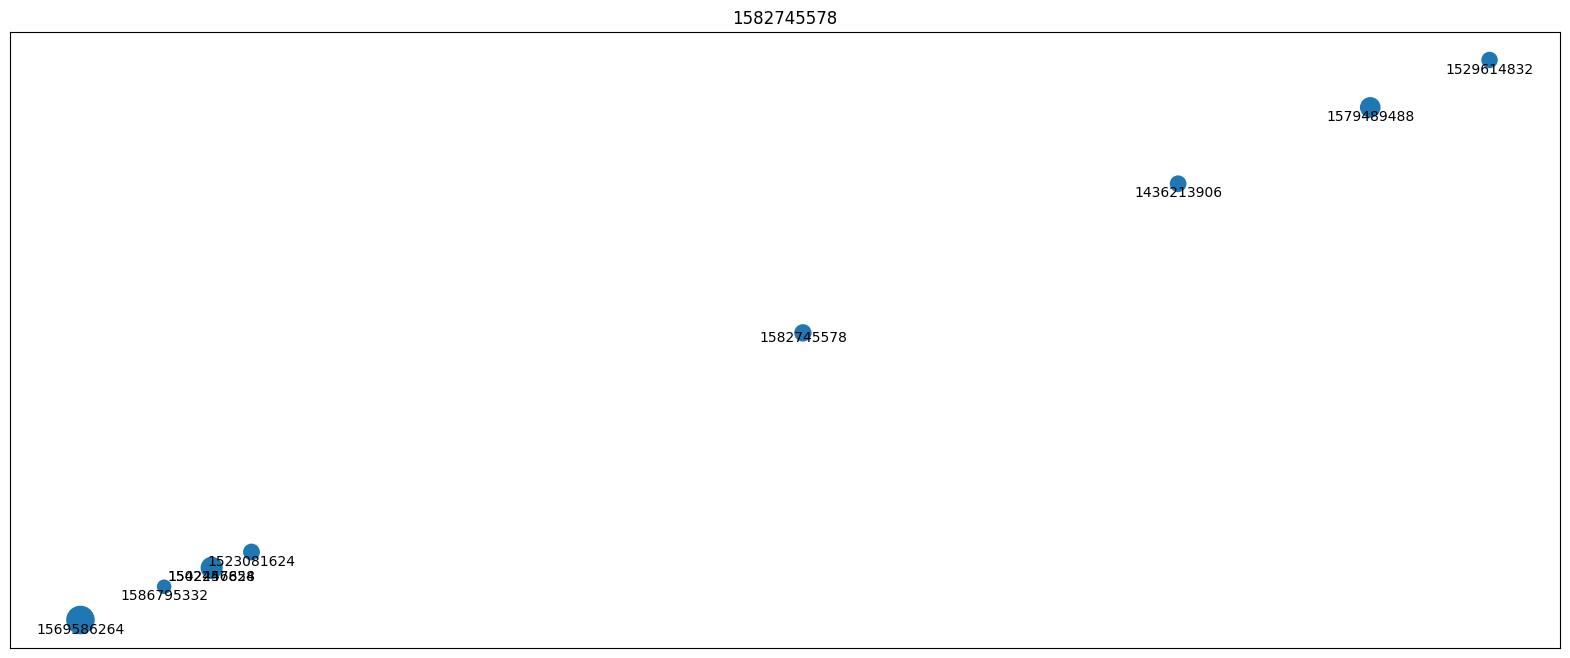

            avg_price  cosine_similarity
bundleId                                
1523081624   2.478602           0.389171
1579489488   3.839310           0.647838
1502447854   4.465664           0.504298
1436213906   2.439332           0.510226
1569586264   7.653077           0.437803
1529614832   2.355476           0.444397
1586795332   1.783889           0.589571
1582745578   2.648333           0.490686
1542256628   3.442917           1.000000


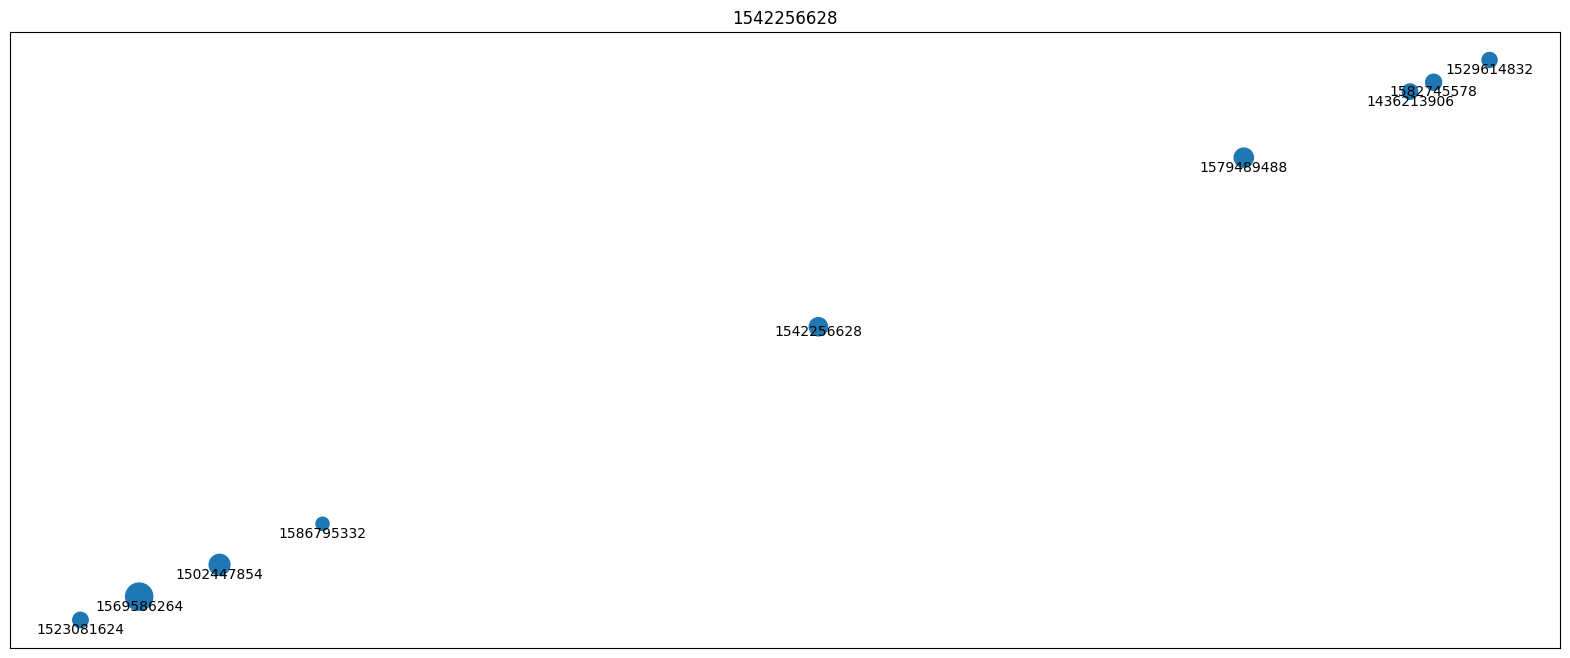

In [23]:
main(df_f_rewarded_iOS, df_app)

# 3.UnitDisplayType: interstitial; Operating System: Android

                             avg_price  cosine_similarity
bundleId                                                 
com.loop.match3d              1.030505           1.000000
com.YayySAL.DodgeAgent        0.702584           0.480975
com.tintash.nailsalon         0.429000           0.459344
se.ace.fishinc                1.230993           0.502924
com.tilegarden.match3         1.563503           0.658637
com.kamilbilge.ropesavior3d   0.611508           0.557880
com.volt.dresstoimpress       1.705287           0.501801


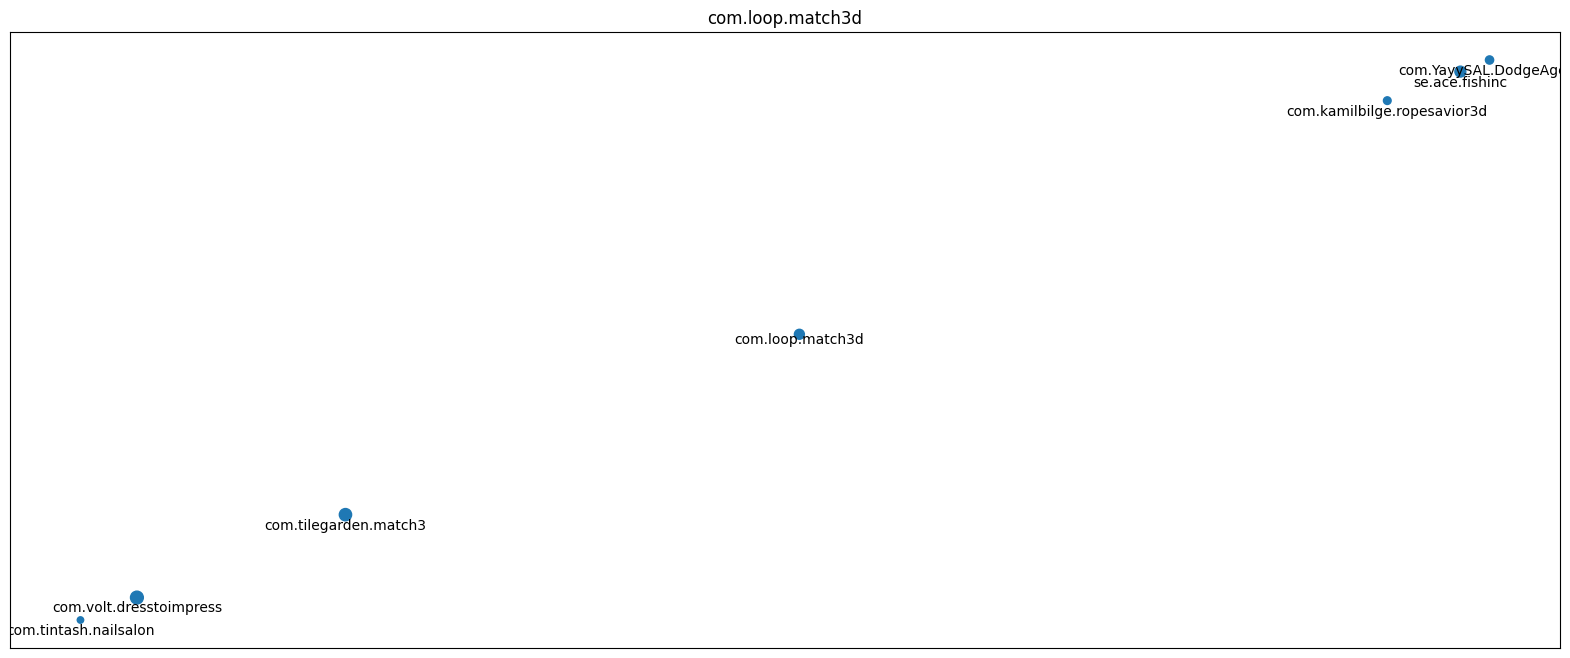

                             avg_price  cosine_similarity
bundleId                                                 
com.loop.match3d              1.030505           0.480975
com.YayySAL.DodgeAgent        0.702584           1.000000
com.tintash.nailsalon         0.429000           0.389171
se.ace.fishinc                1.230993           0.485706
com.tilegarden.match3         1.563503           0.446939
com.kamilbilge.ropesavior3d   0.611508           0.647838
com.volt.dresstoimpress       1.705287           0.437803


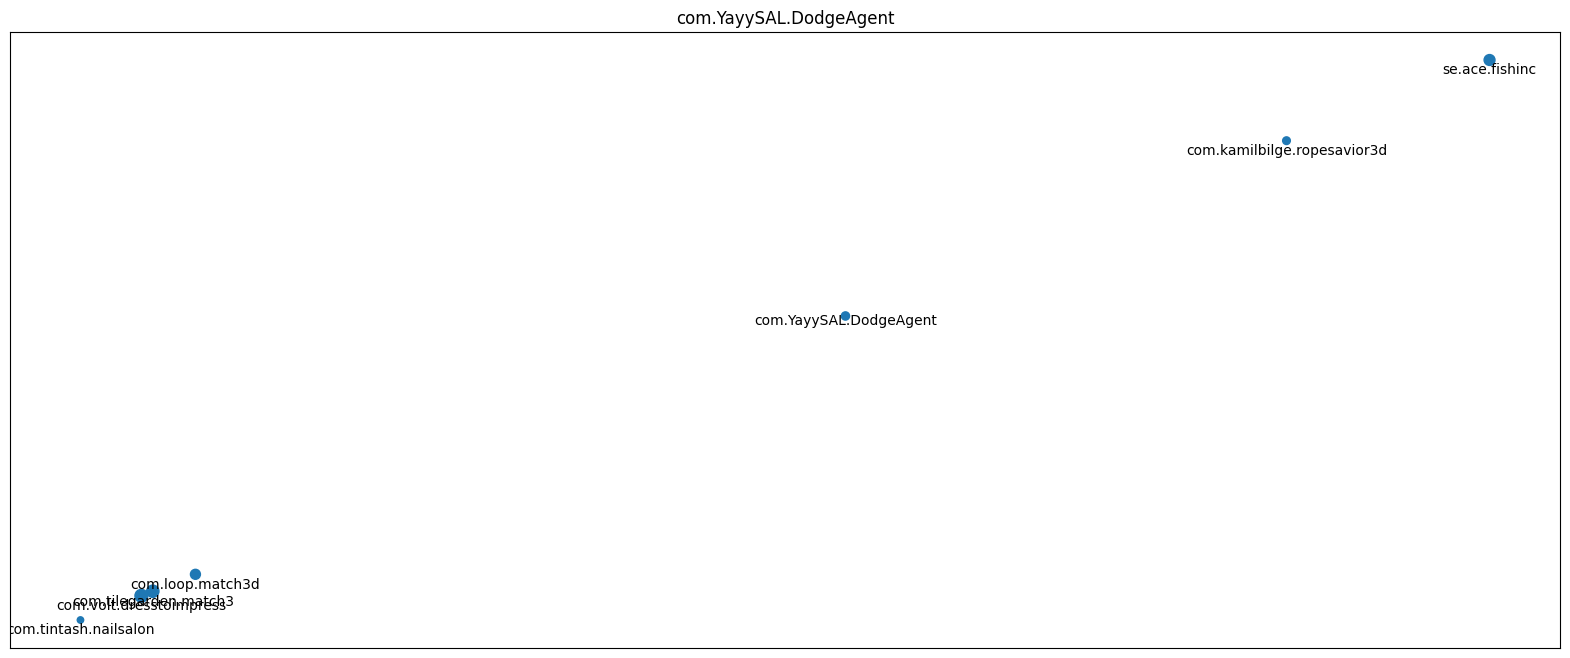

                             avg_price  cosine_similarity
bundleId                                                 
com.loop.match3d              1.030505           0.459344
com.YayySAL.DodgeAgent        0.702584           0.389171
com.tintash.nailsalon         0.429000           1.000000
se.ace.fishinc                1.230993           0.451082
com.tilegarden.match3         1.563503           0.418847
com.kamilbilge.ropesavior3d   0.611508           0.397408
com.volt.dresstoimpress       1.705287           0.504474


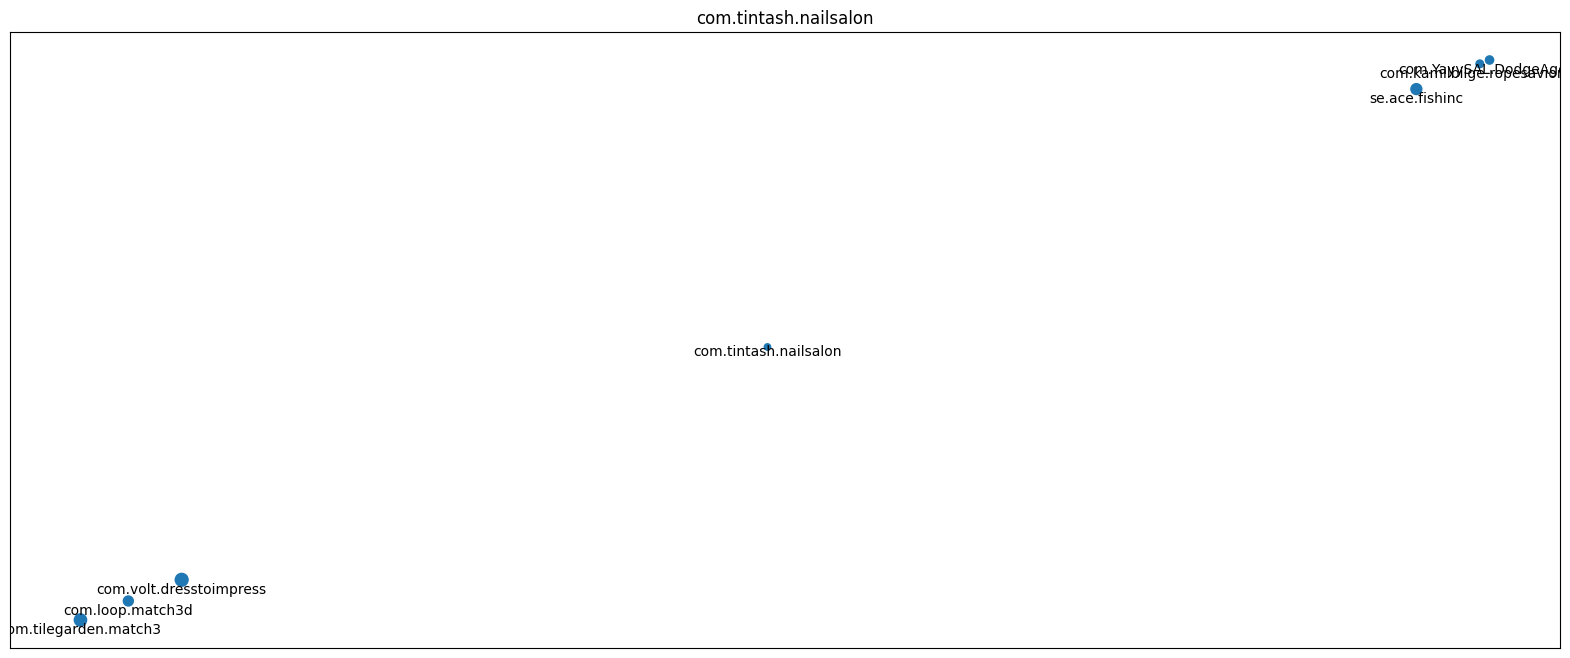

                             avg_price  cosine_similarity
bundleId                                                 
com.loop.match3d              1.030505           0.502924
com.YayySAL.DodgeAgent        0.702584           0.485706
com.tintash.nailsalon         0.429000           0.451082
se.ace.fishinc                1.230993           1.000000
com.tilegarden.match3         1.563503           0.478936
com.kamilbilge.ropesavior3d   0.611508           0.472770
com.volt.dresstoimpress       1.705287           0.403193


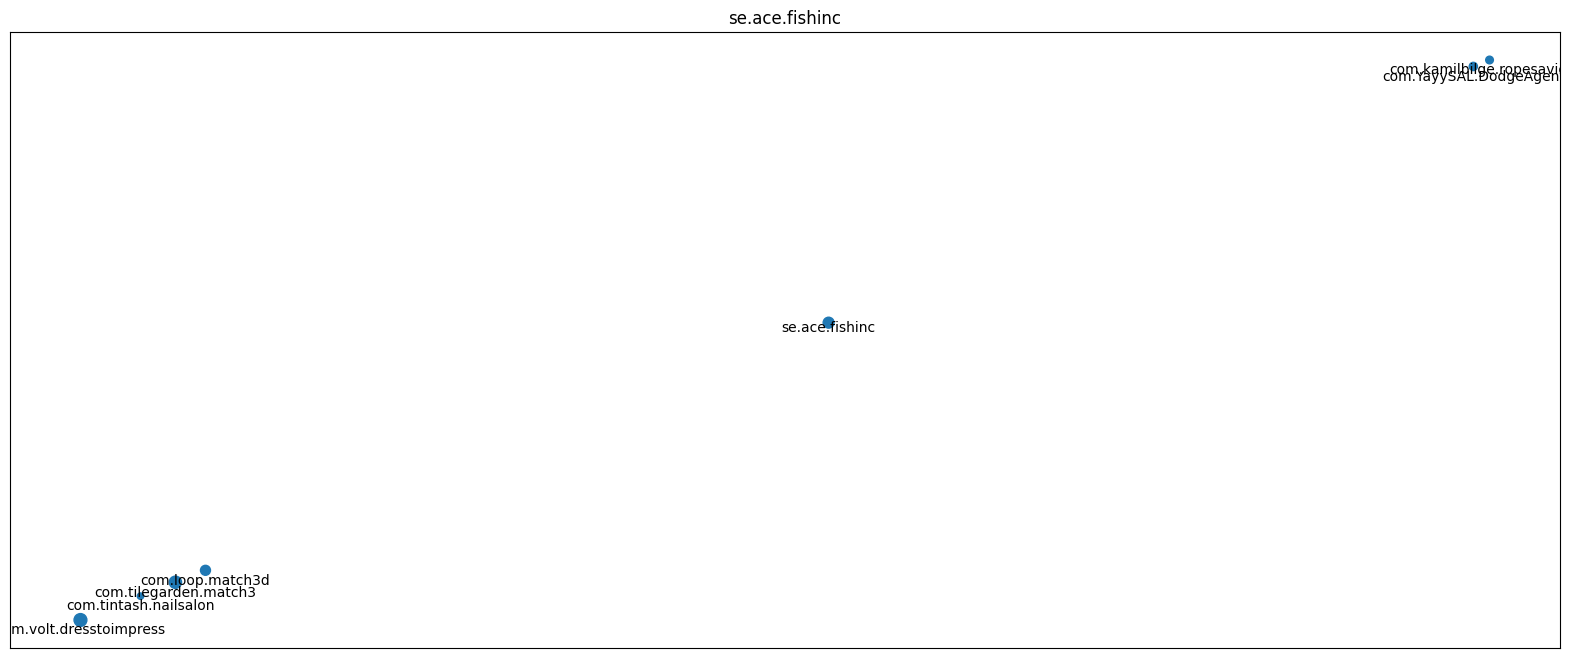

                             avg_price  cosine_similarity
bundleId                                                 
com.loop.match3d              1.030505           0.658637
com.YayySAL.DodgeAgent        0.702584           0.446939
com.tintash.nailsalon         0.429000           0.418847
se.ace.fishinc                1.230993           0.478936
com.tilegarden.match3         1.563503           1.000000
com.kamilbilge.ropesavior3d   0.611508           0.484870
com.volt.dresstoimpress       1.705287           0.462467


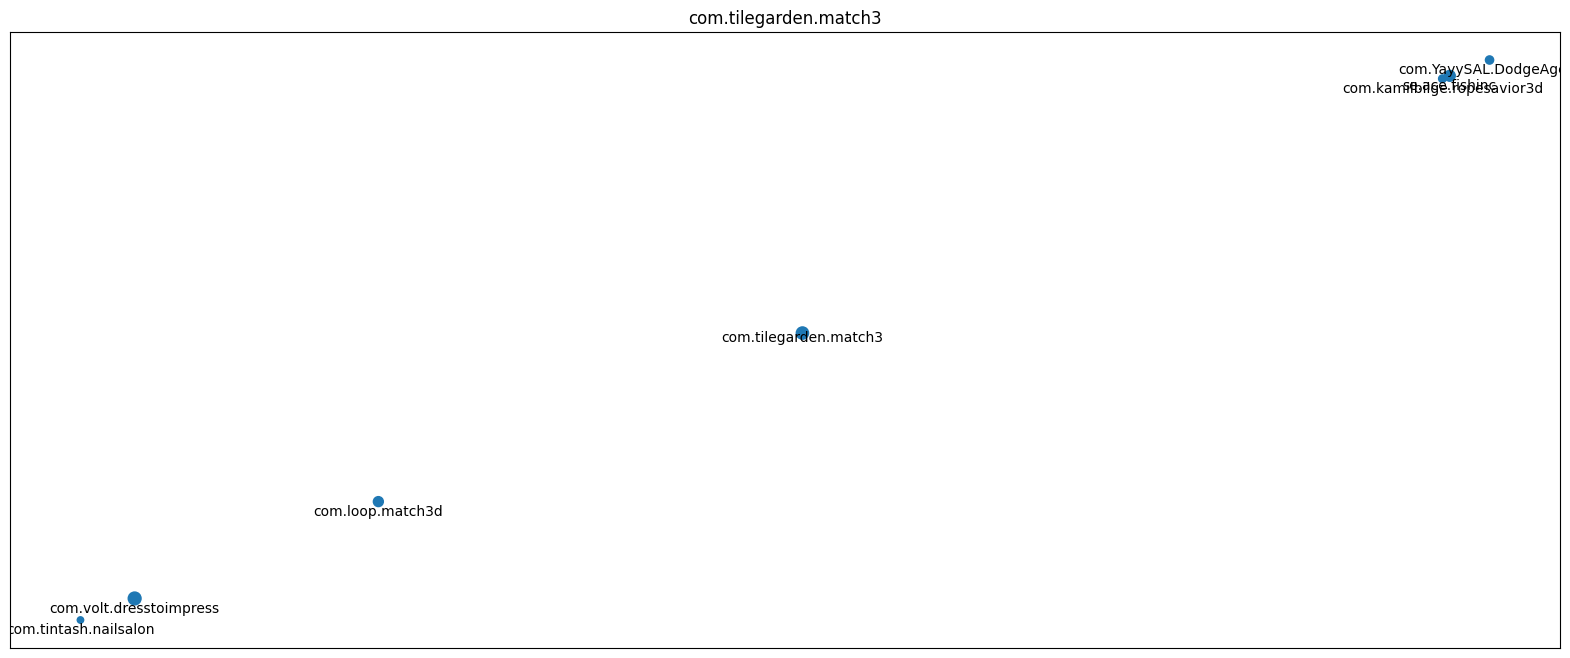

                             avg_price  cosine_similarity
bundleId                                                 
com.loop.match3d              1.030505           0.557880
com.YayySAL.DodgeAgent        0.702584           0.647838
com.tintash.nailsalon         0.429000           0.397408
se.ace.fishinc                1.230993           0.472770
com.tilegarden.match3         1.563503           0.484870
com.kamilbilge.ropesavior3d   0.611508           1.000000
com.volt.dresstoimpress       1.705287           0.445463


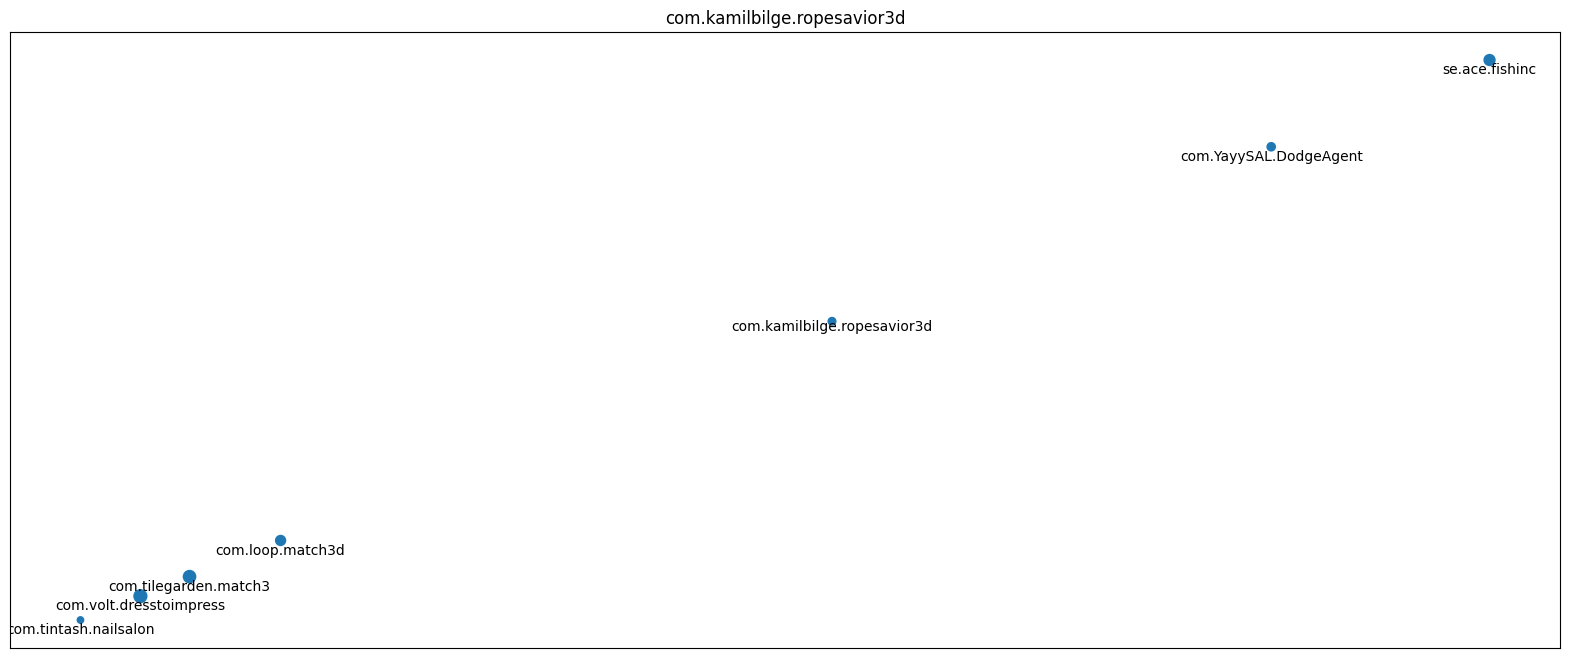

                             avg_price  cosine_similarity
bundleId                                                 
com.loop.match3d              1.030505           0.501801
com.YayySAL.DodgeAgent        0.702584           0.437803
com.tintash.nailsalon         0.429000           0.504474
se.ace.fishinc                1.230993           0.403193
com.tilegarden.match3         1.563503           0.462467
com.kamilbilge.ropesavior3d   0.611508           0.445463
com.volt.dresstoimpress       1.705287           1.000000


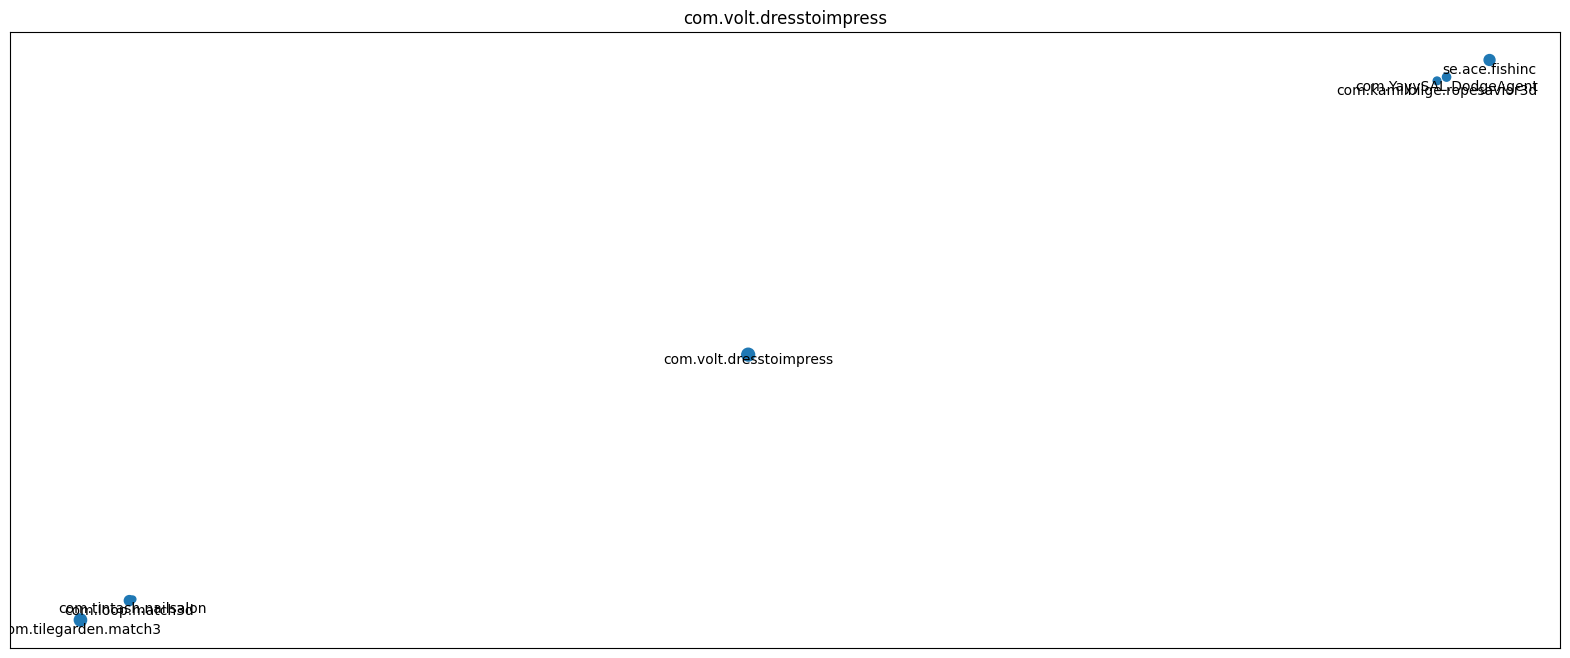

In [24]:
main(df_f_interstitial_Android, df_app)

# 4.UnitDisplayType: interstitial; Operating System: iOS

            avg_price  cosine_similarity
bundleId                                
1529614832   2.436522           1.000000
1436213906   4.125326           0.431569
1523081624   2.022347           0.397721
1502447854   2.676969           0.742816
1586795332   2.635055           0.434522
1542256628   4.929487           0.444397
1579489488   1.735556           0.510735
1569586264   8.009500           0.472777


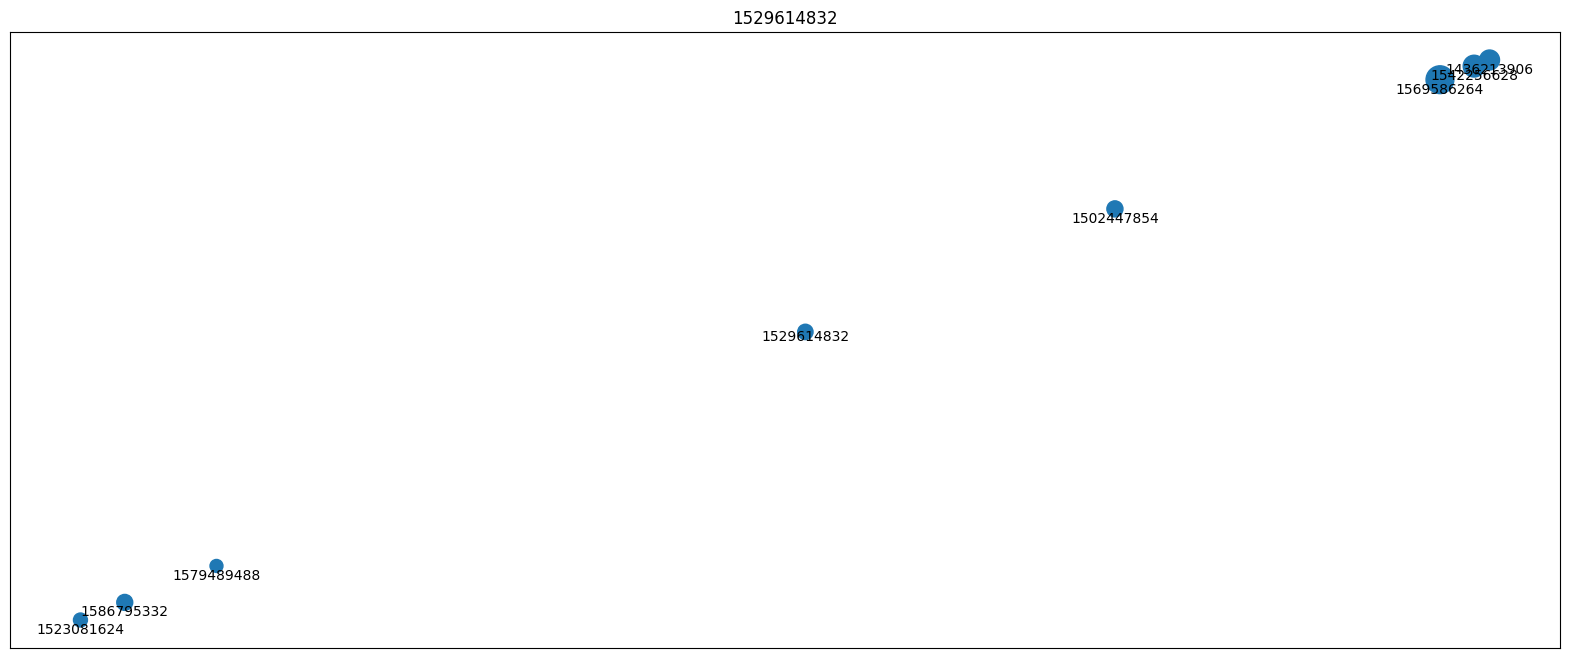

            avg_price  cosine_similarity
bundleId                                
1529614832   2.436522           0.431569
1436213906   4.125326           1.000000
1523081624   2.022347           0.478738
1502447854   2.676969           0.550381
1586795332   2.635055           0.478761
1542256628   4.929487           0.510226
1579489488   1.735556           0.498040
1569586264   8.009500           0.408562


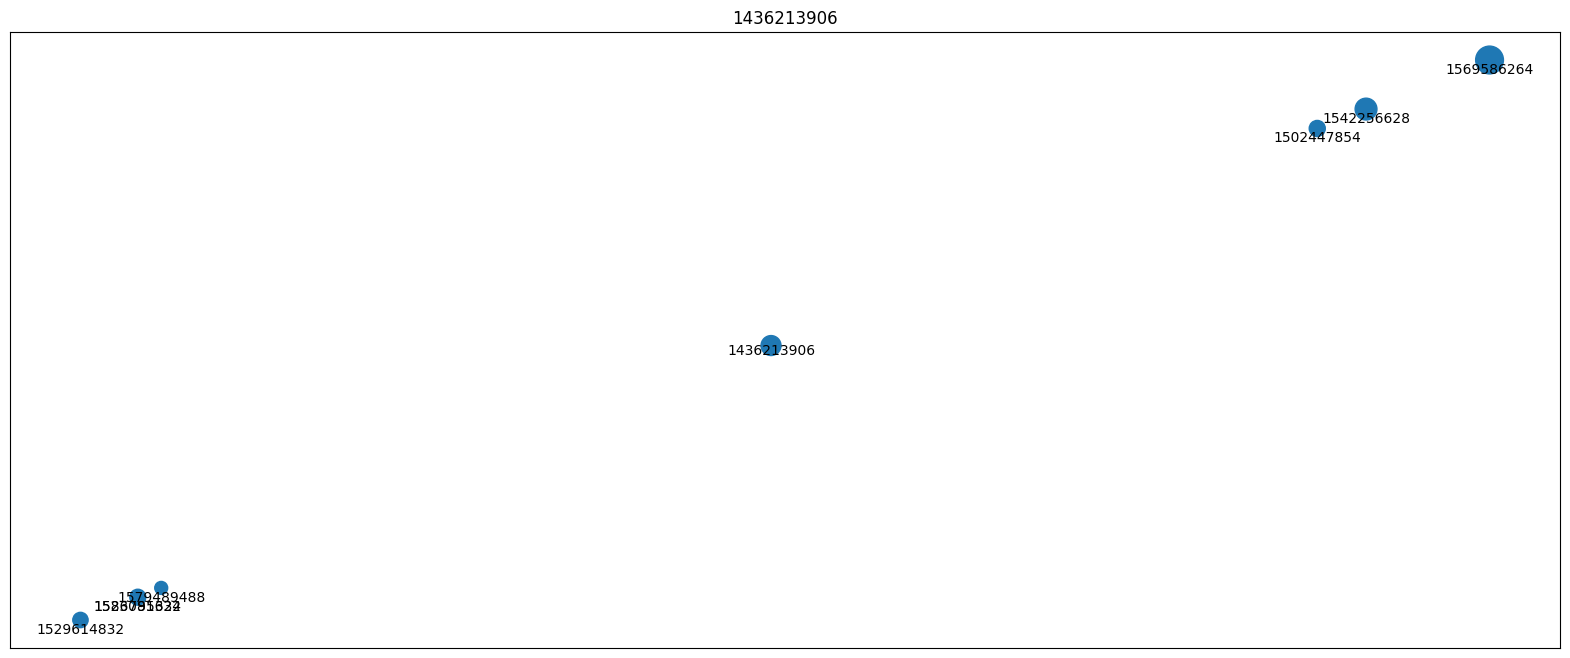

            avg_price  cosine_similarity
bundleId                                
1529614832   2.436522           0.397721
1436213906   4.125326           0.478738
1523081624   2.022347           1.000000
1502447854   2.676969           0.497849
1586795332   2.635055           0.454166
1542256628   4.929487           0.389171
1579489488   1.735556           0.397408
1569586264   8.009500           0.504474


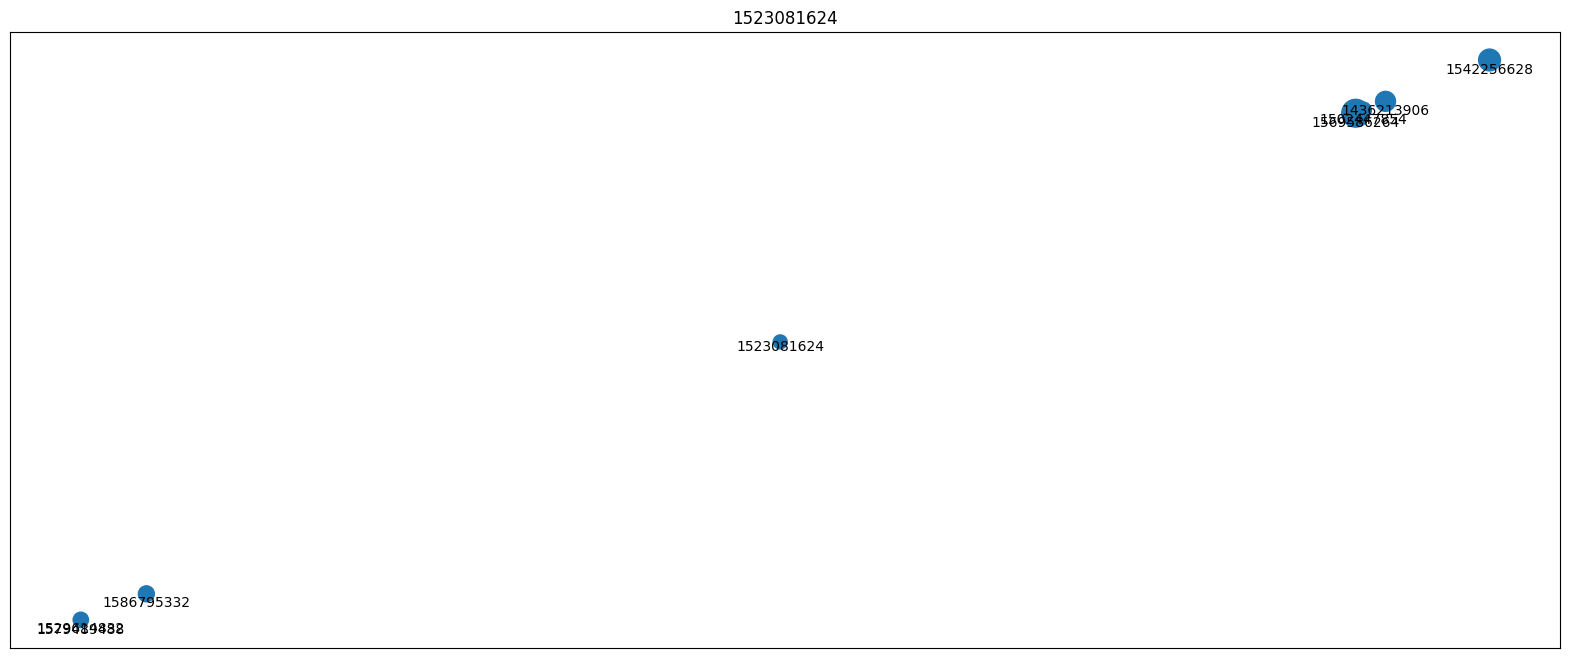

            avg_price  cosine_similarity
bundleId                                
1529614832   2.436522           0.742816
1436213906   4.125326           0.550381
1523081624   2.022347           0.497849
1502447854   2.676969           1.000000
1586795332   2.635055           0.521311
1542256628   4.929487           0.504298
1579489488   1.735556           0.589520
1569586264   8.009500           0.532882


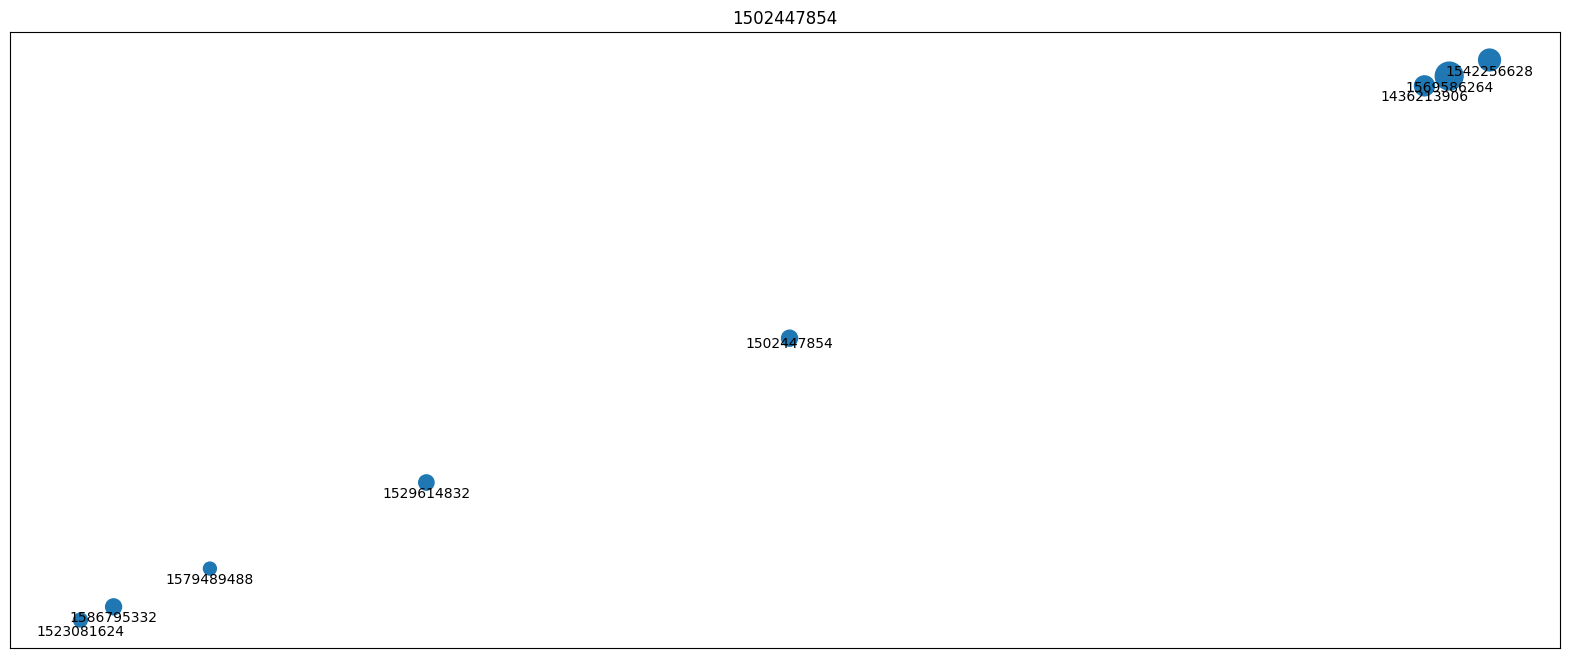

            avg_price  cosine_similarity
bundleId                                
1529614832   2.436522           0.434522
1436213906   4.125326           0.478761
1523081624   2.022347           0.454166
1502447854   2.676969           0.521311
1586795332   2.635055           1.000000
1542256628   4.929487           0.589571
1579489488   1.735556           0.590973
1569586264   8.009500           0.537237


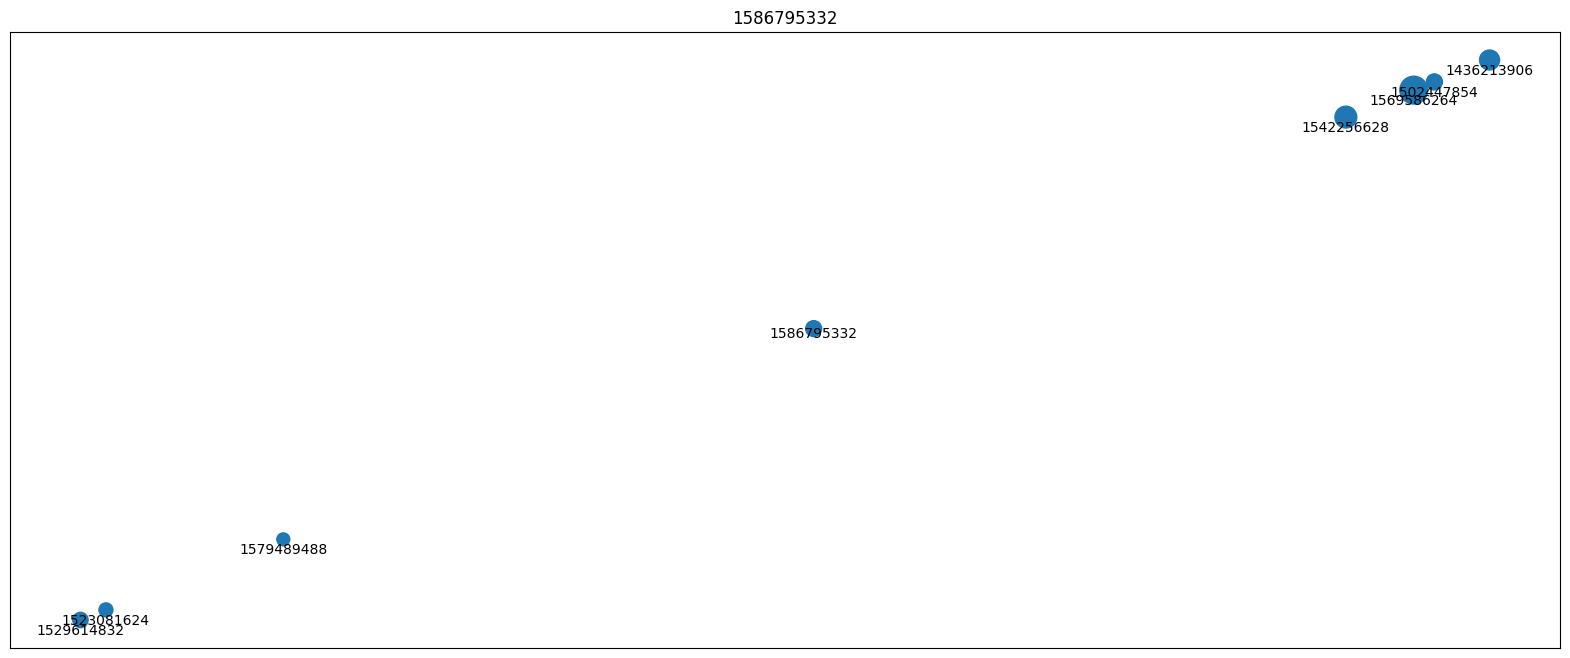

            avg_price  cosine_similarity
bundleId                                
1529614832   2.436522           0.444397
1436213906   4.125326           0.510226
1523081624   2.022347           0.389171
1502447854   2.676969           0.504298
1586795332   2.635055           0.589571
1542256628   4.929487           1.000000
1579489488   1.735556           0.647838
1569586264   8.009500           0.437803


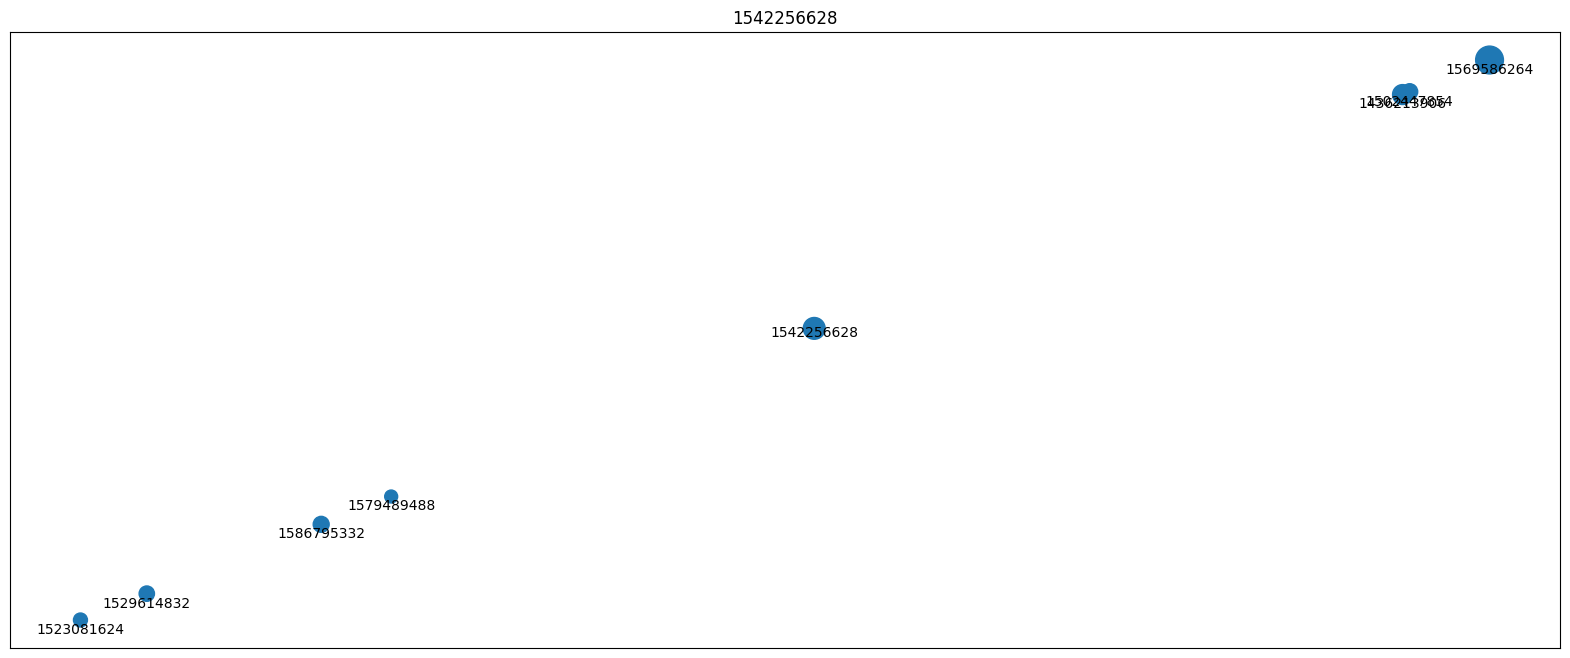

            avg_price  cosine_similarity
bundleId                                
1529614832   2.436522           0.510735
1436213906   4.125326           0.498040
1523081624   2.022347           0.397408
1502447854   2.676969           0.589520
1586795332   2.635055           0.590973
1542256628   4.929487           0.647838
1579489488   1.735556           1.000000
1569586264   8.009500           0.445463


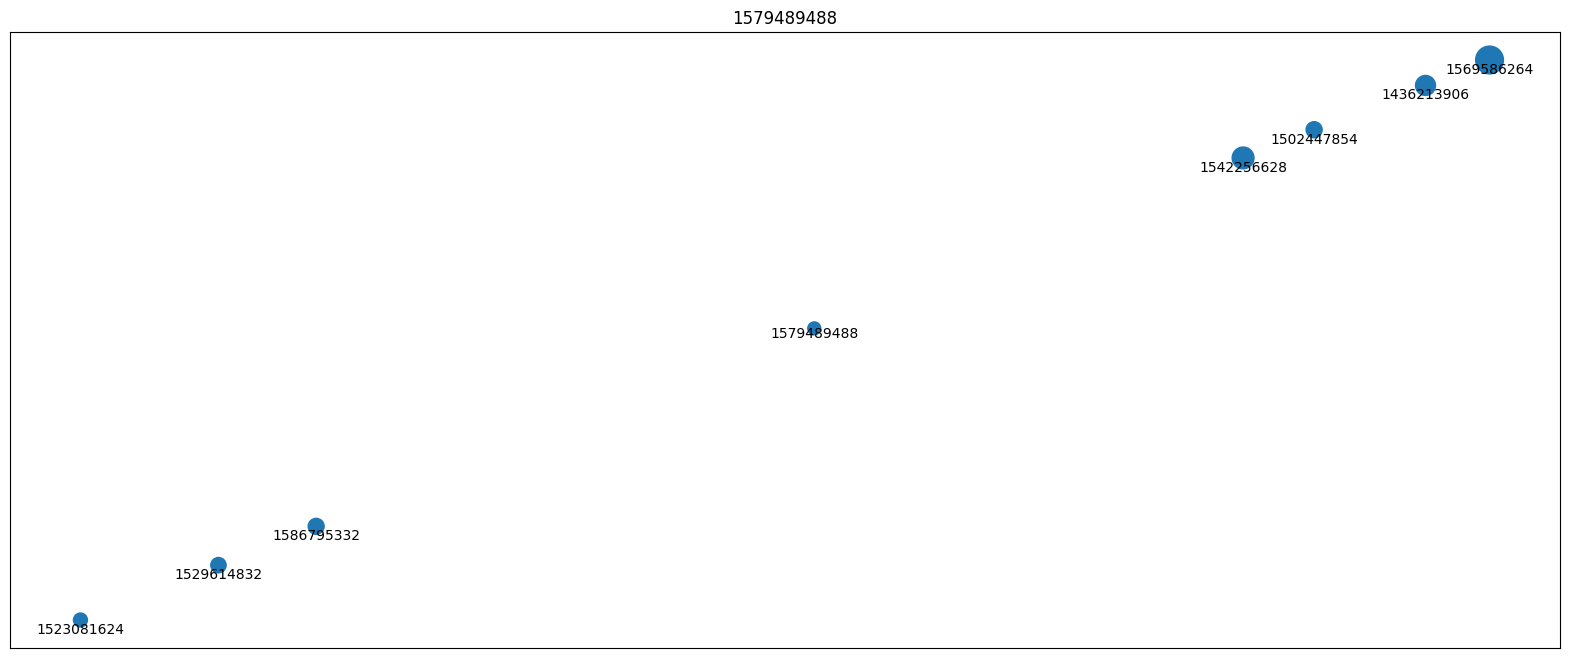

            avg_price  cosine_similarity
bundleId                                
1529614832   2.436522           0.472777
1436213906   4.125326           0.408562
1523081624   2.022347           0.504474
1502447854   2.676969           0.532882
1586795332   2.635055           0.537237
1542256628   4.929487           0.437803
1579489488   1.735556           0.445463
1569586264   8.009500           1.000000


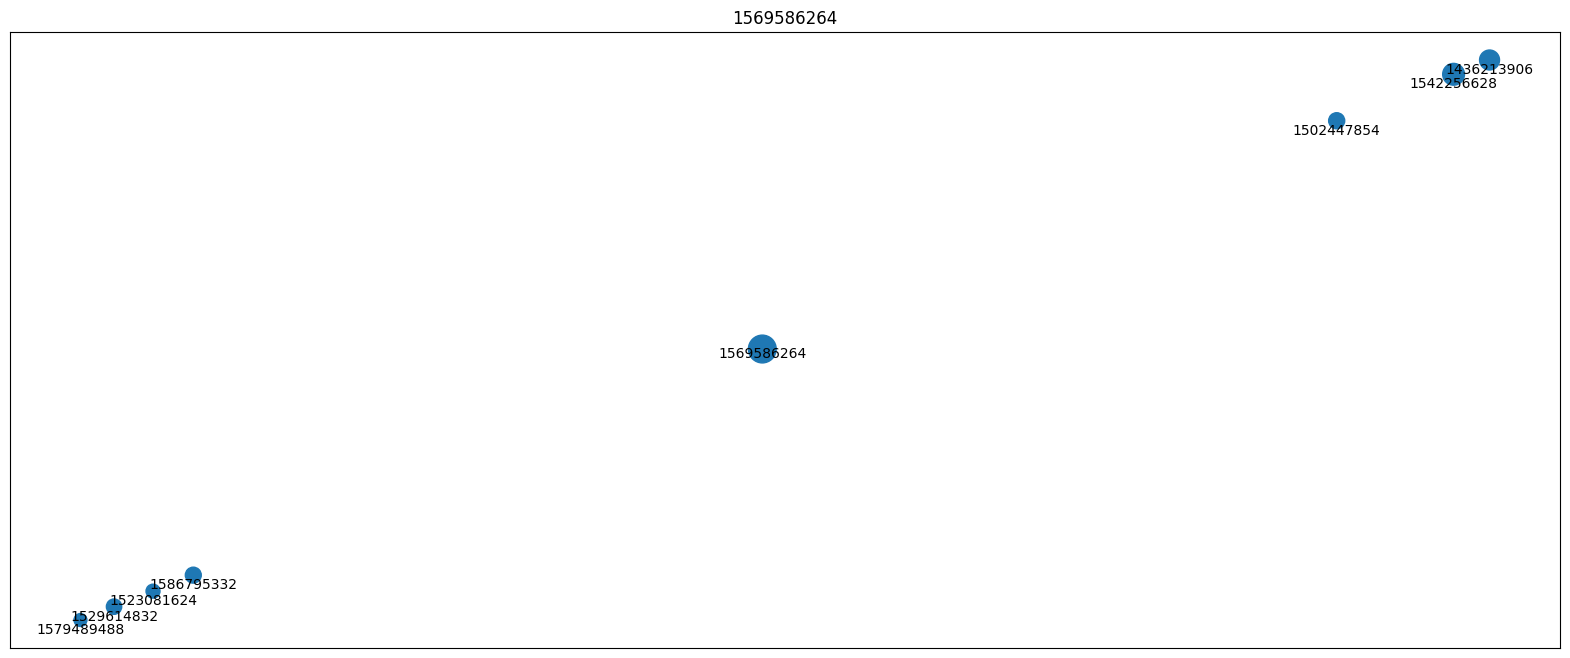

In [25]:
main(df_f_interstitial_iOS, df_app)

# 5.UnitDisplayType: banner; Operating System: Android

                             avg_price  cosine_similarity
bundleId                                                 
com.tilegarden.match3         0.111371           1.000000
com.loop.match3d              0.131116           0.658637
com.kamilbilge.ropesavior3d   0.113202           0.484870
com.tintash.nailsalon         0.087617           0.418847
com.AppIdeas.LevelUpRunner    0.131547           0.407859
com.YayySAL.DodgeAgent        0.128158           0.446939
com.volt.dresstoimpress       0.048968           0.462467
dovi.coalmining.inc           0.132561           0.444795


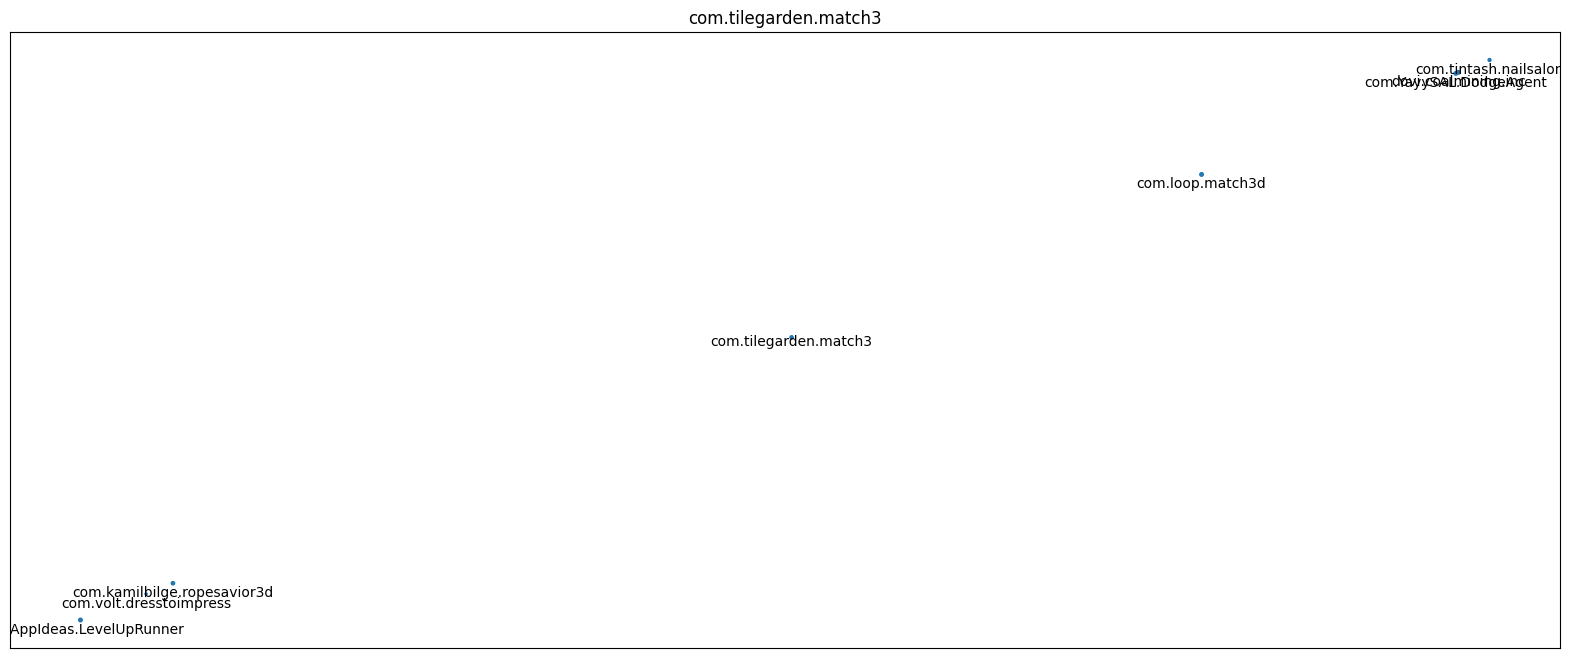

                             avg_price  cosine_similarity
bundleId                                                 
com.tilegarden.match3         0.111371           0.658637
com.loop.match3d              0.131116           1.000000
com.kamilbilge.ropesavior3d   0.113202           0.557880
com.tintash.nailsalon         0.087617           0.459344
com.AppIdeas.LevelUpRunner    0.131547           0.509649
com.YayySAL.DodgeAgent        0.128158           0.480975
com.volt.dresstoimpress       0.048968           0.501801
dovi.coalmining.inc           0.132561           0.469741


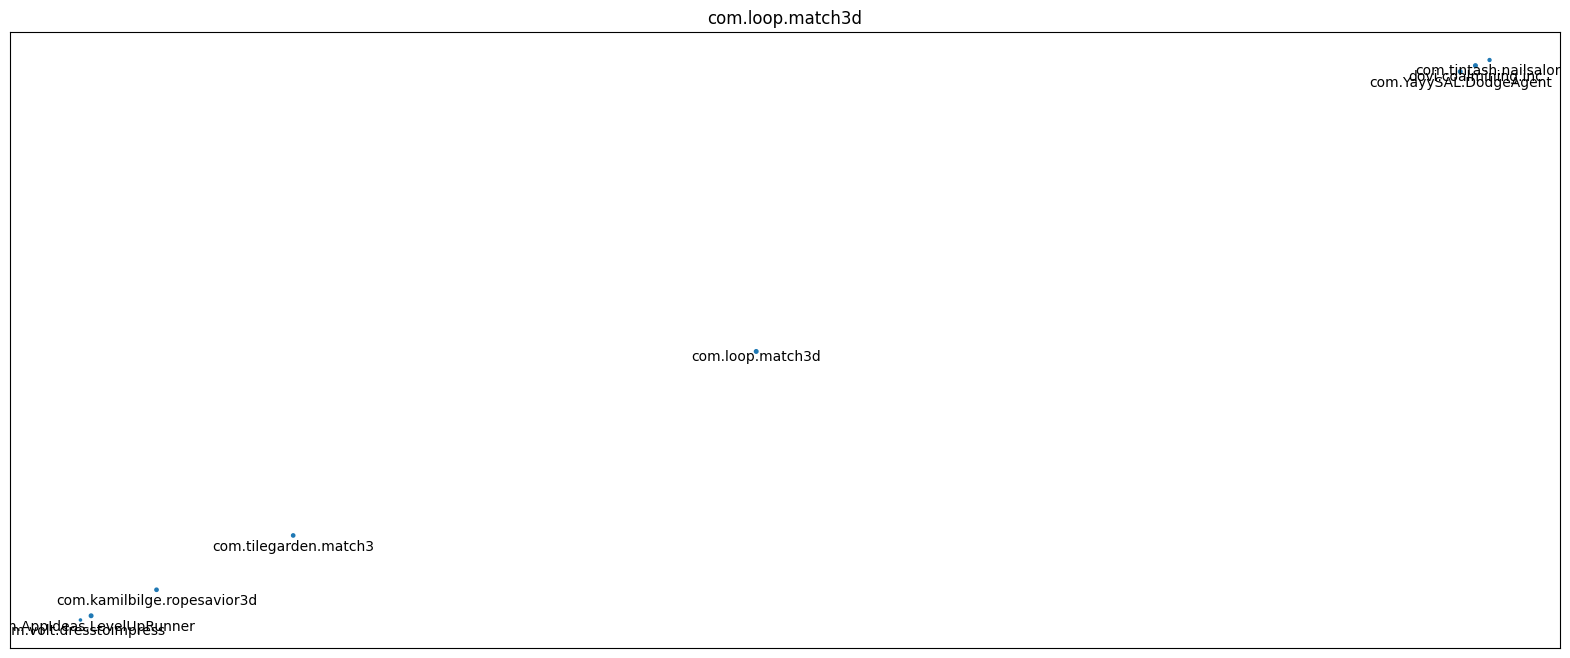

                             avg_price  cosine_similarity
bundleId                                                 
com.tilegarden.match3         0.111371           0.484870
com.loop.match3d              0.131116           0.557880
com.kamilbilge.ropesavior3d   0.113202           1.000000
com.tintash.nailsalon         0.087617           0.397408
com.AppIdeas.LevelUpRunner    0.131547           0.590973
com.YayySAL.DodgeAgent        0.128158           0.647838
com.volt.dresstoimpress       0.048968           0.445463
dovi.coalmining.inc           0.132561           0.511413


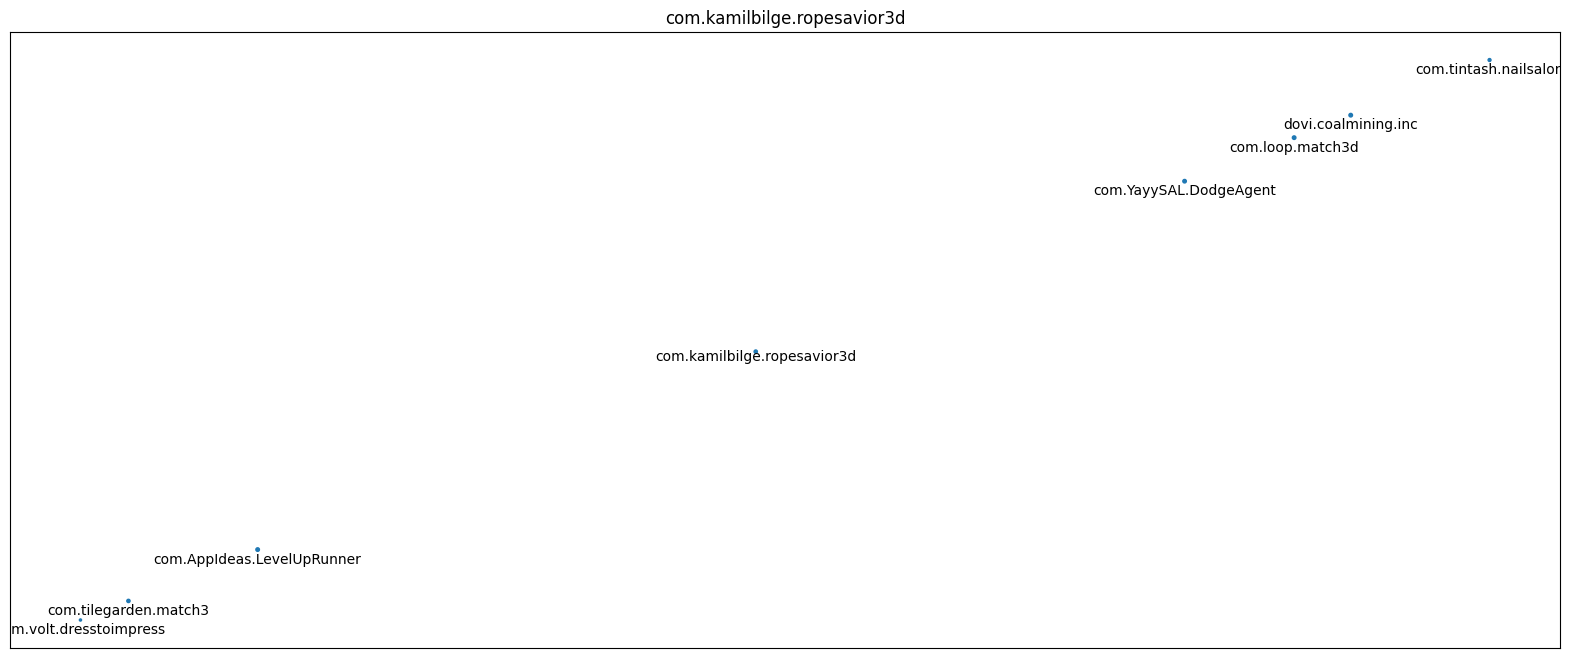

                             avg_price  cosine_similarity
bundleId                                                 
com.tilegarden.match3         0.111371           0.418847
com.loop.match3d              0.131116           0.459344
com.kamilbilge.ropesavior3d   0.113202           0.397408
com.tintash.nailsalon         0.087617           1.000000
com.AppIdeas.LevelUpRunner    0.131547           0.454166
com.YayySAL.DodgeAgent        0.128158           0.389171
com.volt.dresstoimpress       0.048968           0.504474
dovi.coalmining.inc           0.132561           0.525149


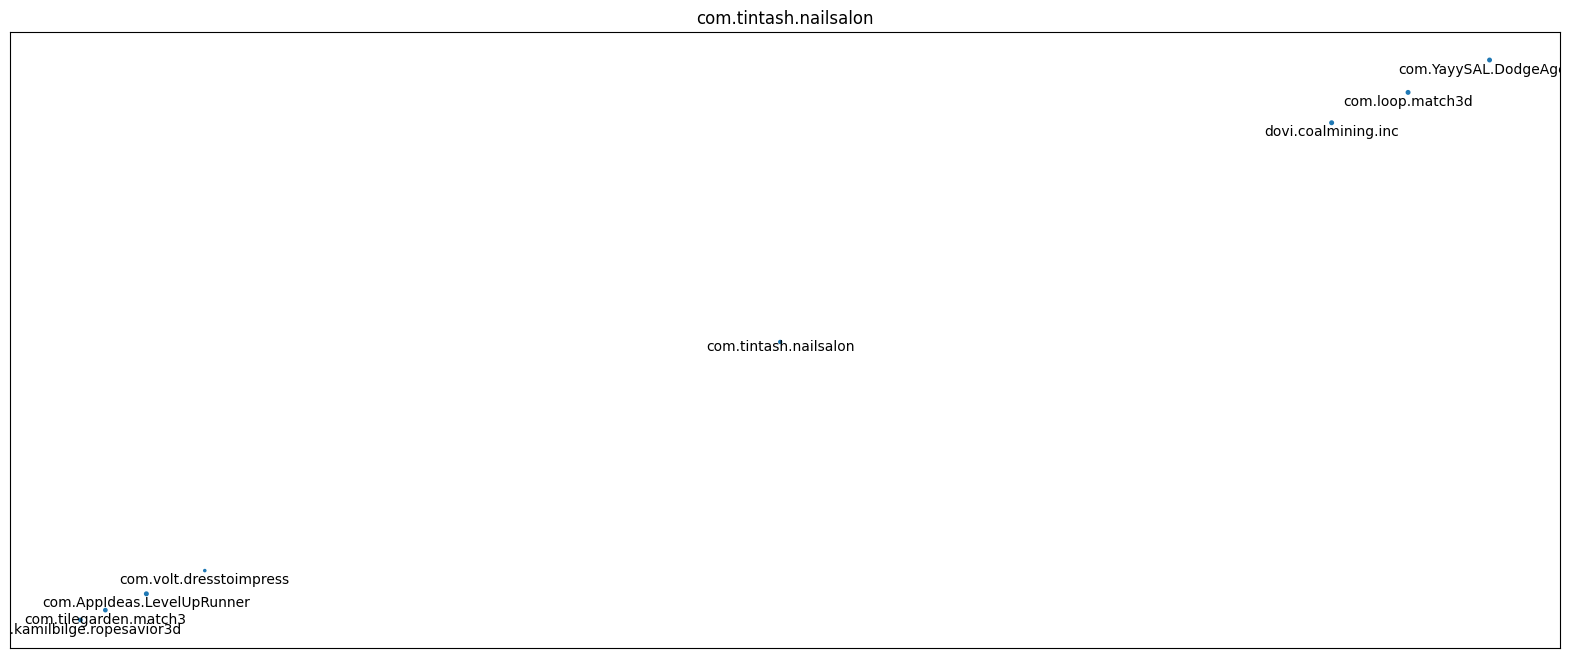

                             avg_price  cosine_similarity
bundleId                                                 
com.tilegarden.match3         0.111371           0.407859
com.loop.match3d              0.131116           0.509649
com.kamilbilge.ropesavior3d   0.113202           0.590973
com.tintash.nailsalon         0.087617           0.454166
com.AppIdeas.LevelUpRunner    0.131547           1.000000
com.YayySAL.DodgeAgent        0.128158           0.589571
com.volt.dresstoimpress       0.048968           0.537237
dovi.coalmining.inc           0.132561           0.449943


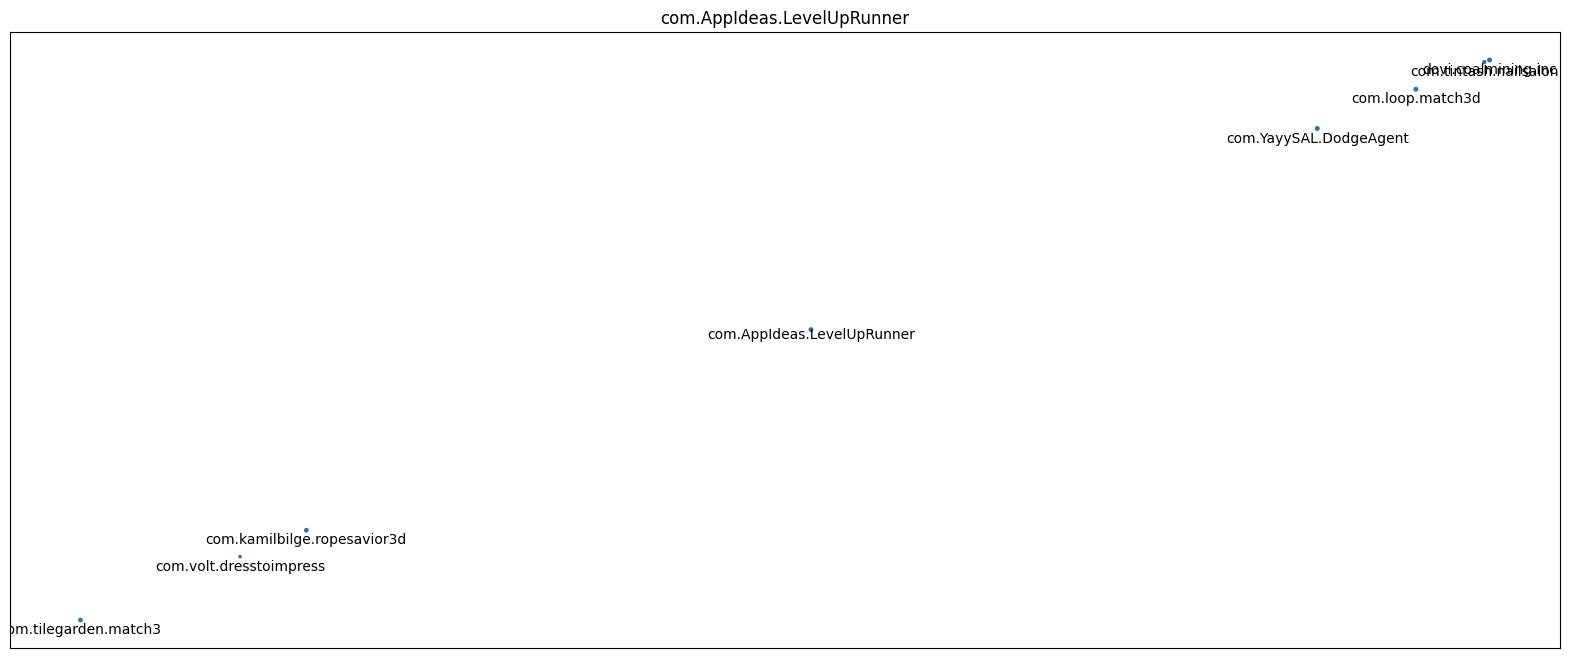

                             avg_price  cosine_similarity
bundleId                                                 
com.tilegarden.match3         0.111371           0.446939
com.loop.match3d              0.131116           0.480975
com.kamilbilge.ropesavior3d   0.113202           0.647838
com.tintash.nailsalon         0.087617           0.389171
com.AppIdeas.LevelUpRunner    0.131547           0.589571
com.YayySAL.DodgeAgent        0.128158           1.000000
com.volt.dresstoimpress       0.048968           0.437803
dovi.coalmining.inc           0.132561           0.490686


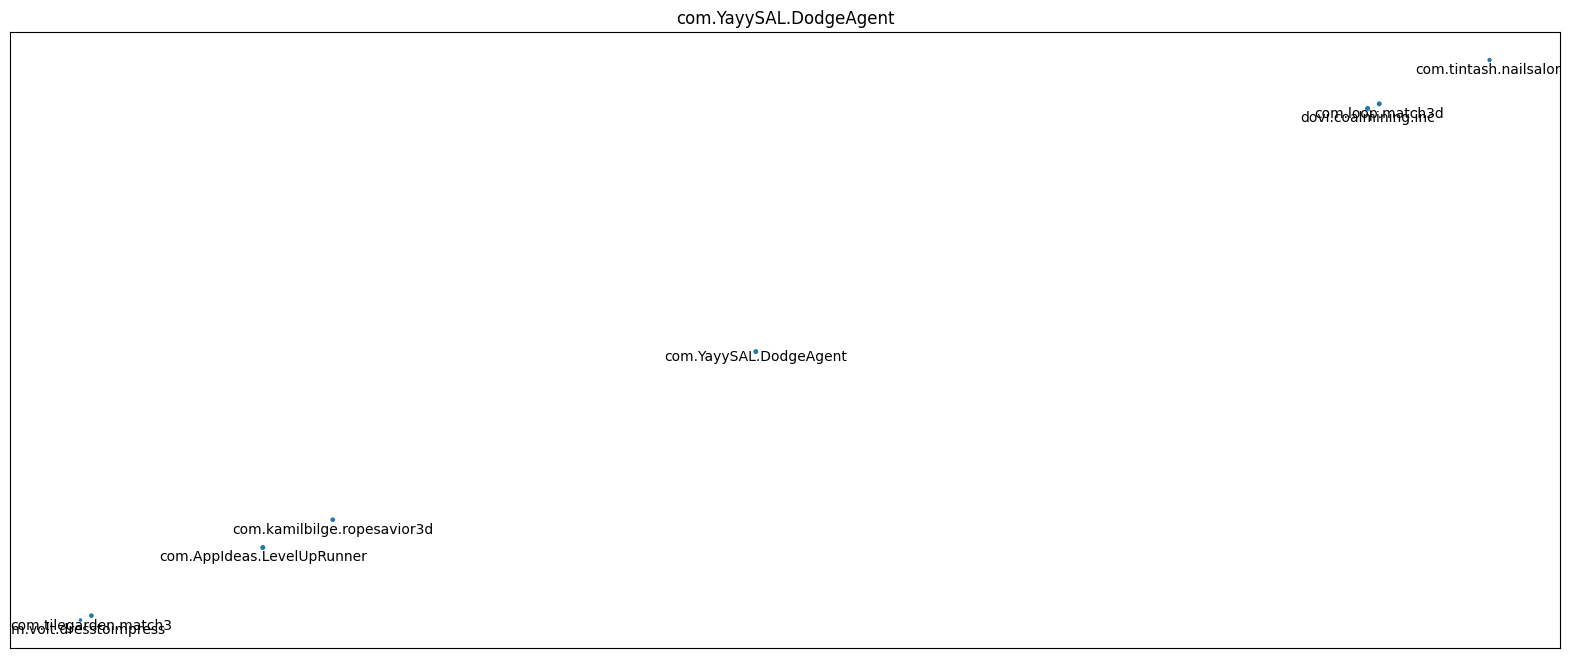

                             avg_price  cosine_similarity
bundleId                                                 
com.tilegarden.match3         0.111371           0.462467
com.loop.match3d              0.131116           0.501801
com.kamilbilge.ropesavior3d   0.113202           0.445463
com.tintash.nailsalon         0.087617           0.504474
com.AppIdeas.LevelUpRunner    0.131547           0.537237
com.YayySAL.DodgeAgent        0.128158           0.437803
com.volt.dresstoimpress       0.048968           1.000000
dovi.coalmining.inc           0.132561           0.377867


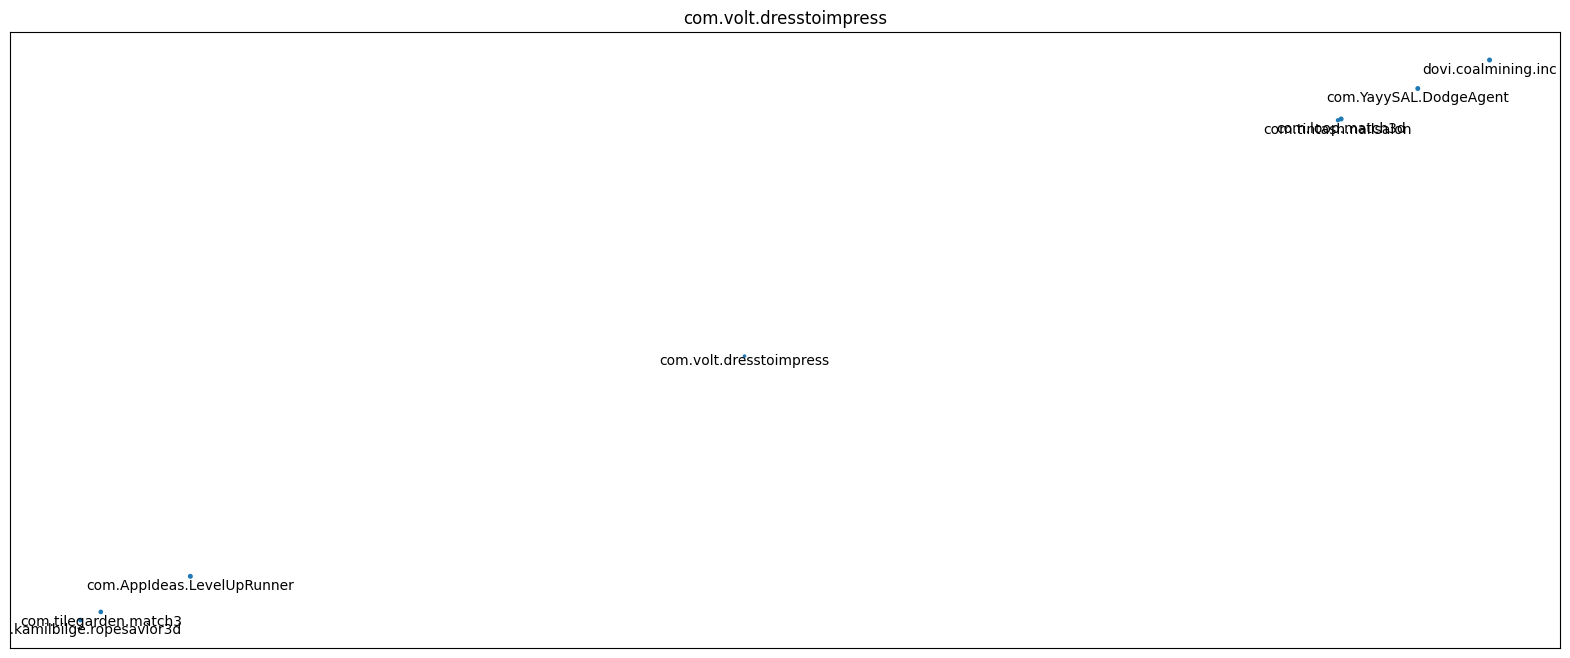

                             avg_price  cosine_similarity
bundleId                                                 
com.tilegarden.match3         0.111371           0.444795
com.loop.match3d              0.131116           0.469741
com.kamilbilge.ropesavior3d   0.113202           0.511413
com.tintash.nailsalon         0.087617           0.525149
com.AppIdeas.LevelUpRunner    0.131547           0.449943
com.YayySAL.DodgeAgent        0.128158           0.490686
com.volt.dresstoimpress       0.048968           0.377867
dovi.coalmining.inc           0.132561           1.000000


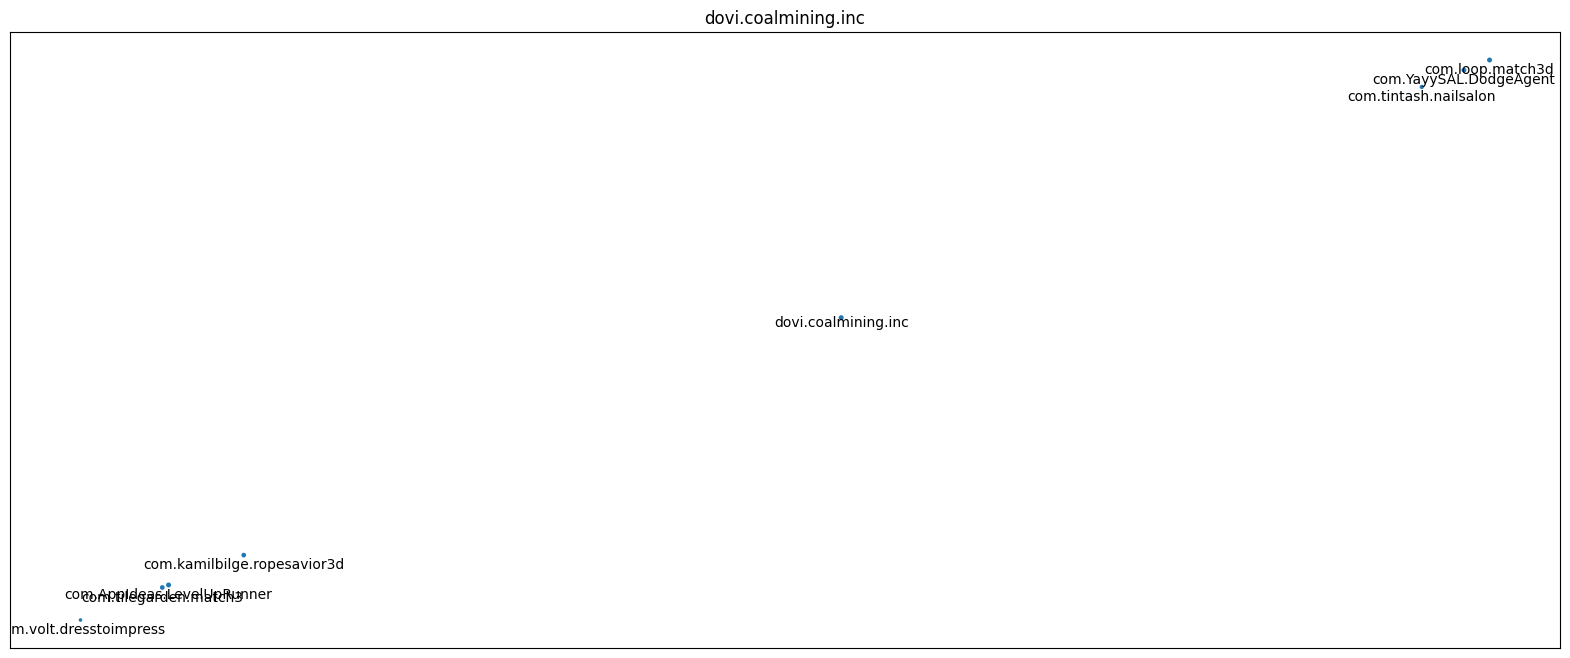

In [26]:
main(df_f_banner_Android, df_app)

# 6.UnitDisplayType: banner; Operating System: iOS

            avg_price  cosine_similarity
bundleId                                
1529614832   0.329252           1.000000
1502447854   0.205629           0.742816
1542256628   0.485537           0.444397
1579489488   0.289212           0.510735
1523081624   0.235398           0.397721
1586795332   0.366098           0.434522
1582745578   0.289167           0.408701


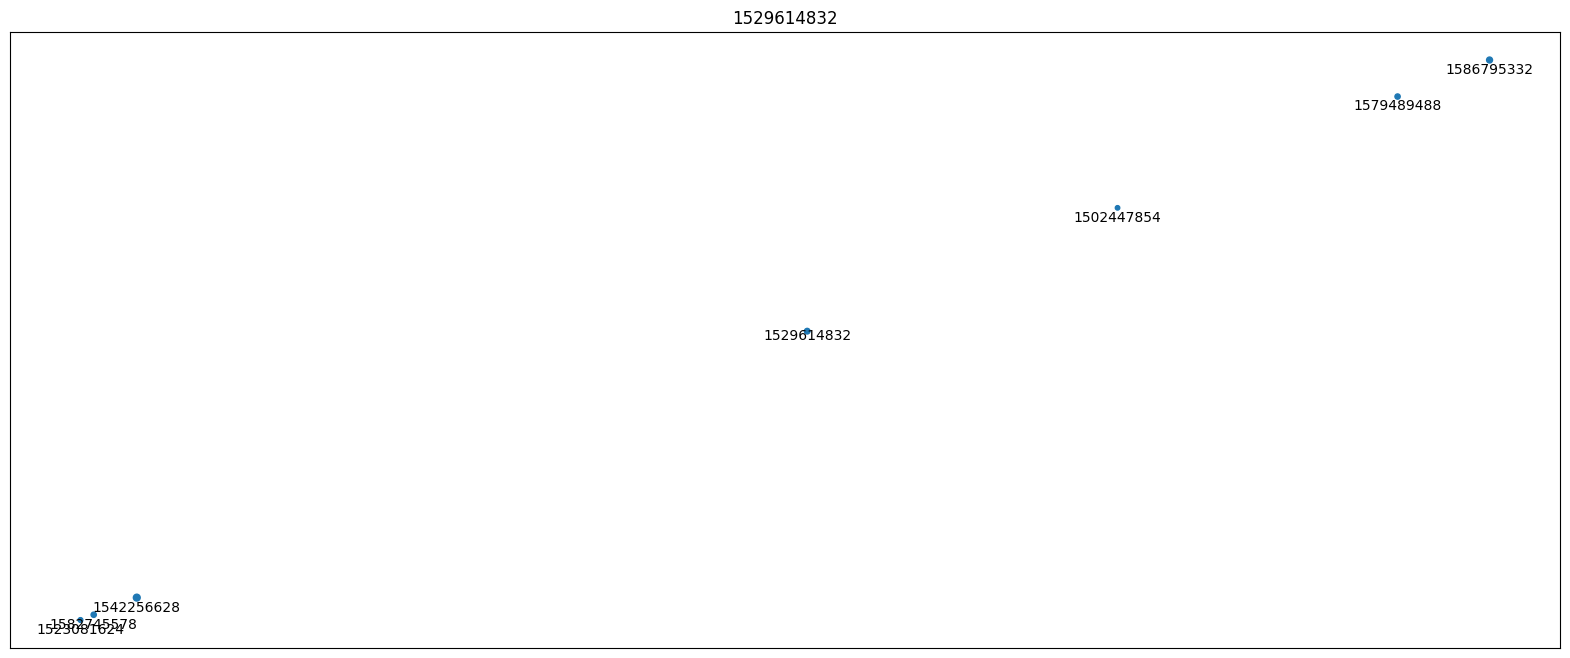

            avg_price  cosine_similarity
bundleId                                
1529614832   0.329252           0.742816
1502447854   0.205629           1.000000
1542256628   0.485537           0.504298
1579489488   0.289212           0.589520
1523081624   0.235398           0.497849
1586795332   0.366098           0.521311
1582745578   0.289167           0.490862


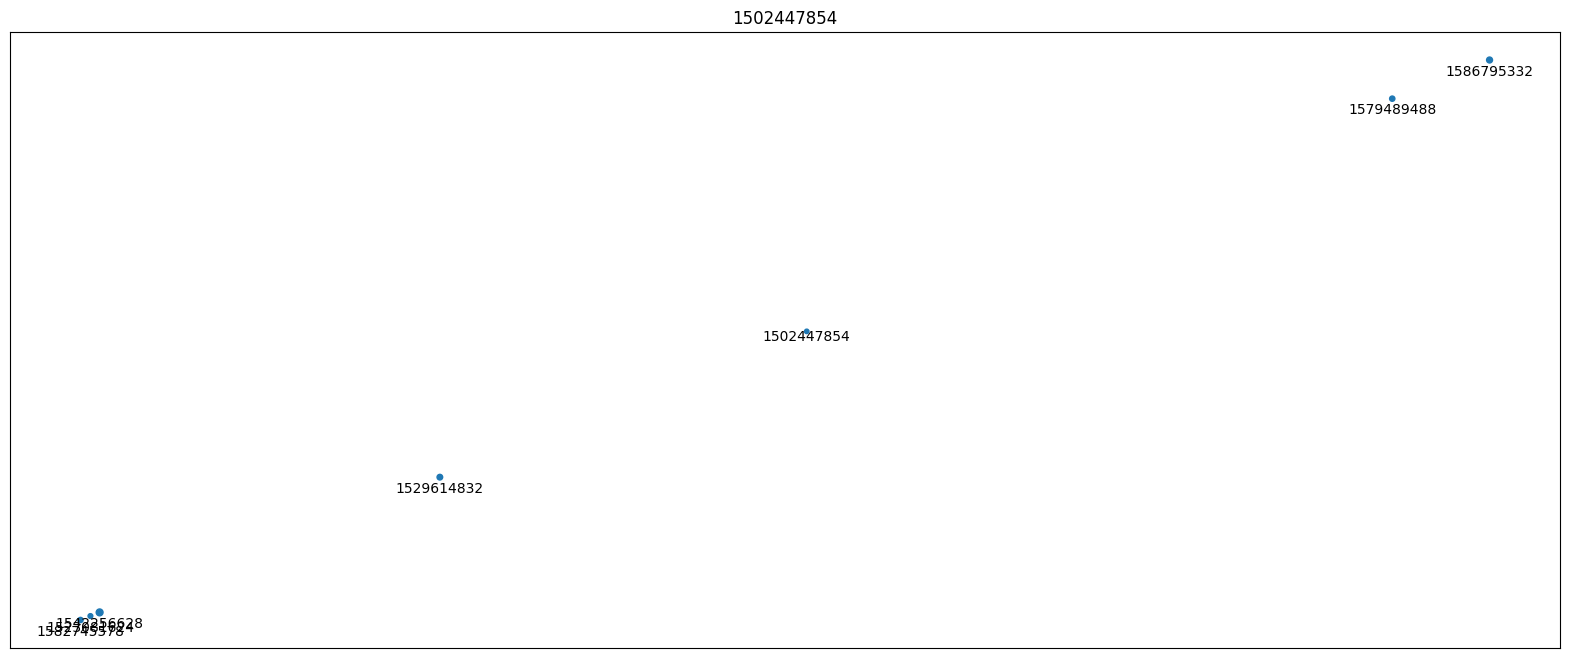

            avg_price  cosine_similarity
bundleId                                
1529614832   0.329252           0.444397
1502447854   0.205629           0.504298
1542256628   0.485537           1.000000
1579489488   0.289212           0.647838
1523081624   0.235398           0.389171
1586795332   0.366098           0.589571
1582745578   0.289167           0.490686


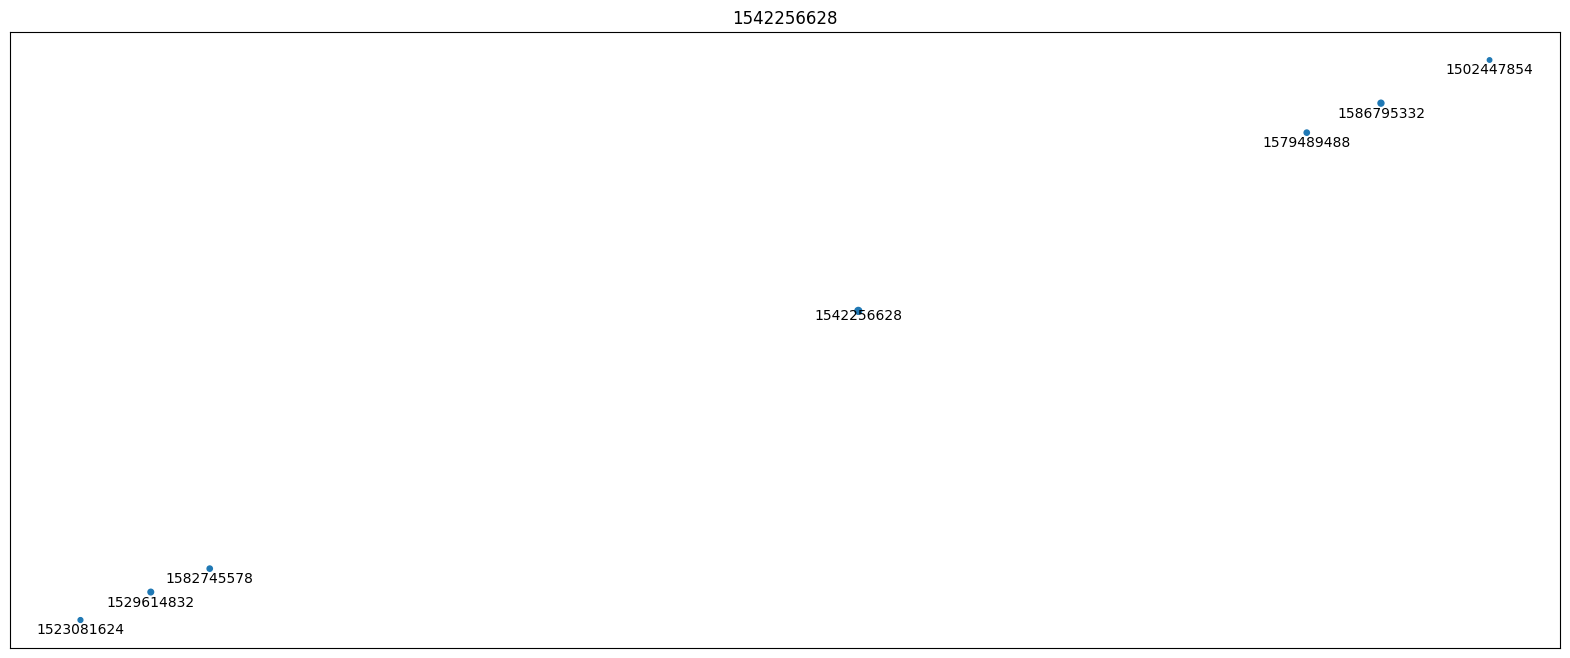

            avg_price  cosine_similarity
bundleId                                
1529614832   0.329252           0.510735
1502447854   0.205629           0.589520
1542256628   0.485537           0.647838
1579489488   0.289212           1.000000
1523081624   0.235398           0.397408
1586795332   0.366098           0.590973
1582745578   0.289167           0.511413


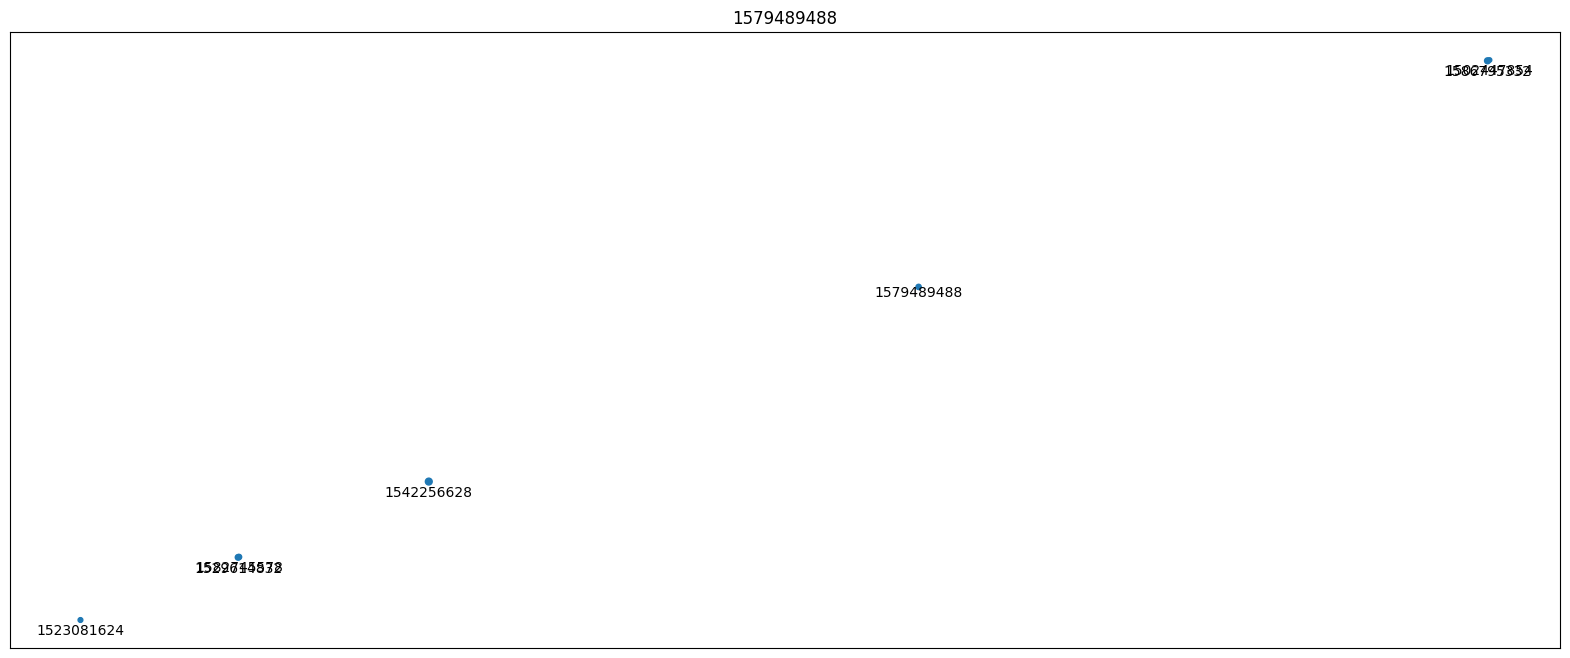

            avg_price  cosine_similarity
bundleId                                
1529614832   0.329252           0.397721
1502447854   0.205629           0.497849
1542256628   0.485537           0.389171
1579489488   0.289212           0.397408
1523081624   0.235398           1.000000
1586795332   0.366098           0.454166
1582745578   0.289167           0.525150


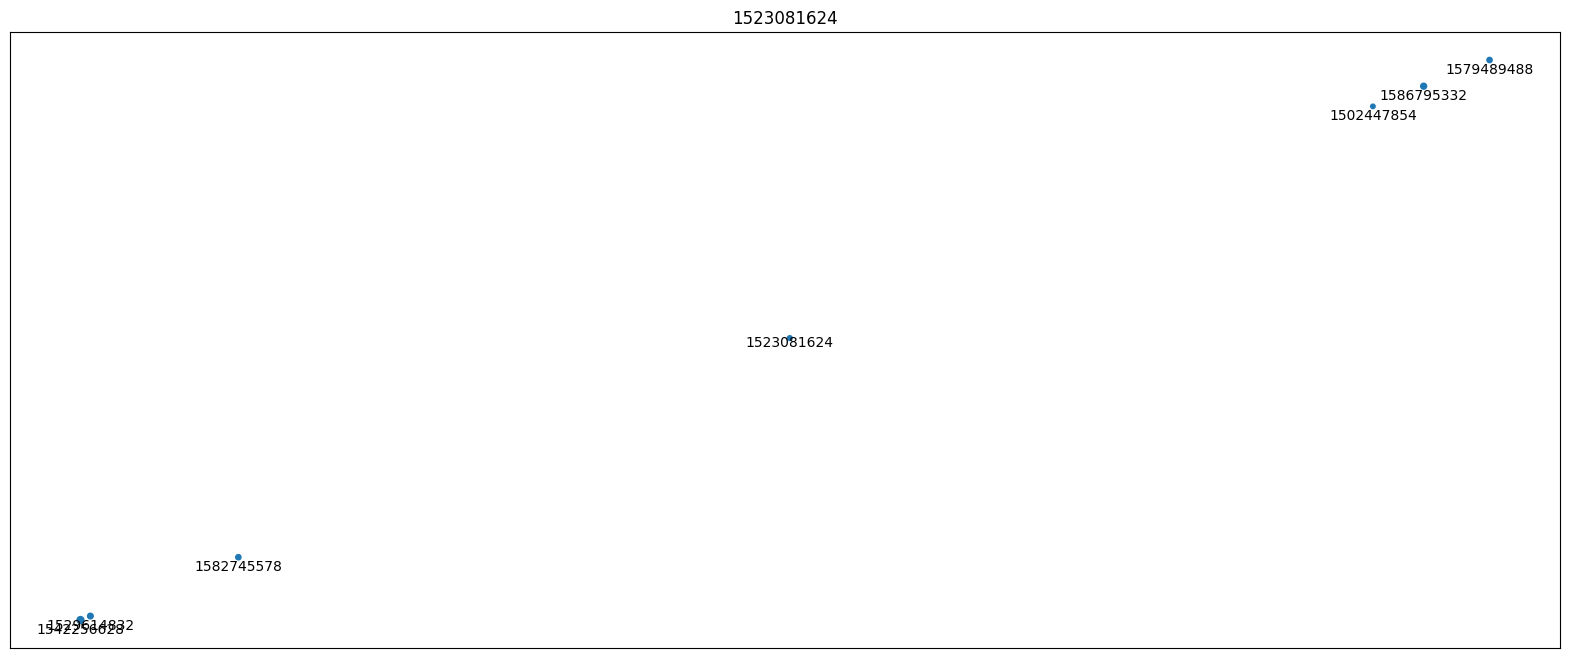

            avg_price  cosine_similarity
bundleId                                
1529614832   0.329252           0.434522
1502447854   0.205629           0.521311
1542256628   0.485537           0.589571
1579489488   0.289212           0.590973
1523081624   0.235398           0.454166
1586795332   0.366098           1.000000
1582745578   0.289167           0.449943


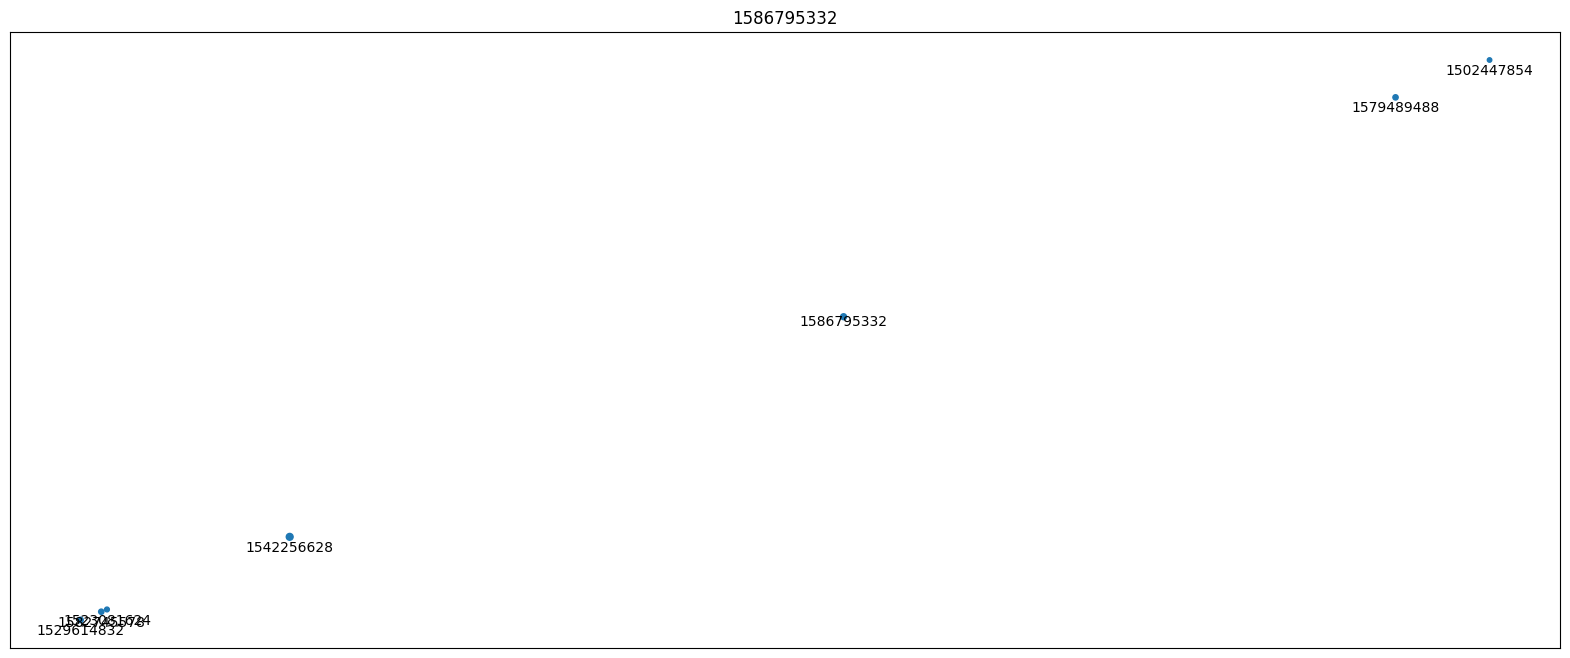

            avg_price  cosine_similarity
bundleId                                
1529614832   0.329252           0.408701
1502447854   0.205629           0.490862
1542256628   0.485537           0.490686
1579489488   0.289212           0.511413
1523081624   0.235398           0.525150
1586795332   0.366098           0.449943
1582745578   0.289167           1.000000


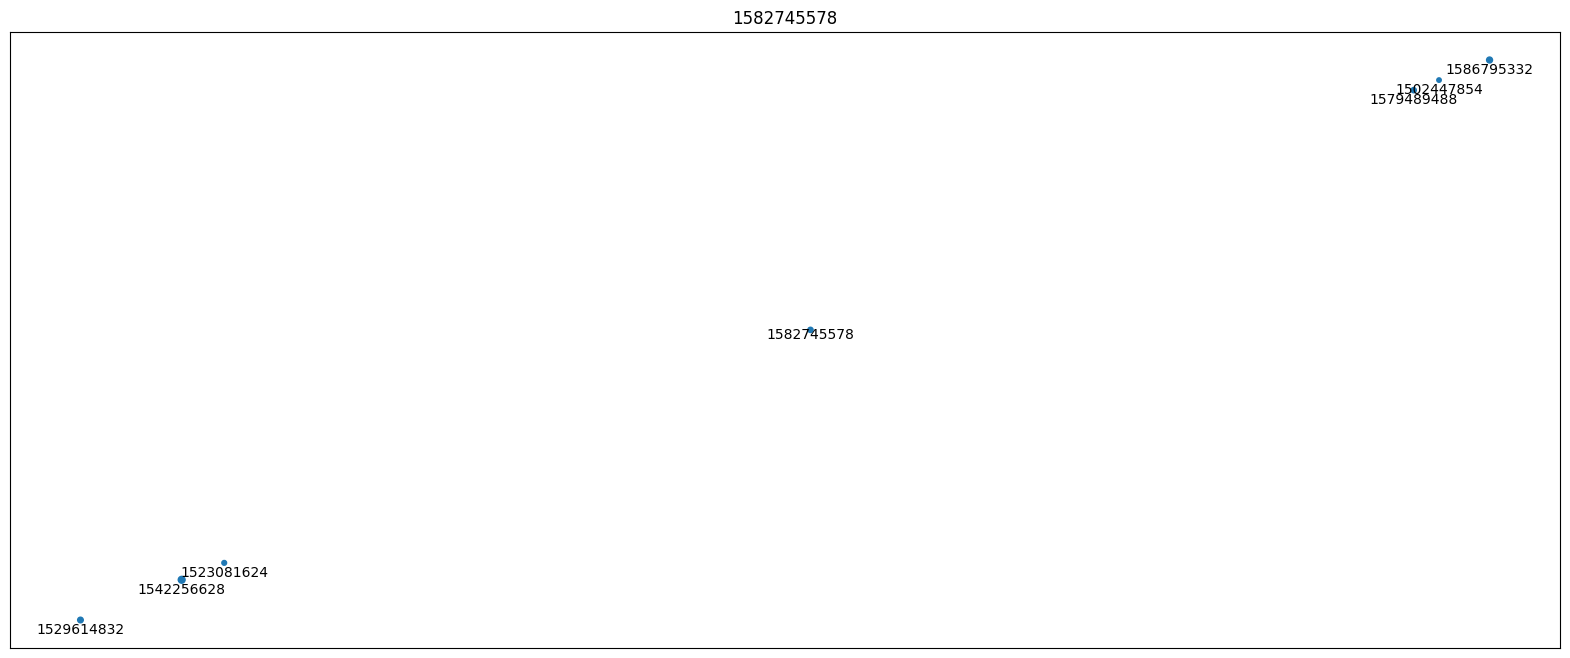

In [27]:
main(df_f_banner_iOS, df_app)

# Country contribution

As we can see from above filtering the data's outliers and considering the features of unitDisplayType and Operating system gives us better results (more than the similarity between apps), but it is still not perfect there are some majore diffrances between apps sents prices that we stil not understand lets add the country data by the catagorize we found in the EDA using k_means.

In [29]:
df_filtered["embedding"] = list(df_filtered["bundleId"].apply(lambda x:df_app[df_app.bundleId==df_app.bundleId[0]]["embedding"].values[0]))
df_filtered.to_sql(name='bids', con=engine)

In [30]:
app_list = df_filtered.bundleId.unique()
n = len(app_list)
app_list_ios = []
app_list_and = []
for i in range(n):  
   if df_app["bundleId"][i][0] == '1':
       app_list_ios.append(df_app["bundleId"][i])
   else:
       app_list_and.append(df_app["bundleId"][i])
df_app_ios = df_app[df_app.bundleId.isin(app_list_ios)]
df_app_and = df_app[df_app.bundleId.isin(app_list_and)]
# df_app_ios.to_sql(name='app_ios1', con=engine)
# df_app_and.to_sql(name='app_and1', con=engine)

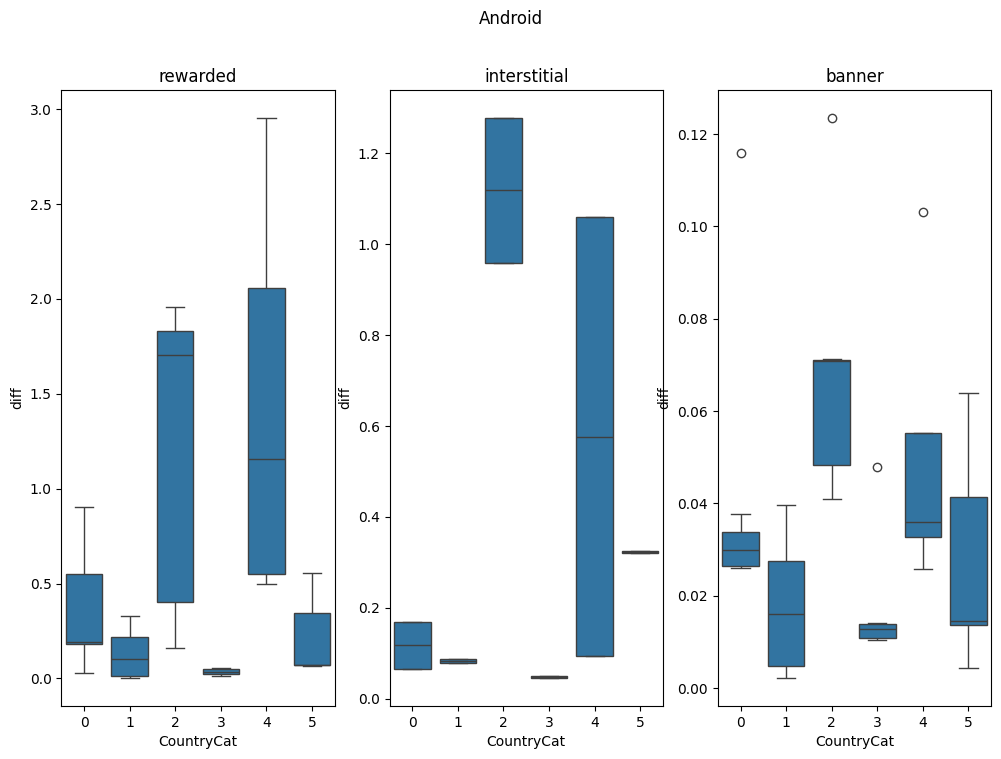

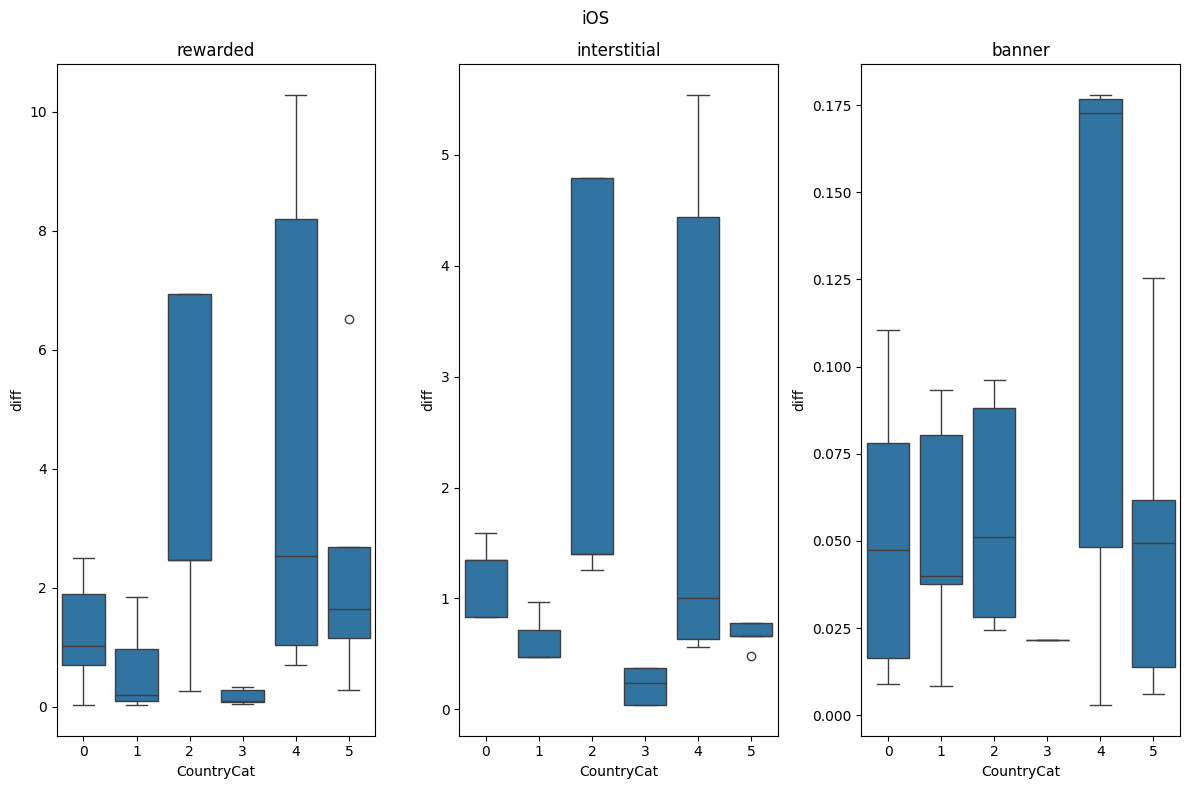

In [31]:
country_cat = df_filtered["CountryCat"].unique() 
unit_list = df_filtered["unitDisplayType"].unique()
os_list = df_filtered["os"].unique()

#Gets avg price  grouped by the requested parmaters
sql_query = f'''
               SELECT "bundleId","unitDisplayType","os","CountryCat", AVG("sentPrice") AS avg
               FROM bids GROUP BY "bundleId","unitDisplayType","os","CountryCat" ORDER BY avg
                ''' 

with engine.connect() as db_con:
       df = pd.read_sql(sql_query, con=db_con)
##

diff_and = []
diff_ios = []

app_list = df_app.bundleId.unique()
n = len(app_list)

for i in range(n):          
    ix =df_app[df_app.bundleId==app_list[i]].index.values[0]
    vec = json.loads(df_app.embedding[ix])
    # takes only android apps to get similarity 
    if df_app.id[ix]<10: 
        sql_query = f'''
                       SELECT 1 - (embedding<=>'{json.dumps(vec)}') AS most_similar,"bundleId" FROM app_vectors WHERE "id"<10
                       ORDER BY most_similar DESC LIMIT 2
                       '''
        with engine.connect() as db_con:
           temp = pd.read_sql(sql_query, con=db_con)
            
        for j in unit_list:
            for jj in country_cat: #calc the 2 similar apps under the same features
               try: 
                  x0 = df[(df.bundleId==temp.loc[0]["bundleId"])& (df.unitDisplayType==j) & (df.CountryCat==jj)]["avg"].values[0]
                  x1 =df[(df.bundleId==temp.loc[1]["bundleId"])& (df.unitDisplayType==j) & (df.CountryCat==jj)]["avg"].values[0]
                  diff_and.append([j,jj,np.abs(x0-x1)])
               except:
                  continue
    else:
        sql_query = f'''
                       SELECT 1 - (embedding<=>'{json.dumps(vec)}') AS most_similar,"bundleId" FROM app_vectors WHERE "id">=10
                       ORDER BY most_similar DESC LIMIT 2
                       '''
        with engine.connect() as db_con:
            temp = pd.read_sql(sql_query, con=db_con)
        for j in unit_list:
           for jj in country_cat: #calc the 2 similar apps under the same features
               try: 
                  x0 = df[(df.bundleId==temp.loc[0]["bundleId"])& (df.unitDisplayType==j) & (df.CountryCat==jj)]["avg"].values[0]
                  x1 =df[(df.bundleId==temp.loc[1]["bundleId"])& (df.unitDisplayType==j) & (df.CountryCat==jj)]["avg"].values[0]
                  diff_ios.append([j,jj,np.abs(x0-x1)])
               except:
                  continue
diff_ios, diff_and
df_diff_and = pd.DataFrame(diff_and, columns=["unitDisplayType","CountryCat","diff"])
df_diff_ios = pd.DataFrame(diff_ios, columns=["unitDisplayType","CountryCat","diff"])

fig, axes = plt.subplots(1,3,figsize=[12,8])

for name, ax in zip(unit_list, axes.flatten()):
    sns.boxplot(data=df_diff_and[df_diff_and.unitDisplayType==name], x="CountryCat", y="diff", orient='v', ax=ax).set(title=name)
plt.suptitle('Android')

fig, axes = plt.subplots(1,3,figsize=[12,8])

for name, ax in zip(unit_list, axes.flatten()):
    sns.boxplot(data=df_diff_ios[df_diff_ios.unitDisplayType==name], x="CountryCat", y="diff", orient='v', ax=ax).set(title=name)
plt.suptitle('iOS')
plt.tight_layout()

In [32]:
# Data count
df_diff_and.groupby(["unitDisplayType","CountryCat"])["diff"].count(),df_diff_ios.groupby(["unitDisplayType","CountryCat"])["diff"].count()


(unitDisplayType  CountryCat
 banner           0             7
                  1             6
                  2             6
                  3             6
                  4             7
                  5             7
 interstitial     0             4
                  1             4
                  2             4
                  3             4
                  4             4
                  5             4
 rewarded         0             7
                  1             7
                  2             7
                  3             7
                  4             7
                  5             7
 Name: diff, dtype: int64,
 unitDisplayType  CountryCat
 banner           0             6
                  1             6
                  2             6
                  3             3
                  4             6
                  5             6
 interstitial     0             5
                  1             3
                  2            

# Conclusions

1. By looking at the scaels of the last figures we can see that indeed banner has lower sent price for both operating systems , interstitial second highest and rewarded the highest for all.
2. iOS apps has higher bids in all cases than Android apps.
3. Under some conditions we have very good indication regarding the price , as we can see in the std, yet we need to take into account that we have only compared the first app with the highest similarity score under the same conditions therefore if that app didn't have a bid under the same features conditions we don't have data.

We have seen good indications for what features support the sen price best, yet there are still things to do.
1. Add more data.
2. Explore other catagorization of countries maybe suits us more . maybe use https://worldpopulationreview.com/countries/by-gdp the gdp per capital of the country maybe take into account the continent.
3. Add Analysis for second similar (yet I don't belive it will work better the highest similarity scores were between apps with diffrent OS , inside the same OS the similarity is about 0.5 or lower.
4. Continue exploring the 1% that was left out in the EDA why are they so high?

